[View in Colaboratory](https://colab.research.google.com/github/nachotp/Tarea1-INF395/blob/master/Tarea_1.ipynb)

<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Entrenamiento de redes *Feed-Forward* vı́a GD y variantes (SGD, mini-*batches*), *momentum*, regularización y tasa de aprendizaje adaptiva.
* Evaluación de redes *Feed-Forward* vı́a validación cruzada (cross-validation).
* Rol de capas ocultas y mayor profundidad (*Deep Learning*).
* Identificar el gradiente desvaneciente.
* Diseño y entrenamiento de Redes Convolucionales (CNNs).
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 04 Abril
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea1-INF395-I-2018]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Predicción del precio de una Casa  
[2.](#segundo) *Deep Networks*  
[3.](#tercero) Convolutional Neural Network (CNN) en CIFAR.  
[4.](#cuarto) Aplicación de una red neuronal en Localización

<hr style="height:2px;border:none"/>
**Integrantes**  
* Felipe González Pizarro - 201273534-3
* Ignacio Tampe Palma - 201573514-k

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
from keras.regularizers import *

from keras.regularizers import l2

from keras.callbacks import LearningRateScheduler
import math

import tensorflow as tf
import keras
from keras import backend as K
import seaborn as sns
#!/usr/bin/env python
import matplotlib.mlab as mlab


ModuleNotFoundError: ignored

<a id="primero"></a>
## 1. Predicción del precio de una Casa

En esta sección trabajaremos con un pequeño dataset conocido como **Boston Housing** que nos permitirá experimentar de modo más completo y exhaustivo con las técnicas bajo estudio. El problema consiste en predecir el precio de una casa en una zona/barrio de Boston (*USA*) a partir de una serie de atributos que describen el lugar que éste se ubica: tasa de criminalidad, proporción de zona residencial, proporción de zona industrial, si se encuentra junto al rı́o ó no, contaminación atmosférica medida como la concentración de óxidos nı́tricos en el aire, entre otros. Para ver en detalle la descripción de la semántica asociada a los atributos de este problema, puede consultar   __[Housing](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/)__.

<div align="center"><img src="https://www.americaninno.com/wp-content/uploads/wpallimport/files/1/2014/12/Screen-Shot-2014-12-10-at-8.57.47-AM.png"></img></div>


> a) Construya un *dataframe* con los datos a analizar descargando los datos desde la URL mantenida por los autores de *The Elements of Statistical Learning*. Convierta la variable *CHAS* a un vector binario de dos componentes indicando las 2 posibilidades de su valor, indique la conveniencia de este paso. Describa brevemente el dataset utilizar.

In [0]:
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
df = pd.get_dummies(df,columns=["CHAS"]) #transformar data categorica en dummies data




La data ha sido guardada en la variable *df*, tras haber realizado esto se puede obtener información valiosa de los datos

In [3]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
CRIM       506 non-null float64
ZN         506 non-null int64
INDUS      506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null int64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
CHAS_0     506 non-null uint8
CHAS_1     506 non-null uint8
dtypes: float64(9), int64(4), uint8(2)
memory usage: 52.5 KB


CRIM          ZN       INDUS         NOX          RM         AGE  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.347826   11.136779    0.554695    6.284634   68.574901   
std      8.601545   23.310593    6.860353    0.115878    0.702617   28.148861   
min      0.006320    0.000000    0.460000    0.385000    3.561000    2.900000   
25%      0.082045    0.000000    5.190000    0.449000    5.885500   45.025000   
50%      0.256510    0.000000    9.690000    0.538000    6.208500   77.500000   
75%      3.677082   12.000000   18.100000    0.624000    6.623500   94.075000   
max     88.976200  100.000000   27.740000    0.871000    8.780000  100.000000   

              DIS         RAD         TAX     PTRATIO           B       LSTAT  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.795043    9.549407  408.237154   18.083004  356.674032   12.653063   
std      2.105710    8.707259  168.537116    2.280574   91.294864    7.141062   
min      1.129600    1.000000  187.000000   12.000000    0.320000    1.730000   
25%      2.100175    4.000000  279.000000   17.000000  375.377500    6.950000   
50%      3.207450    5.000000  330.000000   19.000000  391.440000   11.360000   
75%      5.188425   24.000000  666.000000   20.000000  396.225000   16.955000   
max     12.126500   24.000000  711.000000   22.000000  396.900000   37.970000   

             MEDV      CHAS_0      CHAS_1  
count  506.000000  506.000000  506.000000  
mean    22.532806    0.930830    0.069170  
std      9.197104    0.253994    0.253994  
min      5.000000    0.000000    0.000000  
25%     17.025000    1.000000    0.000000  
50%     21.200000    1.000000    0.000000  
75%     25.000000    1.000000    0.000000  
max     50.000000    1.000000    1.000000

El dataset **Housing** contiene 506 filas, cada una de ellas entrega la siguiente información:
* CRIM: tasa de delincuencia per cápita por ciudad
* ZN: proporción de tierra residencial dividida en zonas para lotes de más de 25,000 pies cuadrados.
* INDUS: proporción de acres de negocios no minoristas por ciudad
* CHAS: Variable ficticia de Charles River (= 1 si el tramo limita el río, 0 de lo contrario)
* NOX: concentración de óxidos nítricos (partes por 10 millones)
* RM: número promedio de habitaciones por vivienda
* AGE: Proporción de unidades ocupadas por el propietario construidas antes de 1940
* DIS: distancias ponderadas a cinco centros de empleo de Boston
* RAD: Índice de accesibilidad a carreteras radiales
* TAX: Tasa de impuesto a la propiedad por \$10.000
* PTRATIO: Proporción de alumnos por maestro por ciudad
* B 1000 (Bk - 0.63) ^ 2 donde Bk es la proporción de personas de color por ciudad
* LSTAT % estado más bajo de la población
* MEDV Valor medio de las viviendas ocupadas por sus propietarios en \$1000

El siguiente boxplot describe los valores obtenidos para cada una de las columnas mencionadas


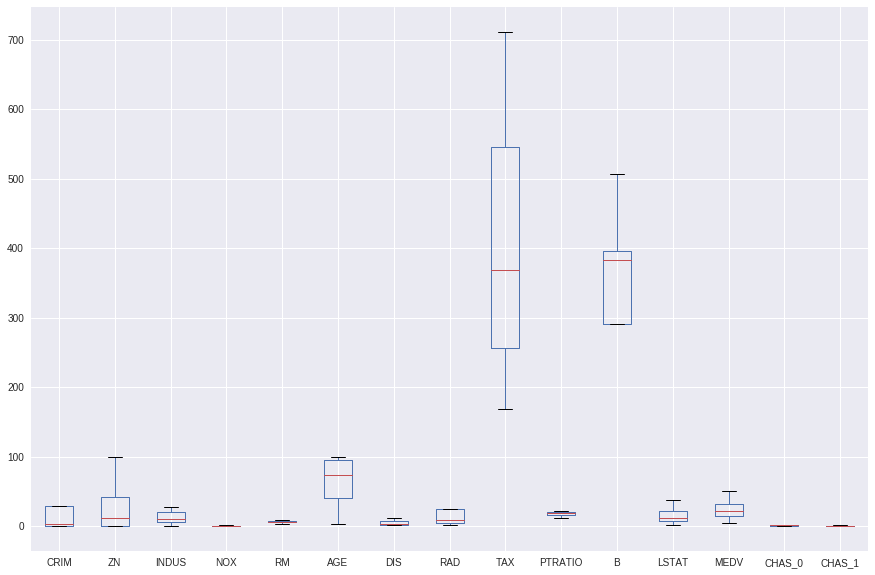

In [4]:
df.describe().boxplot(figsize=(15,10));



La data extraída fue dividida en dos conjuntos, uno de entrenamiento (75% de los datos) y otro de testing (25% de los datos). 

In [5]:

df_train,df_test= train_test_split(df,test_size=0.25, random_state=0) #dividir la data. El test será un 25% de la data inicial
print("Len Data Entrenamiento:"+str(len(df_train)))
print("Len Data Test:"+str(len(df_test)))

Len Data Entrenamiento:379
Len Data Test:127


Es una buena práctica el normalizar los datos antes de trabajar con el modelo. Se deben normalizar los datos porque ocurre que al no hacerlo, la red da pesimos resultados. Algunos algoritmos asumen que la data esta normalizada y sigue una cierta distribución.


In [0]:
#Normalizar datos de entrenamiento
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train = df_train.pop('MEDV').values.reshape(-1,1) 

In [0]:
#Normalizar datos de testeo
scaler = StandardScaler().fit(df_test)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
y_test = df_test.pop('MEDV').values.reshape(-1,1) 

 <font color='red'> ¡!¡!¡!¡!¿Por que fue importante pasar CHAS  a categorica? RESPONDER  HABLAR MAS SOBRE LOS DATOS</font> 

>b) Muestre en un gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de *epochs* de entrenamiento, para una red *feedforward* de 3 capas, con 200 unidades ocultas y función de activación sigmoidal. Entrene la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 300 epochs de entrenamiento, en el conjunto de entrenamiento y de pruebas. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.

### Entranamiento y Testing con Sigmoid

La red ha ser creada contiene tres capas:
>* Capa de entrada: X_train_scaled.shape[1]
>* Capa oculta: 200 neuronas. funcion activacion: sigmoid
>* Capa salida: 1 neurona, funcion act: lineal

Dado que es un problema de regresión, por esa razón se utilizará la función de activación:'linear' en la capa de salida.

In [0]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear')) 
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')


In [0]:
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))


In [0]:
loss_train_sigmoid = hist_sigmoid.history['loss']
loss_test_sigmoid = hist_sigmoid.history['val_loss']



La ejecución del algoritmo anterior permitió obtener la pérdida *loss* por epoch con los datos de entrenamiento y con los datos de *testing* (estos últimos fueron calculados al finalizar cada epoch).

Hay que dejar en claro que la red de entrenamiento no utiliza los datos de testing en ningún momento para entrenarse a si misma. 

Lo anterior lleva a los siguientes resultados:

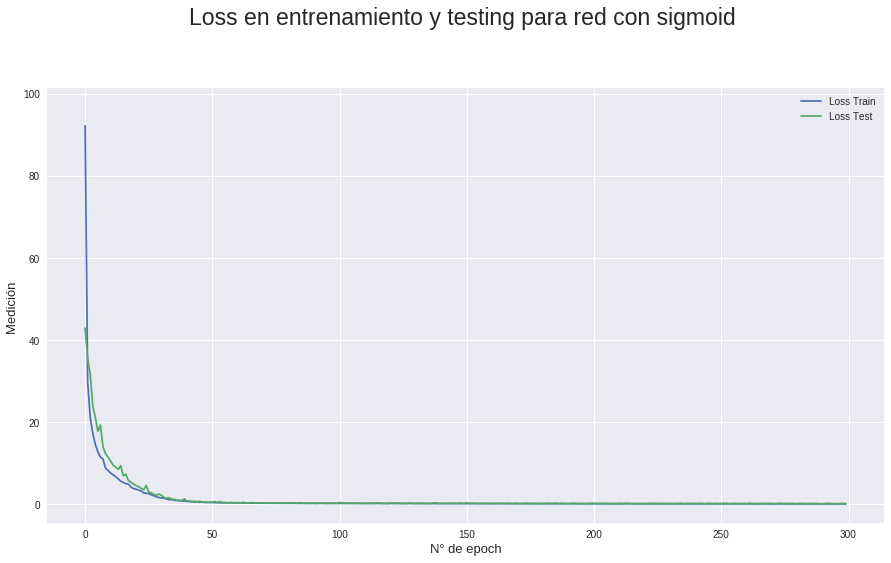

In [13]:

x = [max(loss_train_sigmoid),max(loss_test_sigmoid)]
valor_maximo = max(x)*1.1

plt.figure(1, figsize=(15,8))
plt.title("Loss en entrenamiento y testing para red con sigmoid \n", fontsize=23, y=1.07)
plt.plot(range(len(loss_train_sigmoid)), loss_train_sigmoid, label="Loss Train")
plt.plot(range(len(loss_test_sigmoid)), loss_test_sigmoid, label="Loss Test")

plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.show()

El gráfico superior refleja como disminuye la pérdida durante el entranamiento y el testeo a medida que aumenta el número de epochs. En este caso se puede observar claramente que al superar el epoch número 50 estos valores convergen. 

La pérdida inicial con los datos de prueba es bastante menor a la pérdida inicial con los datos de entrenamiento en el primer epoch.

> c) Repita el paso anterior, utilizado ’**ReLU**’ como función de activación y compare con lo obtenido en b).  


### Entranamiento y Testing con ReLU

La red conserva las mismas propiedades que las descritas e implementadas en la sección anterior, con excepción de que la función de activación en la capa oculta será ReLU en vez de sigmoid. 

In [0]:
#Capa de entrada X_train_scaled.shape[1]
#Capa oculta: 200 neuronas. funcion activacion: ReLU
# Capa salida: 1 neurona, funcion act: lineal
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear')) 
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')


In [0]:
hist_relu = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))


In [0]:
loss_train_relu = hist_relu.history['loss']
loss_test_relu = hist_relu.history['val_loss']



En este punto es posible comparar la pérdida (*Loss*) en el entramiento y testeo de redes con función de activación sigmoid y ReLU. Los resultados se visualizan en la siguiente imagen: 

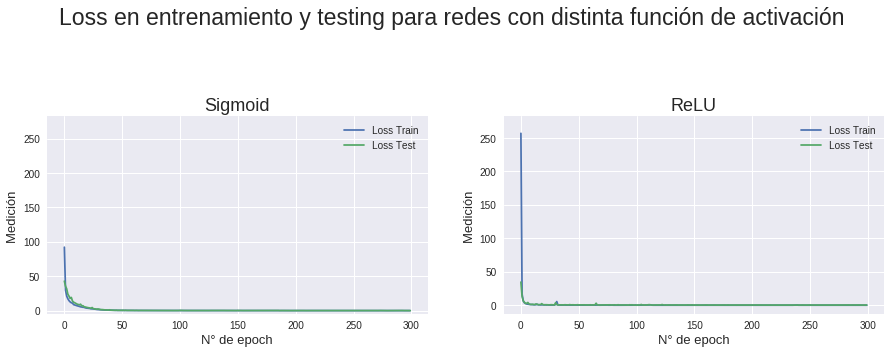

In [21]:
x = [max(loss_train_sigmoid),max(loss_test_sigmoid),max(loss_train_relu),max(loss_test_relu)]
valor_maximo = max(x)*1.1

plt.figure(1, figsize=(15,8))
plt.suptitle("Loss en entrenamiento y testing para redes con distinta función de activación\n \n", fontsize=23, y=1.07)
plt.subplot(221)
plt.title("Sigmoid",fontsize=18)
plt.plot(range(len(loss_train_sigmoid)), loss_train_sigmoid, label="Loss Train")
plt.plot(range(len(loss_test_sigmoid)), loss_test_sigmoid, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(222)
plt.title("ReLU",fontsize=18)
plt.plot(range(len(loss_train_relu)), loss_train_relu, label="Loss Train")
plt.plot(range(len(loss_test_relu)), loss_test_relu, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
            
plt.show()

La figura superior muestra la pérdida del entrenamiento y del testeo para dos redes con distintas funciones de activación. Tanto la red con función de activación sigmoid como la con ReLU converge al aumentar el número de epoch. En la siguiente imagen se hará un acercamiento de lo que sucede para ambas redes en los primeros epochs

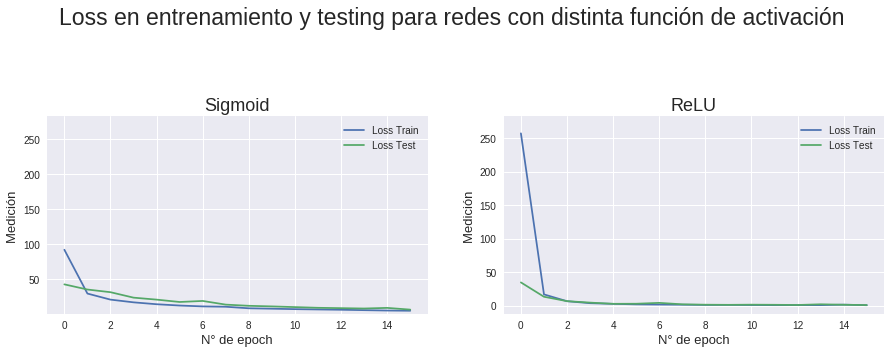

In [22]:
x = [max(loss_train_sigmoid),max(loss_test_sigmoid),max(loss_train_relu),max(loss_test_relu)]
valor_maximo = max(x)*1.1

max_epoch= 16

plt.figure(1, figsize=(15,8))
plt.suptitle("Loss en entrenamiento y testing para redes con distinta función de activación\n \n", fontsize=23, y=1.07)
plt.subplot(221)
plt.title("Sigmoid",fontsize=18)
plt.plot(range(0,max_epoch,1), loss_train_sigmoid[:max_epoch], label="Loss Train")
plt.plot(range(0,max_epoch,1), loss_test_sigmoid[:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(222)
plt.title("ReLU",fontsize=18)
plt.plot(range(max_epoch), loss_train_relu[:max_epoch], label="Loss Train")
plt.plot(range(max_epoch), loss_test_relu[:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
            
plt.show()

Para el caso ejecutado, la red con ReLU inicia con una mayor pérdida en el entrenamiento. Esta disminuye considerablemente en el primer epoch, y la pérdida obtenida en esa iteración es similar a la obtenida en la red con sigmoid. Los valores a los que convergen ambas redes son similares, aunque pareciera ser que la red con sigmoid alcanza levemente una pérdida menor a medida que transcurren los epochs. Se verá en detalle la última afirmación:

In [23]:
print("Entrenamiento")
print("Loss Train Sigmoid - Epoch 0: "+str(loss_train_sigmoid[0]))
print("Loss Train Sigmoid - Epoch 4: "+str(loss_train_sigmoid[4]))
print("Loss Train Sigmoid - Epoch 8: "+str(loss_train_sigmoid[8]))
print("Loss Train Sigmoid - Epoch 12: "+str(loss_train_sigmoid[12]))
print("Loss Train Sigmoid - Epoch 16: "+str(loss_train_sigmoid[16]))
print("-----------------------")
print("Loss Train ReLU - Epoch 0: "+str(loss_train_relu[0]))
print("Loss Train ReLU - Epoch 4: "+str(loss_train_relu[4]))
print("Loss Train ReLU - Epoch 8: "+str(loss_train_relu[8]))
print("Loss Train ReLU - Epoch 12: "+str(loss_train_relu[12]))
print("Loss Train ReLU - Epoch 16: "+str(loss_train_relu[16]))




Entrenamiento
Loss Train Sigmoid - Epoch 0: 92.28414176196095
Loss Train Sigmoid - Epoch 4: 14.62819454726569
Loss Train Sigmoid - Epoch 8: 8.831493731224443
Loss Train Sigmoid - Epoch 12: 6.745189863018751
Loss Train Sigmoid - Epoch 16: 5.012801016855366
-----------------------
Loss Train ReLU - Epoch 0: 257.0509567336231
Loss Train ReLU - Epoch 4: 2.6012545824050903
Loss Train ReLU - Epoch 8: 1.0053072900444977
Loss Train ReLU - Epoch 12: 0.7381395659849322
Loss Train ReLU - Epoch 16: 0.544257824291969


Los resultados anteriores permiten confirmar que en el entrenamiento, la red con sigmoid converge a un número menor comparada con la red que funciona con ReLU. 

> d) Repita b) y c) variando la tasa de aprendizaje (learning rate) en un rango sensible. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.

Se probarán las redes neuronales (utilizando sigmoid y ReLU) considerando en cada caso las siguientes tasas de aprendizaje: 
0.01; 0.05; 0.1; 0.15; 0.2; 0.25; 0.3; 0.35; 0.4; 0.45; 0.5; 0.55; 0.6; 0.65; 0.7; 0.75; 0.8; 0.85; 0.9;0.95; 0.99

In [0]:
learn_rate_array = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99]

## <font color='red'> ¡!¡!¡!¡!Repetir experimento para 300 epochs</font> 

In [0]:
#Redes con sigmoid


loss_sigmoid_array = []
for i in learn_rate_array:
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
  model.add(Activation('sigmoid'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear')) 
  sgd = SGD(lr=i)
  model.compile(optimizer=sgd,loss='mean_squared_error')
  hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
  loss_sigmoid_array.append(hist_sigmoid.history['loss'])
  loss_sigmoid_array.append(hist_sigmoid.history['val_loss'])
  

In [0]:
loss_relu_array = []
for i in learn_rate_array:
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear')) 
  sgd = SGD(lr=i)
  model.compile(optimizer=sgd,loss='mean_squared_error')
  hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
  loss_relu_array.append(hist_sigmoid.history['loss'])
  loss_relu_array.append(hist_sigmoid.history['val_loss'])

Al probar distintos learning rate en la red con sigmoid, se obtiene lo siguiente:

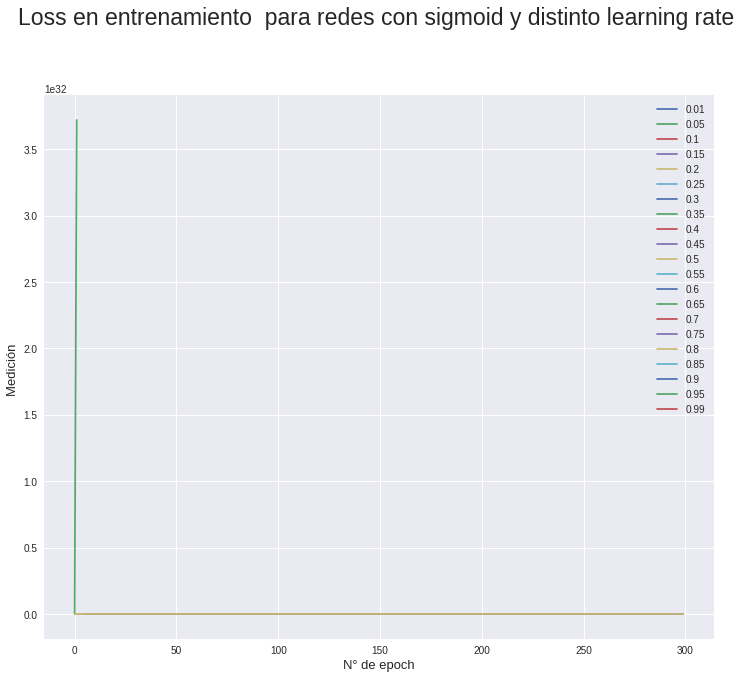

In [27]:
plt.figure(1, figsize=(12,10))

plt.subplot(111)
plt.title("Loss en entrenamiento  para redes con sigmoid y distinto learning rate \n", fontsize=23, y=1.07)
contador = 0
for i in range(0,len(loss_sigmoid_array),2):
  try:
    plt.plot(range(len(loss_sigmoid_array[i])), loss_sigmoid_array[i], label=str(round(learn_rate_array[contador],3)))
  except:
    pass
  contador+=1
  
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()

plt.show();

Los resultados son dificiles de visualizar, para la red con sigmoid y learning rate = 0.01 se obtiene lo siguiente

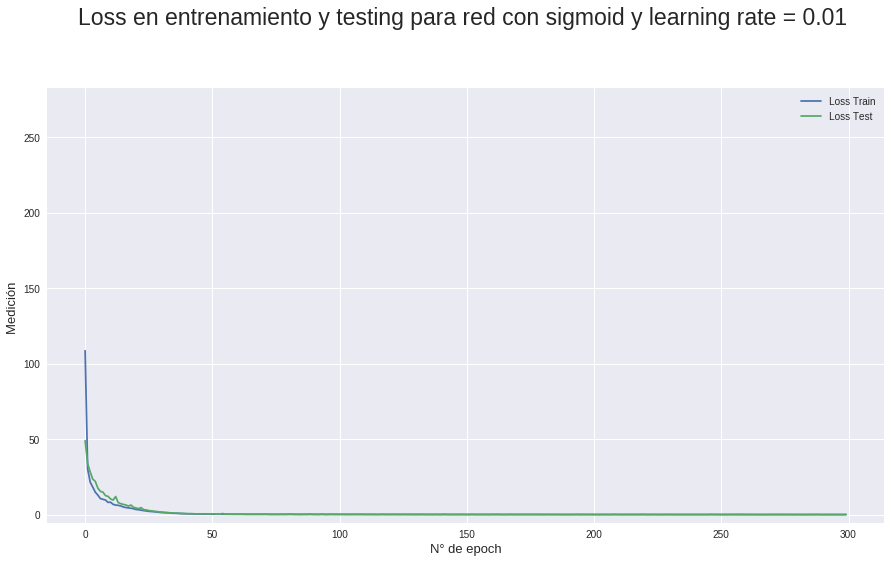

In [28]:
plt.figure(1, figsize=(15,8))
plt.title("Loss en entrenamiento y testing para red con sigmoid y learning rate = 0.01 \n", fontsize=23, y=1.07)
plt.plot(range(len(loss_sigmoid_array[0])), loss_sigmoid_array[0], label="Loss Train")
plt.plot(range(len(loss_sigmoid_array[1])), loss_sigmoid_array[1], label="Loss Test")

plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.show()

La red con sigmoid converge cuando el learning rate es = 0.01. Para los otros casos, la red diverge. Esto se puede verificar al revisar la matriz que se imprime a continuación. En ella, se muestran el loss obtenido para todos los learning rate probados. Aparecerán valores NaN e Inf cuando el learning rate sea distinto de 0.01 (en este caso)

In [29]:
from IPython.display import display

print("Red Sigmoid - Entrenamiento y Testeo - Distintos valores de learning rate:")
for i in range(0,20):
  display(loss_sigmoid_array[i])


Red Sigmoid - Entrenamiento y Testeo - Distintos valores de learning rate:


[108.65596911146018,
 30.220585516071573,
 21.62098366729817,
 18.25006883691672,
 14.953929823118024,
 13.007491028717766,
 10.698214195019967,
 10.234469698098215,
 9.761848918995316,
 8.203880377998452,
 8.287457989514031,
 6.875603902308482,
 6.38762115991839,
 6.232669152181821,
 5.827182359619946,
 5.148215415295321,
 4.776935774921427,
 4.572934519017907,
 4.3255638409415775,
 3.9702383836529815,
 3.4609526417815277,
 3.3564670318663907,
 3.0051952515554303,
 2.7669103809271136,
 2.4826973421907046,
 2.2730976295974448,
 2.161809380262068,
 2.0016903279639173,
 1.7973919973209853,
 1.654397555894776,
 1.4618622410580477,
 1.389053427842802,
 1.243584533637306,
 1.254303883672704,
 1.0296941463267897,
 0.9616912137864447,
 0.8853885696557078,
 0.8288263621934171,
 0.7431001727687967,
 0.681082571244806,
 0.6368563164192642,
 0.6044800781637509,
 0.5948759405468259,
 0.546078800132847,
 0.5007545012282822,
 0.46799690852379106,
 0.4619475083332263,
 0.4241144144440704,
 0.42048057

[49.012146071186216,
 33.81984743734044,
 28.332138647244673,
 23.612170955327553,
 22.09532895426112,
 17.633088449793537,
 15.499751751817117,
 14.961492305665505,
 12.697192469919761,
 12.158941768285796,
 10.451491828978531,
 9.72932728069035,
 12.072400446013203,
 8.05410913031871,
 7.328483649126188,
 6.8429845749862555,
 6.476199773352916,
 5.741806488337479,
 6.410111776487095,
 4.947644233703613,
 4.448310296366534,
 4.069500166600145,
 4.694592781892911,
 3.3569057982737625,
 3.1833383980698473,
 2.7817454094023217,
 2.547845737201961,
 2.3091626570919366,
 2.0656829556142253,
 1.9197783770523673,
 1.727035504626477,
 1.5876716459829976,
 1.449889966822046,
 1.2938218445289793,
 1.1652842609901128,
 1.0640298803960244,
 1.1412705760302506,
 0.9197078314353162,
 0.8274869515201239,
 0.7976277212458333,
 0.6995065690964226,
 0.6856421725017818,
 0.7104420338090011,
 0.5773579689461416,
 0.5869527412211801,
 0.572565591241431,
 0.47306523642202064,
 0.6234625174304632,
 0.485852

[5.706488525321778e+16,
 3.7202436007666335e+32,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 na

[1.916383747117293e+19,
 9.144242654066692e+34,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[3.852597282295944e+24,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[8.540603849996194e+27,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[2.261469475588145e+24,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[3.940246763197219e+27,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[37334.44845830671,
 371.0880638062168,
 214.68720209126738,
 192.05857643791742,
 172.393831972711,
 161.40351784638176,
 152.05150892111746,
 146.73680481118075,
 135.0515158459505,
 129.82971026337555,
 121.11441937851717,
 115.7134467454573,
 112.39491232215258,
 105.04771532043618,
 101.39527189511422,
 98.27309133886976,
 93.62868082051541,
 91.66050751416853,
 87.41577446366362,
 84.41946865071722,
 81.15495788453437,
 78.37702071761079,
 77.48205546275922,
 75.63430534503705,
 73.42176590368427,
 70.12542240474973,
 68.99926973207016,
 68.43796717460049,
 64.54966481191187,
 64.02612033934581,
 63.43889564071293,
 61.510678142859625,
 60.48000118285811,
 60.55768585205078,
 59.09314613543589,
 57.71638631694864,
 59.16277760125716,
 56.01840868222682,
 56.781760072330684,
 55.48842540328295,
 55.24425169408793,
 53.75654564306415,
 53.65884943939451,
 51.93045914582024,
 53.94863133694692,
 53.64276780302103,
 51.60439655837409,
 51.35939920672011,
 51.09243399989951,
 50.79572

[820425.2578201895,
 822201.222504383,
 821233.4444858822,
 819968.8343313623,
 818765.8329165,
 817404.253880298,
 816193.1332604116,
 814627.0519116019,
 813121.4114807609,
 812456.1659829448,
 811341.4569610836,
 810361.736862543,
 809656.6993139072,
 808816.6031465305,
 807961.67617918,
 807077.8822636642,
 806130.0439510796,
 805366.5701990804,
 804696.4301402174,
 803947.1551840474,
 803354.6482971672,
 802706.812206839,
 802053.9341300904,
 801404.4314599225,
 800743.7934743325,
 800228.2776071143,
 799662.5345353254,
 799341.6587096688,
 798806.3536386566,
 798190.296440545,
 797796.3763273945,
 797226.9631866695,
 796888.8340449296,
 796500.0591935285,
 796224.023003045,
 795818.8110293892,
 795265.849117249,
 795019.2626068837,
 794692.2339905265,
 794268.6833371139,
 794084.1307084692,
 793726.8274637057,
 793369.5572884628,
 793071.019567775,
 792916.3889217827,
 792750.4034837137,
 792370.9394723487,
 792213.6175412155,
 791911.0640119418,
 791649.7217440868,
 791297.42540

[3.287282824367686e+17,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[1.6254930976993066e+21,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 na

[5.494436350353289e+27,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[6.464254735882364e+31,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[1.8406158494877558e+28,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 na

[1.6575800433217402e+32,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 na

[3.323270633115892e+20,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[1.4575840828740011e+24,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 na

[1.9796777182415219e+28,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 na

[4.6262577536829846e+32,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 na

### Conclusión: La red con Sigmoid diverge para todos los learning rate probados, exceptuando un learning rate de 0.01

Junto a lo anterior, también se probó una red neuronal con red de activación ReLU para distintos learning rate. Los resultados fueron los siguientes:

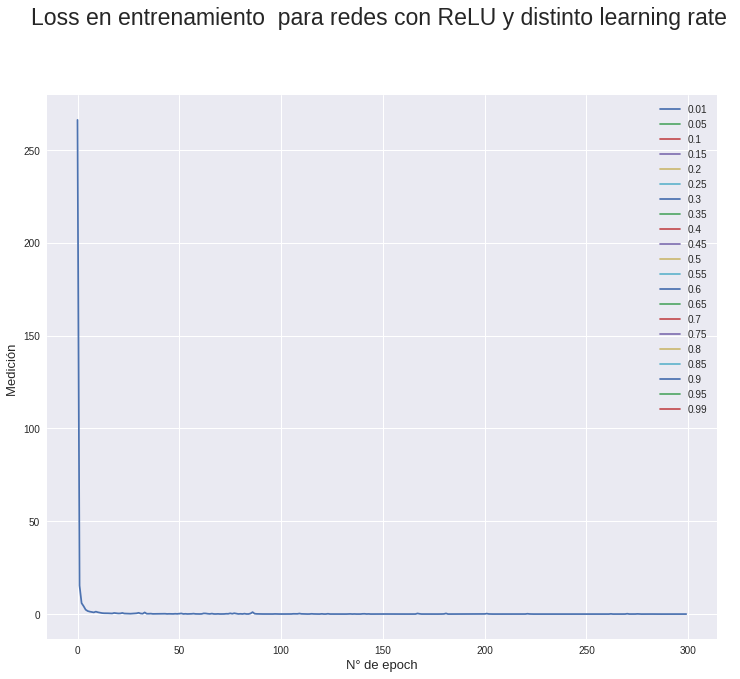

In [30]:
plt.figure(1, figsize=(12,10))

plt.subplot(111)
plt.title("Loss en entrenamiento  para redes con ReLU y distinto learning rate \n", fontsize=23, y=1.07)
contador=0
for i in range(0,len(loss_relu_array),2):
  try:
    plt.plot(range(len(loss_relu_array[i])), loss_relu_array[i], label=str(round(learn_rate_array[contador],3)))
  except:
    pass
  contador+=1

  
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()

plt.show();

En la imagen superior se observa que solo la red con un learning rate igual a 0.01 converge. A continuación se presenta la pérdida en el entranamiento y en el testo para esta red.

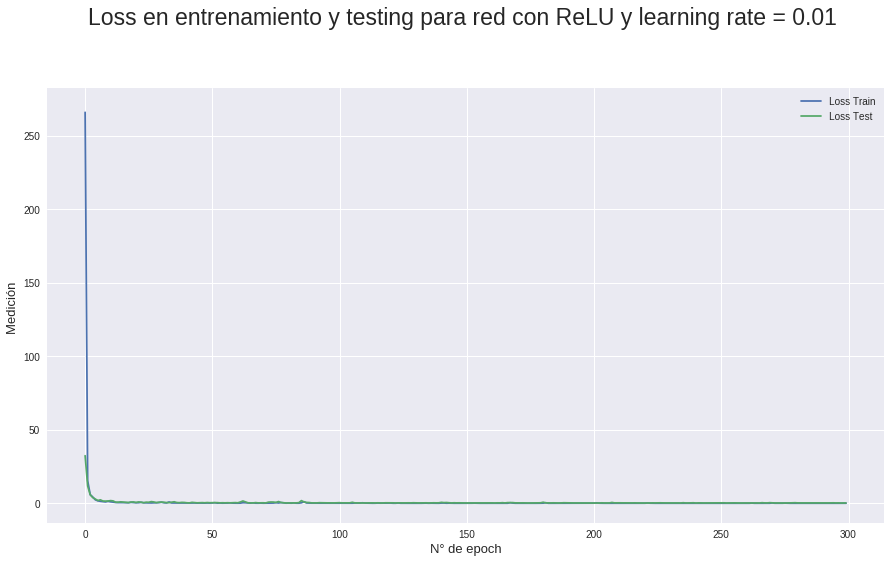

In [31]:
plt.figure(1, figsize=(15,8))
plt.title("Loss en entrenamiento y testing para red con ReLU y learning rate = 0.01 \n", fontsize=23, y=1.07)
plt.plot(range(len(loss_relu_array[0])), loss_relu_array[0], label="Loss Train")
plt.plot(range(len(loss_relu_array[1])), loss_relu_array[1], label="Loss Test")

plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.show()

Al igual que lo conversado en experimentos anteriores, esta red tiene una pérdida inicial bastante alta (en su primer epoch), la que disminuye casi en su totalidad en el epoch siguiente. 

A continuación, se presentan la pérdida obtenida en el entranamiento y en el testo para la red con ReLU para cada una de los learning rate mencionados. Solo para un learning rate = 0.01 la red converge, en los demás casos el arreglo contiene valores NaN e Inf lo que permite concluir que en esos casos la red diverge. 

In [32]:
print("Red ReLU - Entrenamiento y Testeo - Distintos valores de learning rate:")
for i in range(0,20):
  display(loss_relu_array[i])


Red ReLU - Entrenamiento y Testeo - Distintos valores de learning rate:


[266.1562809554128,
 15.339652319382237,
 5.9206075378961485,
 4.26244701747844,
 2.3697906830065483,
 1.6552229858640002,
 1.3389063230605114,
 1.1549225188496874,
 0.9189291991942161,
 1.3220100733095235,
 0.9906096511906244,
 0.750406313540124,
 0.5614181343357921,
 0.4740643189890718,
 0.4715760409989269,
 0.4453401443668909,
 0.3770520911210445,
 0.34708113657767664,
 0.6142727974851402,
 0.4744245969840279,
 0.35494446337694857,
 0.3797096448083037,
 0.6227173555966732,
 0.32890967926438064,
 0.2734673330683192,
 0.21156929995579582,
 0.21341157509972364,
 0.3066756377748575,
 0.42491739693449165,
 0.4394748284036692,
 0.6904350718910902,
 0.32933054129177786,
 0.22058355407224167,
 0.8887183148030555,
 0.2059768721421979,
 0.19526268317705722,
 0.2565770315935241,
 0.11653016653098658,
 0.1276661038673962,
 0.14158734793241545,
 0.1597476928325316,
 0.14312128883867592,
 0.1665005836449072,
 0.19988700407397464,
 0.0937415637410096,
 0.14496790627533654,
 0.10249164877434834,
 0

[32.38835411372147,
 11.771788379338783,
 5.771499141933411,
 3.878169538467888,
 2.8334428456824594,
 1.8731063735766673,
 2.327728246140668,
 1.4983776258671377,
 1.4527024406147755,
 1.5120118687472006,
 1.7984910574484998,
 1.592068299533814,
 0.7084068796766085,
 0.7168558080365338,
 0.9566327784005113,
 0.8012710037663227,
 0.7027974497145555,
 0.49229574086159233,
 0.825916875535109,
 0.8949188881033049,
 0.543927969425682,
 0.8983687350130457,
 0.71646098499223,
 0.3897429779758604,
 0.7236774796106684,
 0.667235865837007,
 1.1137485227246924,
 0.880135279002152,
 0.40846079728734774,
 0.7131069903298626,
 0.8134218686678278,
 0.6750296746182629,
 0.4415480496845846,
 0.41492574656103537,
 0.7437151726775282,
 1.0113570502423865,
 0.5005032802660634,
 0.4002039047676747,
 0.5921566793768425,
 0.5245691814760524,
 0.3106787894654462,
 0.23514358511590583,
 0.6118567205789521,
 0.4332816215950673,
 0.28428044774400907,
 0.3259887934669735,
 0.4181309483182712,
 0.3250710519514684

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

### ¿Qué es lo que ha sucedido hasta ahora?

Tanto para redes con Sigmoid y ReLU se ha observado la pérdida (*loss*) en cada una de ellas considerando distintos learning rate. Algunos casos dieron resultados satisfactorios, otro no lo suficientes y en los demás se presentaron divergencias haciendo que la red sea inutilizable. 

La pregunta que viene a la menta en estos momentos es: **¿Qué ha sucedido?**

Estudios han revelado la importancia de escoger un buen learning rate durante el entranamiento. Investigaciones (e incluso esta tarea) han demostrado que learning rates muy altos provocan que la pérdida aumente significativamente hasta diverger. Para nuestro caso, el algoritmo no es capaz de procesar números tan altos que se devuelve NaN o Inf según corresponda. 

Un buen learning rate (lo suficientemente pequeño pero no tanto para que la convergencia no sea extremadamente lenta) provocará que la red disminuya significativamente la pérdida durante los primeros epochs, a partir de este punto la red comienza a converger en un óptimo (local o global). Esto ocurrió en la pregunta 1.b y 1.c.

Valores intermedios implicará mantener un alto número de epochs para asegurar la convergencia. 



Esta imagen resume lo presentado:
<div align="center"><img src="http://cs231n.github.io/assets/nn3/learningrates.jpeg"> </img> </div>

**Fuente: ** http://cs231n.github.io/assets/nn3/learningrates.jpeg

### Repetición del experimento con learning rate más pequeños. 

Dada la información recopilada y a lo expuesto, se repetirá el experimento para ambas redes (con sigmoid y ReLU) para los siguientes learning rate: 0.01, 0.001, 0.0001, 0.00001 y 0.000001

In [0]:
learn_rate_array = [0.01,0.001,0.0001,0.00001,0.000001]

In [0]:
#Redes con sigmoid

loss_sigmoid_array = []
for i in learn_rate_array:
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
  model.add(Activation('sigmoid'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear')) 
  sgd = SGD(lr=i)
  model.compile(optimizer=sgd,loss='mean_squared_error')
  hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
  loss_sigmoid_array.append(hist_sigmoid.history['loss'])
  loss_sigmoid_array.append(hist_sigmoid.history['val_loss'])
  

In [0]:
#Redes con ReLU
loss_relu_array = []
for i in learn_rate_array:
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) 
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear')) 
  sgd = SGD(lr=i)
  model.compile(optimizer=sgd,loss='mean_squared_error')
  hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
  loss_relu_array.append(hist_sigmoid.history['loss'])
  loss_relu_array.append(hist_sigmoid.history['val_loss'])

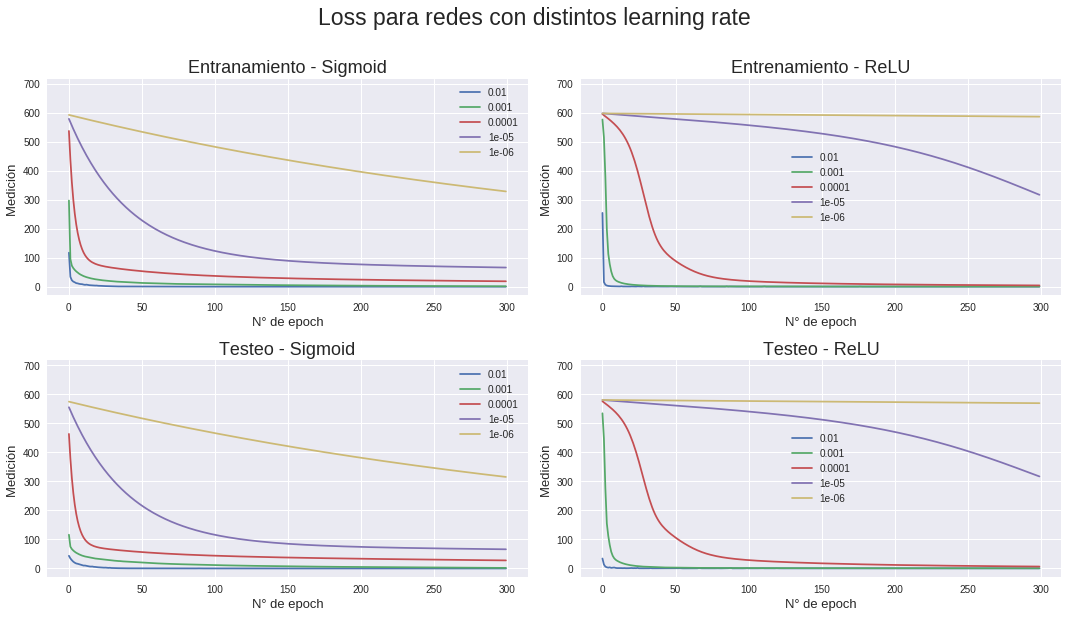

In [36]:
valor_maximo = max(max(loss_relu_array[0]),max(loss_relu_array[2]),max(loss_relu_array[4]),max(loss_relu_array[6]),max(loss_relu_array[8]))*1.2

max_epoch= len(loss_relu_array[0])

plt.figure(1, figsize=(15,8))
plt.suptitle("Loss para redes con distintos learning rate\n \n", fontsize=23, y=1.07)
plt.subplot(221)
plt.title("Entranamiento - Sigmoid",fontsize=18)
contador = 0
for i in range(0,len(loss_sigmoid_array),2):
  try:
    plt.plot(range(len(loss_sigmoid_array[i])), loss_sigmoid_array[i], label=str(round(learn_rate_array[contador],7)))
  except:
    pass
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(222)
plt.title("Entrenamiento - ReLU",fontsize=18)
contador = 0
for i in range(0,len(loss_relu_array),2):
  try:
    plt.plot(range(len(loss_relu_array[i])), loss_relu_array[i], label=str(round(learn_rate_array[contador],7)))
  except:
    pass
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(223)
plt.title("Testeo - Sigmoid",fontsize=18)
contador = 0
for i in range(1,len(loss_sigmoid_array),2):
  try:
    plt.plot(range(len(loss_sigmoid_array[i])), loss_sigmoid_array[i], label=str(round(learn_rate_array[contador],7)))
  except:
    pass
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(224)
plt.title("Testeo - ReLU",fontsize=18)
contador = 0
for i in range(1,len(loss_relu_array),2):
  try:
    plt.plot(range(len(loss_relu_array[i])), loss_relu_array[i], label=str(round(learn_rate_array[contador],7)))
  except:
    pass
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.tight_layout()
plt.show()

Los resultados anteriores comprueban lo expuesto. Un learning rate pequeño llevará a la convergencia, por lo tanto el *loss* disminuirá a medida que transcurren los epochs. Pero un learning rate muy pequeño ocasionará que los pesos cambien su valor solo una muy pequeña parte lo que implicará que el algoritmo converga muy lentamente. Además, learning rate muy pequeños ocasionan que la convergencia no ocurra en el mínimo global.  Por esa razón, el menor learning rate probado: 1e-06 fue con el que se obtuvo el peor resultado. 

Para todas las redes (tanto en *training* como *testing*), un learning rate igual a 0.01 pareció ser el adecuado ya que la convegencia sucede rápidamente. Además, con este learning rate se alcanza la menor pérdida posible de obtener dentro de lo probado. 

> e) Entrene los modelos considerados en b) y c) usando *progressive decay*. Compare y comente.


In [0]:
n_decay = 5
learn_decay_array = np.logspace(-6,0,n_decay)


El decaimiento estará dado por los siguientes valores: 1.00000000e-06, 3.16227766e-05, 1.00000000e-03, 3.16227766e-02 y 1.00000000e+00




In [38]:
#Red sigmoid con progressive decay

loss_sigmoid_decay_array = []
for i in learn_decay_array:
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) 
  model.add(Activation('sigmoid'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear')) 
  sgd = SGD(lr=0.01, decay=i) #Aqui se aplica distintos valores para el decaimiento
  model.compile(optimizer=sgd,loss='mean_squared_error')
  hist_sigmoid_decay = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
  loss_sigmoid_decay_array.append(hist_sigmoid_decay.history['loss'])
  loss_sigmoid_decay_array.append(hist_sigmoid_decay.history['val_loss'])
  
  

In [0]:
#Red ReLU con progressive decay

loss_relu_decay_array = []
for i in learn_decay_array:
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear')) 
  sgd = SGD(lr=0.01, decay=i) #Aqui se aplica distintos valores para el decaimiento
  model.compile(optimizer=sgd,loss='mean_squared_error')
  hist_relu_decay = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
  loss_relu_decay_array.append(hist_relu_decay.history['loss'])
  loss_relu_decay_array.append(hist_relu_decay.history['val_loss'])

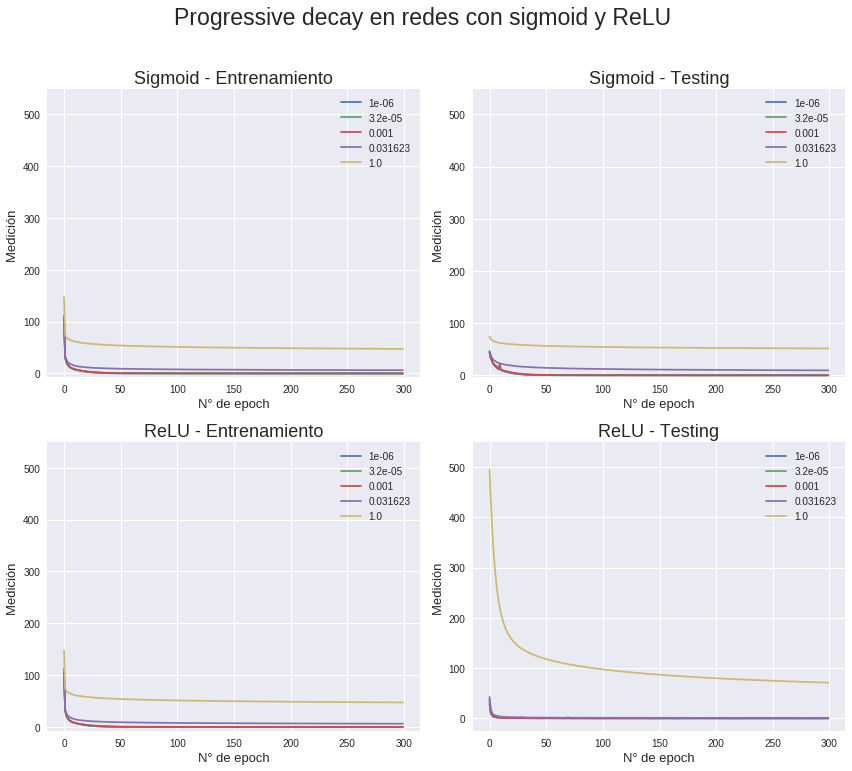

In [40]:
x = [max(loss_sigmoid_decay_array),max(loss_relu_decay_array)]
valor_maximo = max(x)[0]*1.0001

plt.figure(1, figsize=(12,10))
plt.suptitle("Progressive decay en redes con sigmoid y ReLU \n", fontsize=23, y=1.07)

plt.subplot(221)
plt.title("Sigmoid - Entrenamiento",fontsize=18)
contador = 0
for i in range(0,len(loss_sigmoid_decay_array),2):
  plt.plot(range(len(loss_sigmoid_decay_array[i])), loss_sigmoid_decay_array[i], label=str(round(learn_decay_array[contador],6)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(222)
plt.title("Sigmoid - Testing",fontsize=18)
contador = 0
for i in range(1,len(loss_sigmoid_decay_array),2):
  plt.plot(range(len(loss_sigmoid_decay_array[i])), loss_sigmoid_decay_array[i], label=str(round(learn_decay_array[contador],6)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()


plt.subplot(223)
plt.title("ReLU - Entrenamiento",fontsize=18)
contador = 0
for i in range(0,len(loss_relu_decay_array),2):
  plt.plot(range(len(loss_relu_decay_array[i])), loss_sigmoid_decay_array[i], label=str(round(learn_decay_array[contador],6)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(224)
plt.title("ReLU - Testing",fontsize=18)
contador = 0
for i in range(1,len(loss_relu_decay_array),2):
  plt.plot(range(len(loss_relu_decay_array[i])), loss_relu_decay_array[i], label=str(round(learn_decay_array[contador],6)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()


plt.tight_layout()
plt.show()

Se hará un acercamiento a lo que sucede en las primeras epochs para poder visualizar de mejor manera las diferencias encontradas.



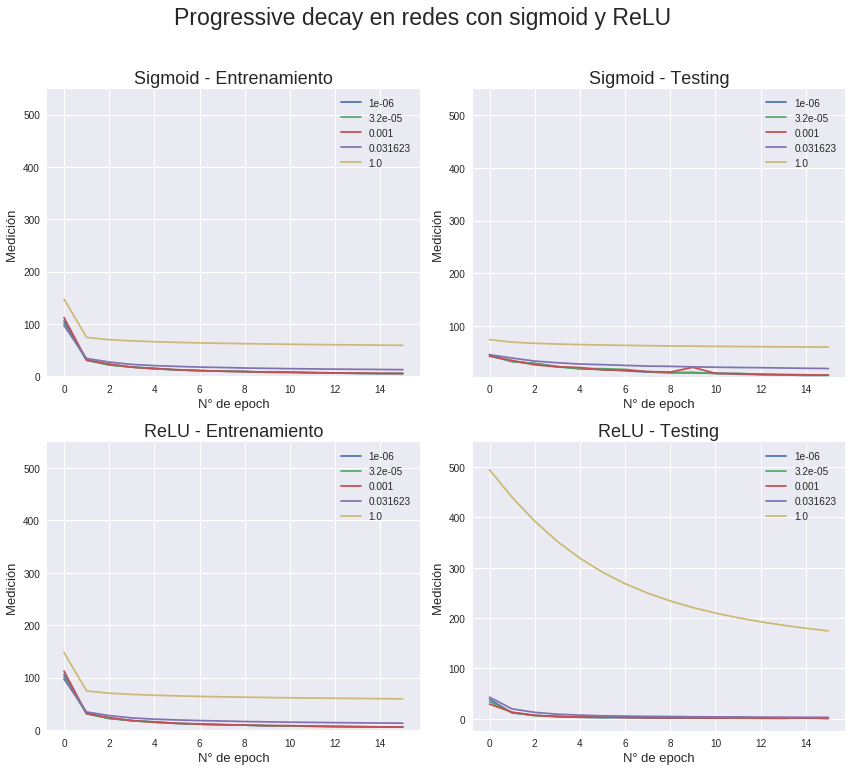

In [41]:
x = [max(loss_sigmoid_decay_array),max(loss_relu_decay_array)]
valor_maximo = max(x)[0]*1.0001
epoch_maximo = 16


plt.figure(1, figsize=(12,10))
plt.suptitle("Progressive decay en redes con sigmoid y ReLU \n", fontsize=23, y=1.07)

plt.subplot(221)
plt.title("Sigmoid - Entrenamiento",fontsize=18)
contador = 0
for i in range(0,len(loss_sigmoid_decay_array),2):
  plt.plot(range(epoch_maximo), loss_sigmoid_decay_array[i][0:epoch_maximo], label=str(round(learn_decay_array[contador],6)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(222)
plt.title("Sigmoid - Testing",fontsize=18)
contador = 0
for i in range(1,len(loss_sigmoid_decay_array),2):
  plt.plot(range(epoch_maximo), loss_sigmoid_decay_array[i][0:epoch_maximo], label=str(round(learn_decay_array[contador],6)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()


plt.subplot(223)
plt.title("ReLU - Entrenamiento",fontsize=18)
contador = 0
for i in range(0,len(loss_relu_decay_array),2):
  plt.plot(range(epoch_maximo), loss_sigmoid_decay_array[i][0:epoch_maximo], label=str(round(learn_decay_array[contador],6)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(224)
plt.title("ReLU - Testing",fontsize=18)
contador = 0
for i in range(1,len(loss_relu_decay_array),2):
  plt.plot(range(epoch_maximo), loss_relu_decay_array[i][0:epoch_maximo], label=str(round(learn_decay_array[contador],6)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()


plt.tight_layout()
plt.show()

La forma matemática del decaimiento basado en el tiempo está dada por *lr = lr0/(1+kt)* donde *lr* y *k* son hiperparámetros mientras que *t* corresponde al número de iteración. 
Si se observa el código de Keras, el optimizador SGD toma el decaimiento *decay* y los argumentos *lr* para actualizar el *learning rate* por un factor decreciente en cada epoch, dado por: 

<div align="center"> lr *= (1. / (1. + self.decay x self.iterations))</div>


Sorprendentemente para cada uno de los valores de *decay* utilizados se obtienen resultados similares, exceptuando cuando el decay es igual igual a 1.0


 <font color='red'> ¡!¡!¡!¡!Completar análisis</font> 

> f) Entrene los modelos considerados en b) y c) utilizando SGD en mini-*batches*. Experimente con diferentes tamaños del *batch*. Comente.

In [42]:
n_batches = 5
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))
print("Los tamaños de batches serán los siguientes: ")
for i in batch_sizes:
  print(str(int(i)),end = " ")

Los tamaños de batches serán los siguientes: 
1 96 190 284 379 

Se medirán los tiempos del algoritmo

In [0]:
 import time


In [0]:
#Red sigmoid con distintos tamannos de batch

loss_sigmoid_batch_array = []
tiempos_sigmoid = []
for i in batch_sizes:
  start_time = time.time()
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) 
  model.add(Activation('sigmoid'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear')) 
  sgd = SGD(lr=0.01) 
  model.compile(optimizer=sgd,loss='mean_squared_error')
  hist_sigmoid_batch = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test), batch_size=int(i))
  loss_sigmoid_batch_array.append(hist_sigmoid_batch.history['loss'])
  loss_sigmoid_batch_array.append(hist_sigmoid_batch.history['val_loss'])
  tiempos_sigmoid.append(time.time() - start_time)  

In [0]:
#Red ReLU con distintos tamannos de batch
loss_relu_batch_array = []
tiempos_relu = []
for i in batch_sizes:
  start_time = time.time()
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
  model.add(Activation('relu'))
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear')) 
  sgd = SGD(lr=0.01) #Aqui se aplica distintos valores para el decaimiento
  model.compile(optimizer=sgd,loss='mean_squared_error')
  hist_relu_batch = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
  loss_relu_batch_array.append(hist_relu_batch.history['loss'])
  loss_relu_batch_array.append(hist_relu_batch.history['val_loss'])
  tiempos_relu.append(time.time() - start_time)  

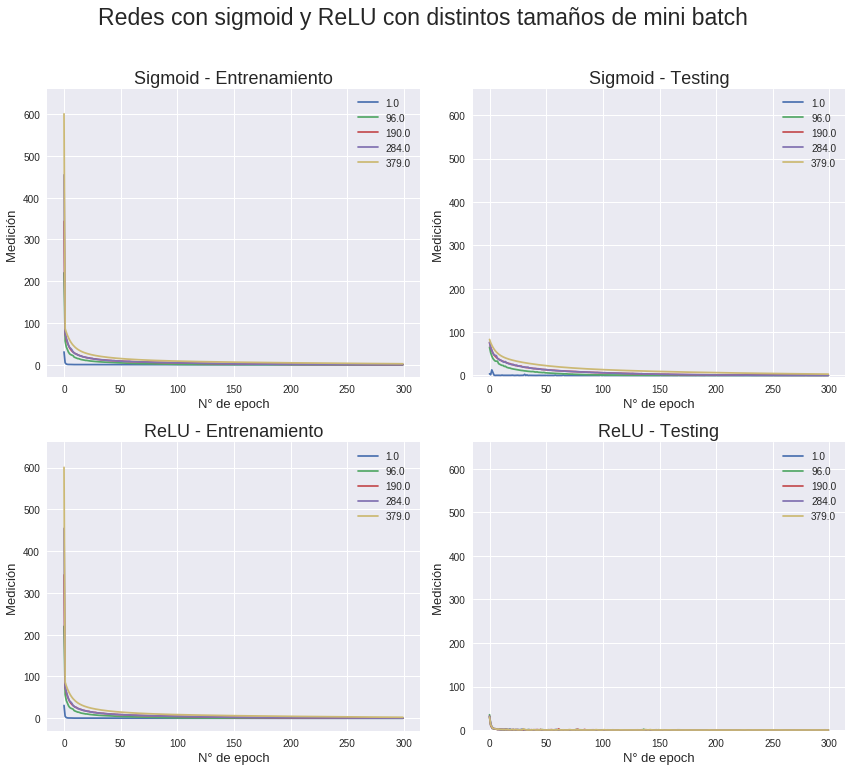

In [46]:
x = [max(loss_sigmoid_batch_array),max(loss_relu_batch_array)]
valor_maximo = max(x)[0]*1.1

plt.figure(1, figsize=(12,10))
plt.suptitle("Redes con sigmoid y ReLU con distintos tamaños de mini batch \n", fontsize=23, y=1.07)

plt.subplot(221)
plt.title("Sigmoid - Entrenamiento",fontsize=18)
contador = 0
for i in range(0,len(loss_sigmoid_batch_array),2):
  plt.plot(range(len(loss_sigmoid_batch_array[i])), loss_sigmoid_batch_array[i], label=str(round(batch_sizes[contador],2)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(222)
plt.title("Sigmoid - Testing",fontsize=18)
contador = 0
for i in range(1,len(loss_sigmoid_batch_array),2):
  plt.plot(range(len(loss_sigmoid_batch_array[i])), loss_sigmoid_batch_array[i], label=str(round(batch_sizes[contador],2)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()


plt.subplot(223)
plt.title("ReLU - Entrenamiento",fontsize=18)
contador = 0
for i in range(0,len(loss_relu_batch_array),2):
  plt.plot(range(len(loss_relu_batch_array[i])), loss_sigmoid_batch_array[i], label=str(round(batch_sizes[contador],2)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(224)
plt.title("ReLU - Testing",fontsize=18)
contador = 0
for i in range(1,len(loss_relu_batch_array),2):
  plt.plot(range(len(loss_relu_batch_array[i])), loss_relu_batch_array[i], label=str(round(batch_sizes[contador],2)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()


plt.tight_layout()
plt.show()

<font color='red'> ¡!¡!¡!¡!Mejorar análisis</font> 

Los tiempos de entrenamiento y validación fueron medidos para cada tamaño de batch. La siguiente figura muestra los resultados obtenidos:

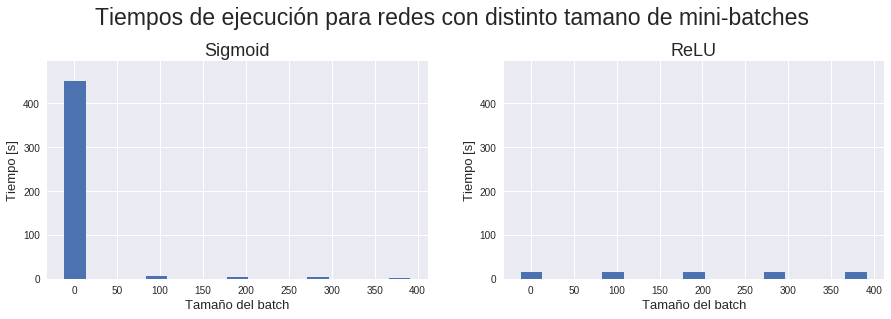

In [47]:
valor_maximo = max(max(tiempos_sigmoid),max(tiempos_relu))*1.1
plt.figure(1, figsize=(15,4))
plt.suptitle("Tiempos de ejecución para redes con distinto tamano de mini-batches\n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Sigmoid",fontsize=18)
plt.bar(batch_sizes ,tiempos_sigmoid,width = 25, align="center")
plt.ylabel('Tiempo [s]', fontsize=13)
plt.xlabel('Tamaño del batch', fontsize=13)
plt.ylim(ymax=valor_maximo)


plt.subplot(122)
plt.title("ReLU",fontsize=18)
plt.bar(batch_sizes ,tiempos_relu, width = 25, align="center")
plt.ylabel('Tiempo [s]', fontsize=13)
plt.xlabel('Tamaño del batch', fontsize=13)
plt.ylim(ymax=valor_maximo)


plt.show();

En el caso de sigmoid con tamaño batch = 1, el tiempo se dispara. Los experimentos con la misma función de activación pero con tamaño de mini batches distinto de 1 arrojaron buenos resultados en relación al tiempo de ejecución. Ellos, incluso llegan a ser levemente menores a los obtenidos por una red neuronal con función de activación ReLU.

> g) Entrene los modelos obtenidos en b) y c) utilizando estrategias modernas para adaptar la tasa de aprendizaje. Compare los desempeños de adagrad, adadelta, RMSprop y adam. ¿Se observa en algún caso un mejor resultado final? ¿Se observa en algún caso una mayor velocidad de convergencia sobre el dataset de entrenamiento? ¿Sobre el dataset de pruebas?


Antes de comenzar el experimento, es importante describir de manera breve cada una de las técnicas señaladas:
>* **Adagrad:** Esta técnica está basada en la idea de utilizar tasas de aprendizaje diferentes para cada peso/parámetro. Su motivación nace de la data dispersa (EJ: textos). Adagrad normaliza la "geometría" de la función objetivo. Con Adagrad cada parámetro tiene su propia dinámica: a gradientes pequeños corresponderán incrementos grandes y a
gradientes grandes corresponden incrementos pequeños. La idea de normalizar la geometría de los gradientes resulta muy útil en el contexto de redes neuronales porque, en
general, las capas pueden tener gradientes en escalas muy diferentes. Sin embargo, Adagrad está pensado para una función convexa. En particular, la tasa de aprendizaje decrece monótonamente lo que hace que el algoritmo tienda a detenerse prematuramente. 

>* **Adadelta:** Adadelta es una extensión de Adagrad que busca reducir agresivamente, monotonicamente decreciente el learning rate. Esto en vez de acumular todos los gradientes cuadrados anteriores. Adadelta restringe la ventana de los gradientes acumulados a un tamaño de ventana fijo: *w*. Con Adadelta, no se necesita incluso definir un learning rate por defecto, ya que ha sido eliminado de la regla de actualización (*update*). 

>* **RMSprop:** RMSprop y Adadelta se han desarrollado de forma independiente en la misma época, debido a la necesidad de resolver las razas de aprendizaje de Adagrad. RMSprop divide la tasa de aprendizaje por un promedio exponencialmente decreciente de gradientes cuadrados. Se sugiere que γ se establezca en 0.9, mientras que un buen valor predeterminado para la tasa de aprendizaje η es 0.001.

>* **Adam:** *Adaptive Moment Estimation (Adam)* es otro método que computa un *learning rate* adaptativo para cada parámetro. En adición de acumular los gradientes cuadrados pasados (como Adadelta y RMSprop), Adam también guarda un elemento *mt* similar al momentum. Mientras que el *momentum* se puede ver como una pelota corriendo por una pendiente, Adam se comporta como una bola pesada con fricción, que por lo tanto prefiere mínimos planos en la superficie de error. Este algoritmo intenta corregir el sesgo de las estimaciones del primer y segundo momento del gradiente inherentes a RMS Prop (con momentum). 


In [0]:
num_epochs = 50

In [0]:

# Adegrad - Sigmoid
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear')) 
moptimizer = Adagrad(lr=0.01)
model.compile(optimizer=moptimizer,loss='mean_squared_error', metrics=['accuracy'])
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=num_epochs, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_sigmoid_adegrad = hist_sigmoid.history['loss']
accuracy_train_sigmoid_adegrad = hist_sigmoid.history['acc']
loss_test_sigmoid_adegrad = hist_sigmoid.history['val_loss']
accuracy_test_sigmoid_adegrad = hist_sigmoid.history['val_acc']

In [0]:
# Adegrad - ReLU
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear')) 
moptimizer = Adagrad(lr=0.01)
model.compile(optimizer=moptimizer,loss='mean_squared_error', metrics=['accuracy'])
hist_relu = model.fit(X_train_scaled, y_train, epochs=num_epochs, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_relu_adegrad = hist_relu.history['loss']
accuracy_train_relu_adegrad = hist_relu.history['acc']
loss_test_relu_adegrad = hist_relu.history['val_loss']
accuracy_test_relu_adegrad = hist_relu.history['val_acc']

In [0]:

# Adadelta - Sigmoid
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
moptimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=moptimizer,loss='mean_squared_error', metrics=['accuracy'])
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=num_epochs, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_sigmoid_adadelta = hist_sigmoid.history['loss']
accuracy_train_sigmoid_adadelta = hist_sigmoid.history['acc']
loss_test_sigmoid_adadelta = hist_sigmoid.history['val_loss']
accuracy_test_sigmoid_adadelta = hist_sigmoid.history['val_acc']

In [0]:

# Adadelta - ReLU
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
moptimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=moptimizer,loss='mean_squared_error', metrics=['accuracy'])
hist_relu = model.fit(X_train_scaled, y_train, epochs=num_epochs, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_relu_adadelta = hist_relu.history['loss']
accuracy_train_relu_adadelta = hist_relu.history['acc']
loss_test_relu_adadelta = hist_relu.history['val_loss']
accuracy_test_relu_adadelta = hist_relu.history['val_acc']

In [0]:

# RMSprop - Sigmoid
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
moptimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=moptimizer,loss='mean_squared_error', metrics=['accuracy'])
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=num_epochs, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_sigmoid_rmsprop = hist_sigmoid.history['loss']
accuracy_train_sigmoid_rmsprop = hist_sigmoid.history['acc']
loss_test_sigmoid_rmsprop = hist_sigmoid.history['val_loss']
accuracy_test_sigmoid_rmsprop = hist_sigmoid.history['val_acc']

In [0]:

# RMSprop - ReLU
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
moptimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=moptimizer,loss='mean_squared_error', metrics=['accuracy'])
hist_relu = model.fit(X_train_scaled, y_train, epochs=num_epochs, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_relu_rmsprop = hist_relu.history['loss']
accuracy_train_relu_rmsprop = hist_relu.history['acc']
loss_test_relu_rmsprop = hist_relu.history['val_loss']
accuracy_test_relu_rmsprop = hist_relu.history['val_acc']

In [0]:

# Sigmoid - Adam
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
moptimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=moptimizer,loss='mean_squared_error', metrics=['accuracy'])
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=num_epochs, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_sigmoid_adam = hist_sigmoid.history['loss']
accuracy_train_sigmoid_adam = hist_sigmoid.history['acc']
loss_test_sigmoid_adam = hist_sigmoid.history['val_loss']
accuracy_test_sigmoid_adam = hist_sigmoid.history['val_acc']

In [0]:

# ReLU - Adam
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
moptimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=moptimizer,loss='mean_squared_error', metrics=['accuracy'])
hist_relu = model.fit(X_train_scaled, y_train, epochs=num_epochs, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_relu_adam = hist_relu.history['loss']
accuracy_train_relu_adam = hist_relu.history['acc']
loss_test_relu_adam = hist_relu.history['val_loss']
accuracy_test_relu_adam = hist_relu.history['val_acc']

Los resultados fueron los siguientes:

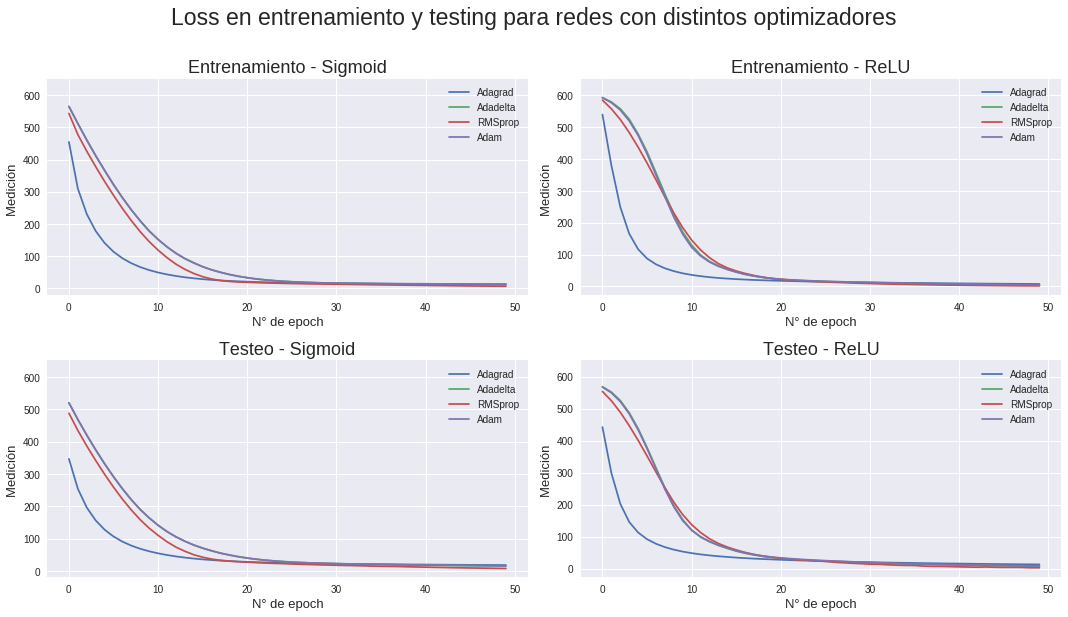

In [57]:
x = [max(loss_train_sigmoid_adegrad),max(loss_train_sigmoid_adadelta),max(loss_train_sigmoid_rmsprop),
     max(loss_train_sigmoid_adam),max(loss_train_relu_adegrad),max(loss_train_relu_adadelta),max(loss_train_relu_rmsprop),
     max(loss_train_relu_adam)]
valor_maximo = max(x)*1.1

plt.figure(1, figsize=(15,8))
plt.suptitle("Loss en entrenamiento y testing para redes con distintos optimizadores\n \n", fontsize=23, y=1.07)
plt.subplot(221)
plt.title("Entrenamiento - Sigmoid",fontsize=18)
plt.plot(range(len(loss_train_sigmoid_adegrad)), loss_train_sigmoid_adegrad, label="Adagrad")
plt.plot(range(len(loss_train_sigmoid_adadelta)), loss_train_sigmoid_adadelta, label="Adadelta")
plt.plot(range(len(loss_train_sigmoid_rmsprop)), loss_train_sigmoid_rmsprop, label="RMSprop")
plt.plot(range(len(loss_train_sigmoid_adam)), loss_train_sigmoid_adam, label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(222)
plt.title("Entrenamiento - ReLU",fontsize=18)
plt.plot(range(len(loss_train_relu_adegrad)), loss_train_relu_adegrad, label="Adagrad")
plt.plot(range(len(loss_train_relu_adadelta)), loss_train_relu_adadelta, label="Adadelta")
plt.plot(range(len(loss_train_relu_rmsprop)), loss_train_relu_rmsprop, label="RMSprop")
plt.plot(range(len(loss_train_relu_adam)), loss_train_relu_adam, label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(223)
plt.title("Testeo - Sigmoid",fontsize=18)
plt.plot(range(len(loss_test_sigmoid_adegrad)), loss_test_sigmoid_adegrad, label="Adagrad")
plt.plot(range(len(loss_test_sigmoid_adadelta)), loss_test_sigmoid_adadelta, label="Adadelta")
plt.plot(range(len(loss_test_sigmoid_rmsprop)), loss_test_sigmoid_rmsprop, label="RMSprop")
plt.plot(range(len(loss_test_sigmoid_adam)), loss_test_sigmoid_adam, label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(224)
plt.title("Testeo - ReLU",fontsize=18)
plt.plot(range(len(loss_test_relu_adegrad)), loss_test_relu_adegrad, label="Adagrad")
plt.plot(range(len(loss_test_relu_adadelta)), loss_test_relu_adadelta, label="Adadelta")
plt.plot(range(len(loss_test_relu_rmsprop)), loss_test_relu_rmsprop, label="RMSprop")
plt.plot(range(len(loss_test_relu_adam)), loss_test_relu_adam, label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()            

plt.tight_layout()
plt.show()

Se hará un acercamiento en los gráficos anteriores para poder visualizar con detalle lo que sucede en los primeros epochs

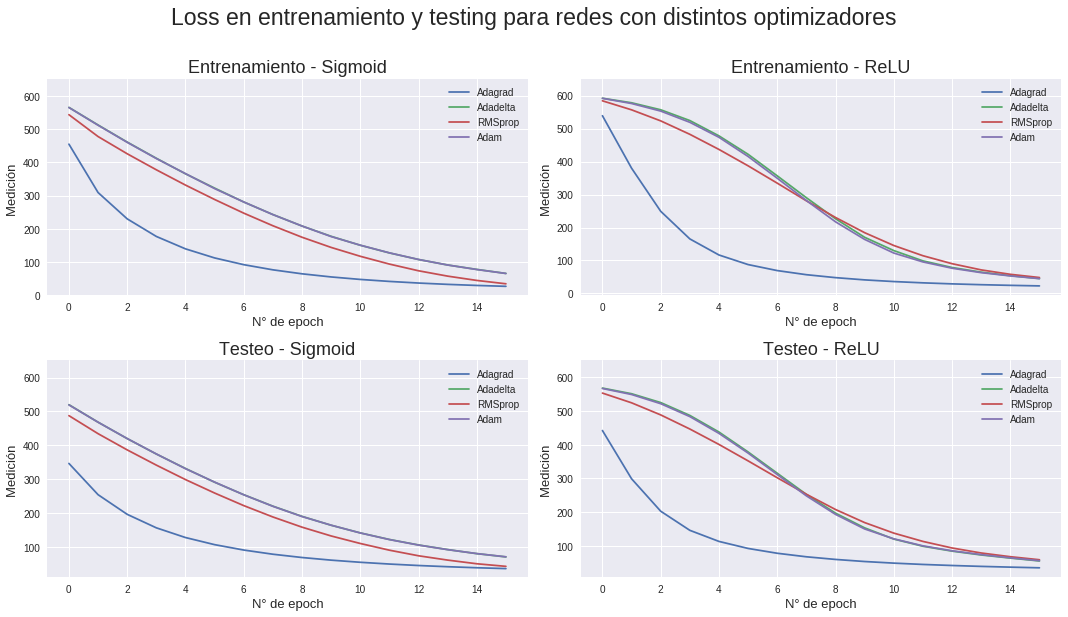

In [58]:
x = [max(loss_train_sigmoid_adegrad),max(loss_train_sigmoid_adadelta),max(loss_train_sigmoid_rmsprop),
     max(loss_train_sigmoid_adam),max(loss_train_relu_adegrad),max(loss_train_relu_adadelta),max(loss_train_relu_rmsprop),
     max(loss_train_relu_adam)]
valor_maximo = max(x)*1.1
epoch_max = 16

plt.figure(1, figsize=(15,8))
plt.suptitle("Loss en entrenamiento y testing para redes con distintos optimizadores\n \n", fontsize=23, y=1.07)
plt.subplot(221)
plt.title("Entrenamiento - Sigmoid",fontsize=18)
plt.plot(range(epoch_max), loss_train_sigmoid_adegrad[0:epoch_max], label="Adagrad")
plt.plot(range(epoch_max), loss_train_sigmoid_adadelta[0:epoch_max], label="Adadelta")
plt.plot(range(epoch_max), loss_train_sigmoid_rmsprop[0:epoch_max], label="RMSprop")
plt.plot(range(epoch_max), loss_train_sigmoid_adam[0:epoch_max], label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(222)
plt.title("Entrenamiento - ReLU",fontsize=18)
plt.plot(range(epoch_max), loss_train_relu_adegrad[0:epoch_max], label="Adagrad")
plt.plot(range(epoch_max), loss_train_relu_adadelta[0:epoch_max], label="Adadelta")
plt.plot(range(epoch_max), loss_train_relu_rmsprop[0:epoch_max], label="RMSprop")
plt.plot(range(epoch_max), loss_train_relu_adam[0:epoch_max], label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(223)
plt.title("Testeo - Sigmoid",fontsize=18)
plt.plot(range(epoch_max), loss_test_sigmoid_adegrad[0:epoch_max], label="Adagrad")
plt.plot(range(epoch_max), loss_test_sigmoid_adadelta[0:epoch_max], label="Adadelta")
plt.plot(range(epoch_max), loss_test_sigmoid_rmsprop[0:epoch_max], label="RMSprop")
plt.plot(range(epoch_max), loss_test_sigmoid_adam[0:epoch_max], label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(224)
plt.title("Testeo - ReLU",fontsize=18)
plt.plot(range(epoch_max), loss_test_relu_adegrad[0:epoch_max], label="Adagrad")
plt.plot(range(epoch_max), loss_test_relu_adadelta[0:epoch_max], label="Adadelta")
plt.plot(range(epoch_max), loss_test_relu_rmsprop[0:epoch_max], label="RMSprop")
plt.plot(range(epoch_max), loss_test_relu_adam[0:epoch_max], label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()            

plt.tight_layout()
plt.show()




En todos los casos anteriores, es con Adegrad con el que se obtiene mejores resultados. La pérdida converge más rápido y a un menor valor. ¿Qué sucede con el *accuracy* para todas las técnicas probadas?


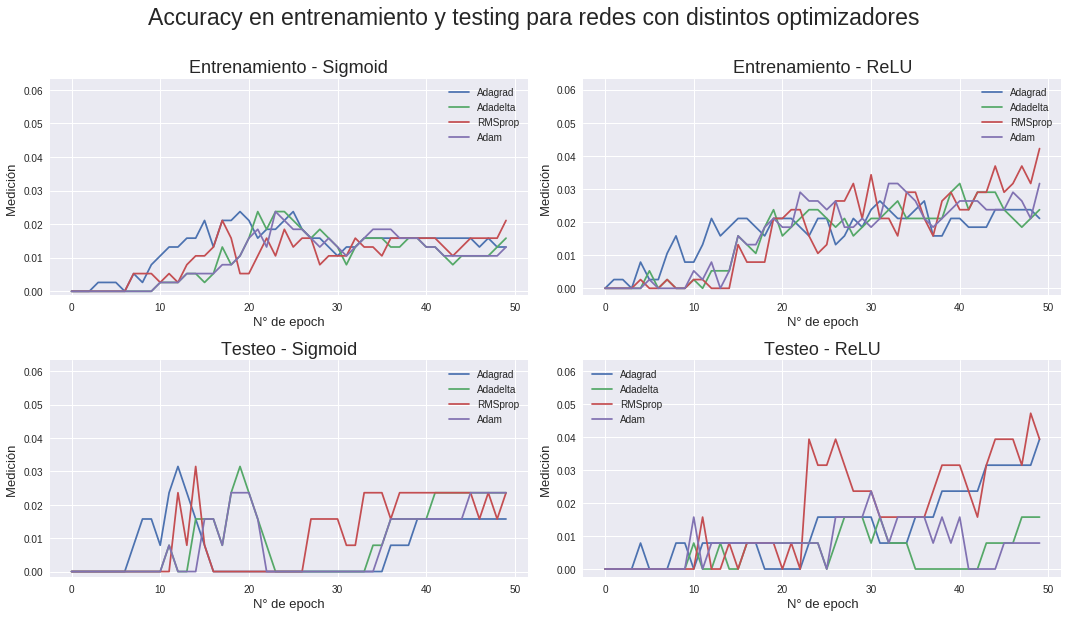

In [59]:
x = [max(accuracy_train_sigmoid_adegrad),max(accuracy_train_sigmoid_adadelta),max(accuracy_train_sigmoid_rmsprop),
     max(accuracy_train_sigmoid_adam),max(accuracy_train_relu_adegrad),max(accuracy_train_relu_adadelta),max(accuracy_train_relu_rmsprop),
     max(accuracy_train_relu_adam)]
#x = 1.0
valor_maximo = max(x)*1.5
epoch_max = len(accuracy_train_sigmoid_adegrad)

plt.figure(1, figsize=(15,8))
plt.suptitle("Accuracy en entrenamiento y testing para redes con distintos optimizadores\n \n", fontsize=23, y=1.07)
plt.subplot(221)
plt.title("Entrenamiento - Sigmoid",fontsize=18)
plt.plot(range(epoch_max), accuracy_train_sigmoid_adegrad[0:epoch_max], label="Adagrad")
plt.plot(range(epoch_max), accuracy_train_sigmoid_adadelta[0:epoch_max], label="Adadelta")
plt.plot(range(epoch_max), accuracy_train_sigmoid_rmsprop[0:epoch_max], label="RMSprop")
plt.plot(range(epoch_max), accuracy_train_sigmoid_adam[0:epoch_max], label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(222)
plt.title("Entrenamiento - ReLU",fontsize=18)
plt.plot(range(epoch_max), accuracy_train_relu_adegrad[0:epoch_max], label="Adagrad")
plt.plot(range(epoch_max), accuracy_train_relu_adadelta[0:epoch_max], label="Adadelta")
plt.plot(range(epoch_max), accuracy_train_relu_rmsprop[0:epoch_max], label="RMSprop")
plt.plot(range(epoch_max), accuracy_train_relu_adam[0:epoch_max], label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(223)
plt.title("Testeo - Sigmoid",fontsize=18)
plt.plot(range(epoch_max), accuracy_test_sigmoid_adegrad[0:epoch_max], label="Adagrad")
plt.plot(range(epoch_max), accuracy_test_sigmoid_adadelta[0:epoch_max], label="Adadelta")
plt.plot(range(epoch_max), accuracy_test_sigmoid_rmsprop[0:epoch_max], label="RMSprop")
plt.plot(range(epoch_max), accuracy_test_sigmoid_adam[0:epoch_max], label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(224)
plt.title("Testeo - ReLU",fontsize=18)
plt.plot(range(epoch_max), accuracy_test_relu_adegrad[0:epoch_max], label="Adagrad")
plt.plot(range(epoch_max), accuracy_test_relu_adadelta[0:epoch_max], label="Adadelta")
plt.plot(range(epoch_max), accuracy_test_relu_rmsprop[0:epoch_max], label="RMSprop")
plt.plot(range(epoch_max), accuracy_test_relu_adam[0:epoch_max], label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()            

plt.tight_layout()
plt.show()

Si se hace un acercamiento a lo que sucede en los primeros epochs:

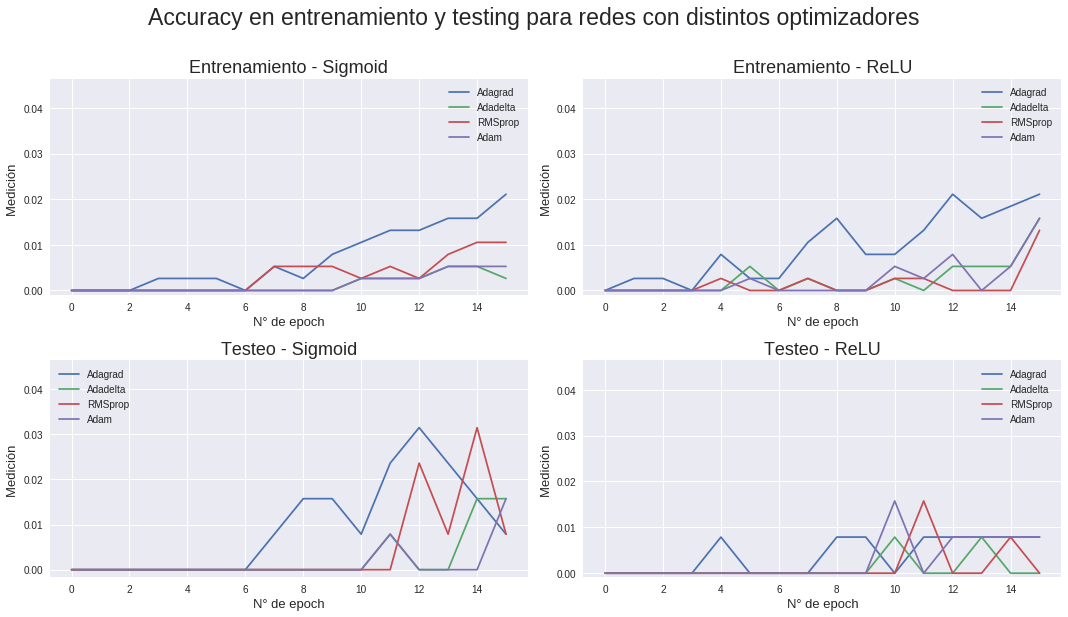

In [60]:
x = [max(accuracy_train_sigmoid_adegrad),max(accuracy_train_sigmoid_adadelta),max(accuracy_train_sigmoid_rmsprop),
     max(accuracy_train_sigmoid_adam),max(accuracy_train_relu_adegrad),max(accuracy_train_relu_adadelta),max(accuracy_train_relu_rmsprop),
     max(accuracy_train_relu_adam)]
#x = 1.0
valor_maximo = max(x)*1.1
epoch_max = 16

plt.figure(1, figsize=(15,8))
plt.suptitle("Accuracy en entrenamiento y testing para redes con distintos optimizadores\n \n", fontsize=23, y=1.07)
plt.subplot(221)
plt.title("Entrenamiento - Sigmoid",fontsize=18)
plt.plot(range(epoch_max), accuracy_train_sigmoid_adegrad[0:epoch_max], label="Adagrad")
plt.plot(range(epoch_max), accuracy_train_sigmoid_adadelta[0:epoch_max], label="Adadelta")
plt.plot(range(epoch_max), accuracy_train_sigmoid_rmsprop[0:epoch_max], label="RMSprop")
plt.plot(range(epoch_max), accuracy_train_sigmoid_adam[0:epoch_max], label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(222)
plt.title("Entrenamiento - ReLU",fontsize=18)
plt.plot(range(epoch_max), accuracy_train_relu_adegrad[0:epoch_max], label="Adagrad")
plt.plot(range(epoch_max), accuracy_train_relu_adadelta[0:epoch_max], label="Adadelta")
plt.plot(range(epoch_max), accuracy_train_relu_rmsprop[0:epoch_max], label="RMSprop")
plt.plot(range(epoch_max), accuracy_train_relu_adam[0:epoch_max], label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(223)
plt.title("Testeo - Sigmoid",fontsize=18)
plt.plot(range(epoch_max), accuracy_test_sigmoid_adegrad[0:epoch_max], label="Adagrad")
plt.plot(range(epoch_max), accuracy_test_sigmoid_adadelta[0:epoch_max], label="Adadelta")
plt.plot(range(epoch_max), accuracy_test_sigmoid_rmsprop[0:epoch_max], label="RMSprop")
plt.plot(range(epoch_max), accuracy_test_sigmoid_adam[0:epoch_max], label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(224)
plt.title("Testeo - ReLU",fontsize=18)
plt.plot(range(epoch_max), accuracy_test_relu_adegrad[0:epoch_max], label="Adagrad")
plt.plot(range(epoch_max), accuracy_test_relu_adadelta[0:epoch_max], label="Adadelta")
plt.plot(range(epoch_max), accuracy_test_relu_rmsprop[0:epoch_max], label="RMSprop")
plt.plot(range(epoch_max), accuracy_test_relu_adam[0:epoch_max], label="Adam")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()            

plt.tight_layout()
plt.show()

 <font color='red'> ¡!¡!¡!¡! Completar análisis. Responder preguntas</font> 

> h) Entrene los modelos obtenidos en b) y c) utilizando regularizadores $l_1$ y $l_2$ (*weight decay*). Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente. Además evalúe el efecto de regularizar solo la primera capa *vs* la segunda, comente.

ojo! L1 es mas fuerte, achica los pesos mas rapido que l2. Creo que ambos regularizadores hacen que los pesos se achiquen (weight decay)

In [61]:
#Sigmoid - Regularizador L2 en todas las capas (capa oculta y de salida)
#!!! ¿Se debe utilizar SGD?!
model = Sequential()
idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=idim,kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_sigmoid_l2 = hist_sigmoid.history['loss']
loss_test_sigmoid_l2 = hist_sigmoid.history['val_loss']





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=15, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  """


In [62]:
#Sigmoid - Regularizador L2 en primera capa (capa oculta)
model = Sequential()
idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=idim,kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_sigmoid_l2_primera = hist_sigmoid.history['loss']
loss_test_sigmoid_l2_primera = hist_sigmoid.history['val_loss']





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=15, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
#Sigmoid - Regularizador L2 en segunda capa (capa salida)
model = Sequential()
idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=idim,kernel_initializer='uniform'))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_sigmoid_l2_segunda = hist_sigmoid.history['loss']
loss_test_sigmoid_l2_segunda = hist_sigmoid.history['val_loss']





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  """


In [64]:
#Sigmoid - Regularizador L1 en todas las capas (capa oculta y de salida)
model = Sequential()
idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=idim,kernel_initializer='uniform',W_regularizer=l1(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l1(0.01)))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_sigmoid_l1 = hist_sigmoid.history['loss']
loss_test_sigmoid_l1 = hist_sigmoid.history['val_loss']





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=15, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  """


In [65]:
#Sigmoid - Regularizador L1 en primera capa (capa oculta)
model = Sequential()
idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=idim,kernel_initializer='uniform',W_regularizer=l1(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_sigmoid_l1_primera = hist_sigmoid.history['loss']
loss_test_sigmoid_l1_primera = hist_sigmoid.history['val_loss']





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=15, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
#Sigmoid - Regularizador L1 en segunda capa (capa salida)
model = Sequential()
idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=idim,kernel_initializer='uniform'))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l1(0.01)))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_sigmoid_l1_segunda = hist_sigmoid.history['loss']
loss_test_sigmoid_l1_segunda = hist_sigmoid.history['val_loss']





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  """


In [67]:
#ReLU - Regularizador L2 en todas las capas (capa oculta y de salida)
#!!! ¿Se debe utilizar SGD?!
model = Sequential()
idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=idim,kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_relu = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_relu_l2 = hist_relu.history['loss']
loss_test_relu_l2 = hist_relu.history['val_loss']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=15, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  """


In [68]:
#ReLU - Regularizador L2 en primera capa oculta
#!!! ¿Se debe utilizar SGD?!
model = Sequential()
idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=idim,kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_relu = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_relu_l2_primera = hist_relu.history['loss']
loss_test_relu_l2_primera = hist_relu.history['val_loss']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=15, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
#ReLU - Regularizador L2 en segunda capa (capa salida)
model = Sequential()
idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=idim,kernel_initializer='uniform'))
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_relu = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_relu_l2_segunda = hist_relu.history['loss']
loss_test_relu_l2_segunda= hist_relu.history['val_loss']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  """


In [70]:
#ReLU - Regularizador L1 en todas las capas (capa oculta y de salida)
model = Sequential()
idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=idim,kernel_initializer='uniform',W_regularizer=l1(0.01)))
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l1(0.01)))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_relu = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_relu_l1 = hist_relu.history['loss']
loss_test_relu_l1 = hist_relu.history['val_loss']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=15, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  """


In [71]:
#ReLU - Regularizador L1 en primera capa (capa oculta)
model = Sequential()
idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=idim,kernel_initializer='uniform',W_regularizer=l1(0.01)))
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform'))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_relu = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_relu_l1_primera = hist_relu.history['loss']
loss_test_relu_l1_primera = hist_relu.history['val_loss']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=15, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
#ReLU - Regularizador L1 en segunda capa (capa salida)
model = Sequential()
idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=idim,kernel_initializer='uniform'))
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l1(0.01)))
model.add(Activation('linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_relu = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))
loss_train_relu_l1_segunda = hist_relu.history['loss']
loss_test_relu_l1_segunda = hist_relu.history['val_loss']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  """


Los resultados son los siguientes:

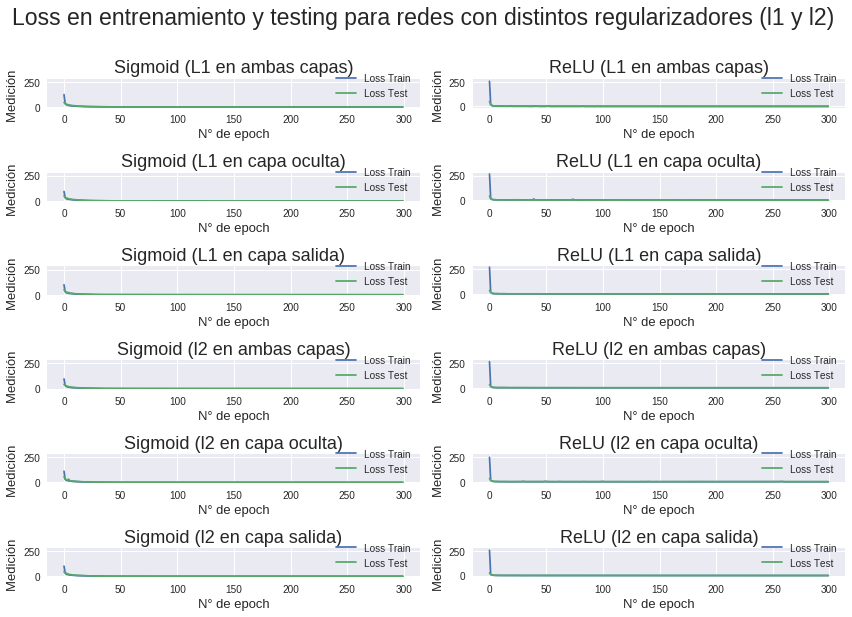

In [73]:
x = [max(loss_train_sigmoid_l1),max(loss_test_sigmoid_l1),max(loss_train_relu_l1),max(loss_test_relu_l1)]
valor_maximo = max(x)*1.1

plt.figure(1, figsize=(12,8))
plt.suptitle("Loss en entrenamiento y testing para redes con distintos regularizadores (l1 y l2) \n \n", fontsize=23, y=1.07)
plt.subplot(621)
plt.title("Sigmoid (L1 en ambas capas)",fontsize=18)
plt.plot(range(len(loss_train_sigmoid_l1)), loss_train_sigmoid_l1, label="Loss Train")
plt.plot(range(len(loss_test_sigmoid_l1)), loss_test_sigmoid_l1, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(622)
plt.title("ReLU (L1 en ambas capas)",fontsize=18)
plt.plot(range(len(loss_train_relu_l1)), loss_train_relu_l1, label="Loss Train")
plt.plot(range(len(loss_test_relu_l1)), loss_test_relu_l1, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(623)
plt.title("Sigmoid (L1 en capa oculta)",fontsize=18)
plt.plot(range(len(loss_train_sigmoid_l1_primera)), loss_train_sigmoid_l1_primera, label="Loss Train")
plt.plot(range(len(loss_test_sigmoid_l1_primera)), loss_test_sigmoid_l1_primera, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(624)
plt.title("ReLU (L1 en capa oculta)",fontsize=18)
plt.plot(range(len(loss_train_relu_l1_primera)), loss_train_relu_l1_primera, label="Loss Train")
plt.plot(range(len(loss_test_relu_l1_primera)), loss_test_relu_l1_primera, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(625)
plt.title("Sigmoid (L1 en capa salida)",fontsize=18)
plt.plot(range(len(loss_train_sigmoid_l1_segunda)), loss_train_sigmoid_l1_segunda, label="Loss Train")
plt.plot(range(len(loss_test_sigmoid_l1_segunda)), loss_test_sigmoid_l1_segunda, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(626)
plt.title("ReLU (L1 en capa salida)",fontsize=18)
plt.plot(range(len(loss_train_relu_l1_segunda)), loss_train_relu_l1_segunda, label="Loss Train")
plt.plot(range(len(loss_test_relu_l1_segunda)), loss_test_relu_l1_segunda, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(627)
plt.title("Sigmoid (l2 en ambas capas)",fontsize=18)
plt.plot(range(len(loss_train_sigmoid_l2)), loss_train_sigmoid_l2, label="Loss Train")
plt.plot(range(len(loss_test_sigmoid_l2)), loss_test_sigmoid_l2, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(628)
plt.title("ReLU (l2 en ambas capas)",fontsize=18)
plt.plot(range(len(loss_train_relu_l2)), loss_train_relu_l2, label="Loss Train")
plt.plot(range(len(loss_test_relu_l2)), loss_test_relu_l2, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(629)
plt.title("Sigmoid (l2 en capa oculta)",fontsize=18)
plt.plot(range(len(loss_train_sigmoid_l2_primera)), loss_train_sigmoid_l2_primera, label="Loss Train")
plt.plot(range(len(loss_test_sigmoid_l2_primera)), loss_test_sigmoid_l2_primera, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(6,2,10)
plt.title("ReLU (l2 en capa oculta)",fontsize=18)
plt.plot(range(len(loss_train_relu_l2_primera)), loss_train_relu_l2_primera, label="Loss Train")
plt.plot(range(len(loss_test_relu_l2_primera)), loss_test_relu_l2_primera, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(6,2,11)
plt.title("Sigmoid (l2 en capa salida)",fontsize=18)
plt.plot(range(len(loss_train_sigmoid_l2_segunda)), loss_train_sigmoid_l2_segunda, label="Loss Train")
plt.plot(range(len(loss_test_sigmoid_l2_segunda)), loss_test_sigmoid_l2_segunda, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(6,2,12)
plt.title("ReLU (l2 en capa salida)",fontsize=18)
plt.plot(range(len(loss_train_relu_l2_segunda)), loss_train_relu_l2_segunda, label="Loss Train")
plt.plot(range(len(loss_test_relu_l2_segunda)), loss_test_relu_l2_segunda, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()






plt.tight_layout()
plt.show()

Si realizamos un acercamiento a lo que sucede en los primeros epochs, obtenemos lo siguiente:


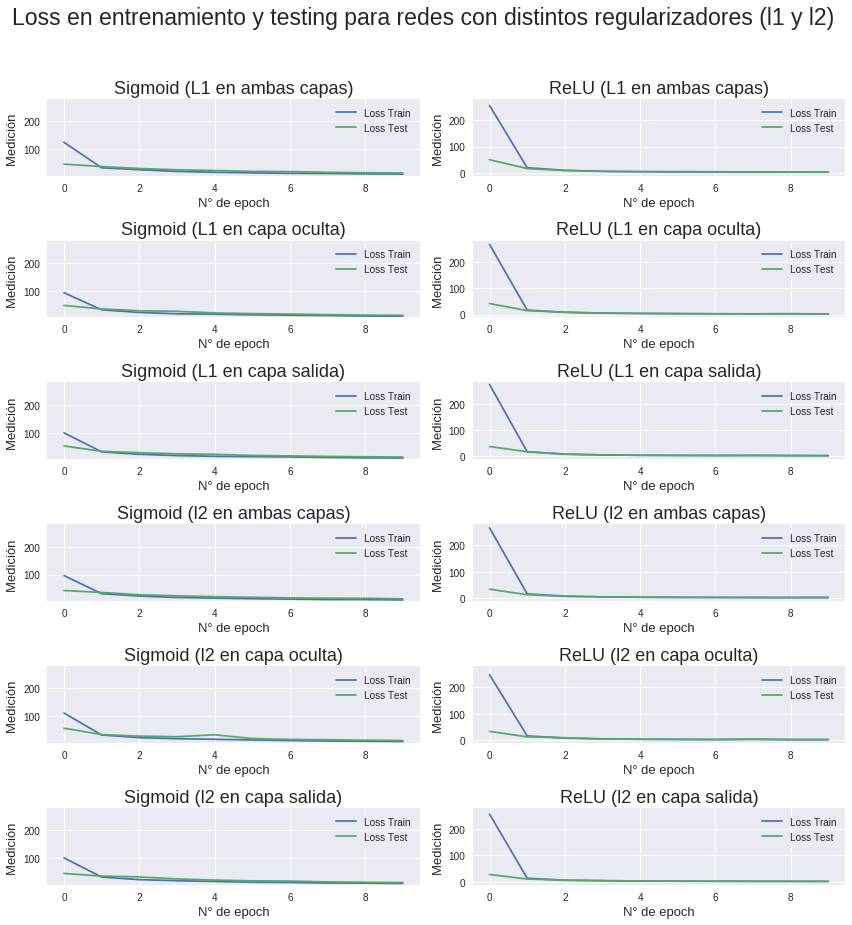

In [74]:
x = [max(loss_train_sigmoid_l1),max(loss_test_sigmoid_l1),max(loss_train_relu_l1),max(loss_test_relu_l1)]
valor_maximo = max(x)*1.1

valor_maximo = max(x)*1.1
max_epoch = 10

plt.figure(1, figsize=(12,12))
plt.suptitle("Loss en entrenamiento y testing para redes con distintos regularizadores (l1 y l2) \n \n", fontsize=23, y=1.07)
plt.subplot(621)
plt.title("Sigmoid (L1 en ambas capas)",fontsize=18)
plt.plot(range(max_epoch), loss_train_sigmoid_l1[0:max_epoch], label="Loss Train")
plt.plot(range(max_epoch), loss_test_sigmoid_l1[0:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(622)
plt.title("ReLU (L1 en ambas capas)",fontsize=18)
plt.plot(range(max_epoch), loss_train_relu_l1[0:max_epoch], label="Loss Train")
plt.plot(range(max_epoch), loss_test_relu_l1[0:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(623)
plt.title("Sigmoid (L1 en capa oculta)",fontsize=18)
plt.plot(range(max_epoch), loss_train_sigmoid_l1_primera[0:max_epoch], label="Loss Train")
plt.plot(range(max_epoch), loss_test_sigmoid_l1_primera[0:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(624)
plt.title("ReLU (L1 en capa oculta)",fontsize=18)
plt.plot(range(max_epoch), loss_train_relu_l1_primera[0:max_epoch], label="Loss Train")
plt.plot(range(max_epoch), loss_test_relu_l1_primera[0:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(625)
plt.title("Sigmoid (L1 en capa salida)",fontsize=18)
plt.plot(range(max_epoch), loss_train_sigmoid_l1_segunda[0:max_epoch], label="Loss Train")
plt.plot(range(max_epoch), loss_test_sigmoid_l1_segunda[0:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(626)
plt.title("ReLU (L1 en capa salida)",fontsize=18)
plt.plot(range(max_epoch), loss_train_relu_l1_segunda[0:max_epoch], label="Loss Train")
plt.plot(range(max_epoch), loss_test_relu_l1_segunda[0:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(627)
plt.title("Sigmoid (l2 en ambas capas)",fontsize=18)
plt.plot(range(max_epoch), loss_train_sigmoid_l2[0:max_epoch], label="Loss Train")
plt.plot(range(max_epoch), loss_test_sigmoid_l2[0:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(628)
plt.title("ReLU (l2 en ambas capas)",fontsize=18)
plt.plot(range(max_epoch), loss_train_relu_l2[0:max_epoch], label="Loss Train")
plt.plot(range(max_epoch), loss_test_relu_l2[0:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(629)
plt.title("Sigmoid (l2 en capa oculta)",fontsize=18)
plt.plot(range(max_epoch), loss_train_sigmoid_l2_primera[0:max_epoch], label="Loss Train")
plt.plot(range(max_epoch), loss_test_sigmoid_l2_primera[0:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(6,2,10)
plt.title("ReLU (l2 en capa oculta)",fontsize=18)
plt.plot(range(max_epoch), loss_train_relu_l2_primera[0:max_epoch], label="Loss Train")
plt.plot(range(max_epoch), loss_test_relu_l2_primera[0:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(6,2,11)
plt.title("Sigmoid (l2 en capa salida)",fontsize=18)
plt.plot(range(max_epoch), loss_train_sigmoid_l2_segunda[0:max_epoch], label="Loss Train")
plt.plot(range(max_epoch), loss_test_sigmoid_l2_segunda[0:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(6,2,12)
plt.title("ReLU (l2 en capa salida)",fontsize=18)
plt.plot(range(max_epoch), loss_train_relu_l2_segunda[0:max_epoch], label="Loss Train")
plt.plot(range(max_epoch), loss_test_relu_l2_segunda[0:max_epoch], label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()


plt.tight_layout()
plt.show()





plt.tight_layout()
plt.show()

## <font color='red'> ¡!¡!¡!¡!ANALIZAR - Falta probar con distintos valores de regularización</font>.

> i) Entrene los modelos obtenidos en b) y c) utilizando *Dropout*. Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente.

In [0]:
from keras.layers import Dropout

dropout_array = [0.3,0.2,0.1,0.01,0.001]

In [0]:
#Red sigmoid con dropout

loss_sigmoid_dropout_array = []
accuracy_sigmoid_dropout_array = []

for i in dropout_array:
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) 
  model.add(Activation('sigmoid'))
  model.add(Dropout(i, seed=1))#No estoy seguro si es que va aqui
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear')) 
  sgd = SGD(lr=0.01) #Aqui se aplica distintos valores para el decaimiento
  model.compile(optimizer=sgd,loss='mean_squared_error', metrics=['accuracy'])
  hist_sigmoid_dropout = model.fit(X_train_scaled, y_train, epochs=100, verbose=False, validation_data=(X_test_scaled,y_test))
  loss_sigmoid_dropout_array.append(hist_sigmoid_dropout.history['loss'])
  loss_sigmoid_dropout_array.append(hist_sigmoid_dropout.history['val_loss'])
  accuracy_sigmoid_dropout_array.append(hist_sigmoid_dropout.history['acc'])
  accuracy_sigmoid_dropout_array.append(hist_sigmoid_dropout.history['val_acc'])





In [0]:
#Red ReLU con dropout

loss_relu_dropout_array = []
accuracy_relu_dropout_array = []

for i in dropout_array:
  model = Sequential()
  model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) 
  model.add(Activation('sigmoid'))
  model.add(Dropout(i, seed=1))#No estoy seguro si es que va aqui
  model.add(Dense(1, kernel_initializer='uniform'))
  model.add(Activation('linear')) 
  sgd = SGD(lr=0.01) #Aqui se aplica distintos valores para el decaimiento
  model.compile(optimizer=sgd,loss='mean_squared_error', metrics=['accuracy'])
  hist_relu_dropout = model.fit(X_train_scaled, y_train, epochs=100, verbose=False, validation_data=(X_test_scaled,y_test))
  loss_relu_dropout_array.append(hist_relu_dropout.history['loss'])
  loss_relu_dropout_array.append(hist_relu_dropout.history['val_loss'])
  accuracy_relu_dropout_array.append(hist_relu_dropout.history['acc'])
  accuracy_relu_dropout_array.append(hist_relu_dropout.history['val_acc'])





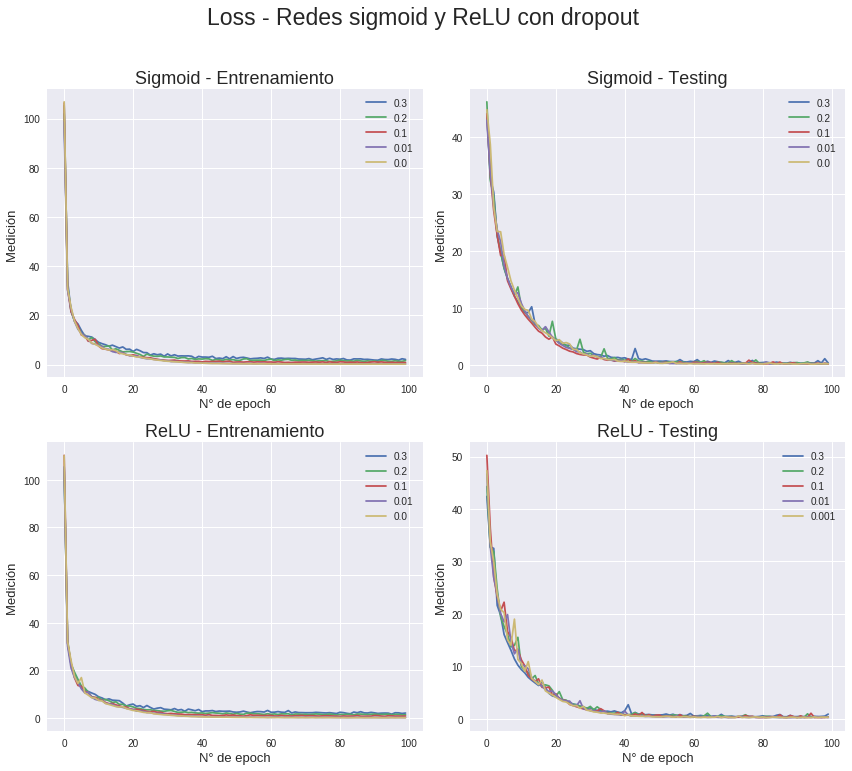

In [78]:
x = [max(loss_sigmoid_dropout_array),max(loss_relu_dropout_array)]
valor_maximo = max(x)[0]*1.0001

plt.figure(1, figsize=(12,10))
plt.suptitle("Loss - Redes sigmoid y ReLU con dropout \n", fontsize=23, y=1.07)

plt.subplot(221)
plt.title("Sigmoid - Entrenamiento",fontsize=18)
contador = 0
for i in range(0,len(loss_sigmoid_dropout_array),2):
  plt.plot(range(len(loss_sigmoid_dropout_array[i])), loss_sigmoid_dropout_array[i], label=str(round(dropout_array[contador],2)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
#plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(222)
plt.title("Sigmoid - Testing",fontsize=18)
contador = 0
for i in range(1,len(loss_sigmoid_dropout_array),2):
  plt.plot(range(len(loss_sigmoid_dropout_array[i])), loss_sigmoid_dropout_array[i], label=str(round(dropout_array[contador],2)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
#plt.ylim(ymax=valor_maximo)
plt.legend()


plt.subplot(223)
plt.title("ReLU - Entrenamiento",fontsize=18)
contador = 0
for i in range(0,len(loss_relu_dropout_array),2):
  plt.plot(range(len(loss_relu_dropout_array[i])), loss_relu_dropout_array[i], label=str(round(dropout_array[contador],2)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
#plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(224)
plt.title("ReLU - Testing",fontsize=18)
contador = 0
for i in range(1,len(loss_relu_dropout_array),2):
  plt.plot(range(len(loss_relu_dropout_array[i])), loss_relu_dropout_array[i], label=str(round(dropout_array[contador],6)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
#plt.ylim(ymax=valor_maximo)
plt.legend()


plt.tight_layout()
plt.show()

El *accuracy* obtenido en cada caso es de:


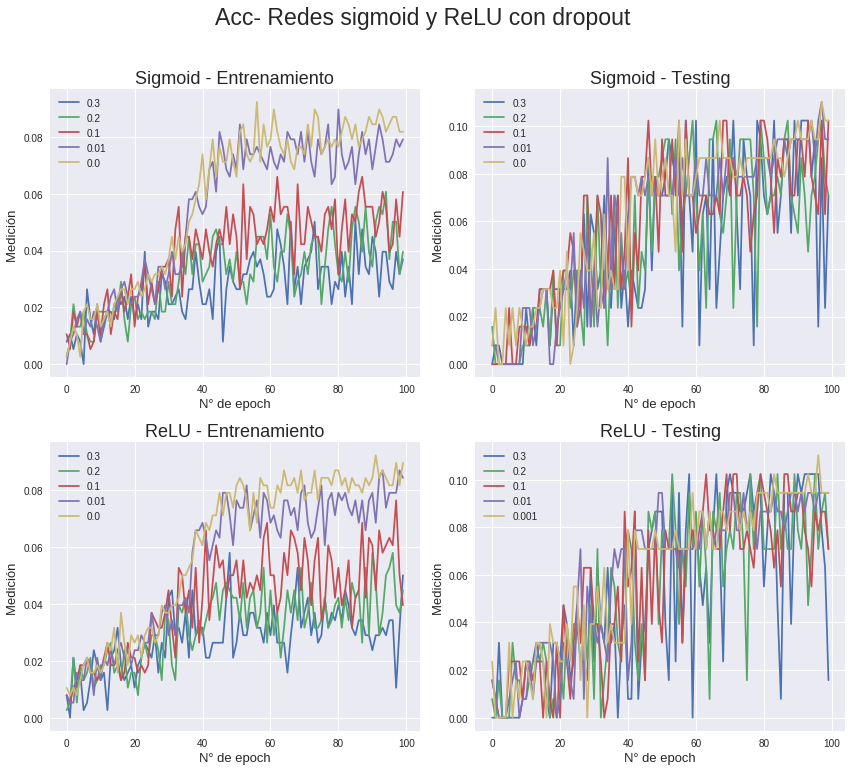

In [79]:
x = [max(accuracy_sigmoid_dropout_array),max(accuracy_relu_dropout_array)]
valor_maximo = max(x)[0]*1.0001

plt.figure(1, figsize=(12,10))
plt.suptitle("Acc- Redes sigmoid y ReLU con dropout \n", fontsize=23, y=1.07)

plt.subplot(221)
plt.title("Sigmoid - Entrenamiento",fontsize=18)
contador = 0
for i in range(0,len(accuracy_sigmoid_dropout_array),2):
  plt.plot(range(len(accuracy_sigmoid_dropout_array[i])), accuracy_sigmoid_dropout_array[i], label=str(round(dropout_array[contador],2)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
#plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(222)
plt.title("Sigmoid - Testing",fontsize=18)
contador = 0
for i in range(1,len(accuracy_sigmoid_dropout_array),2):
  plt.plot(range(len(accuracy_sigmoid_dropout_array[i])), accuracy_sigmoid_dropout_array[i], label=str(round(dropout_array[contador],2)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
#plt.ylim(ymax=valor_maximo)
plt.legend()


plt.subplot(223)
plt.title("ReLU - Entrenamiento",fontsize=18)
contador = 0
for i in range(0,len(accuracy_relu_dropout_array),2):
  plt.plot(range(len(accuracy_relu_dropout_array[i])), accuracy_relu_dropout_array[i], label=str(round(dropout_array[contador],2)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
#plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(224)
plt.title("ReLU - Testing",fontsize=18)
contador = 0
for i in range(1,len(accuracy_relu_dropout_array),2):
  plt.plot(range(len(accuracy_relu_dropout_array[i])), accuracy_relu_dropout_array[i], label=str(round(dropout_array[contador],6)))
  contador+=1
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
#plt.ylim(ymax=valor_maximo)
plt.legend()


plt.tight_layout()
plt.show()


<font color='red'> ¡!¡!¡!¡!Mejorar análisis. Explicar lo del accuracy. Añadir dropout a otras capas tambien y comparar</font> 

### Añadiendo dropout

> j) Fijando todos los demás hiper-parámetros del modelo definido en b) y en c), utilice validación cruzada con un número de *folds* igual a *K* = 5 y *K*=10 para determinar el mejor valor correspondiente a un parámetro que usted elija (tasa de aprendizaje, número de neuronas, parámetro de regularización, etc) ¿El mejor parámetro para la red con sigmoidal es distinto que para ReLU? ¿Porqué sucede? Además mida el error real del modelo sobre el conjunto de pruebas, compare y concluya.

La validación cruzada o cross-validation es una técnica utilizada para evaluar los resultados de un análisis estadístico y garantizar que son independientes de la partición entre datos de entrenamiento y prueba. Consiste en repetir y calcular la media aritmética obtenida de las medidas de evaluación sobre diferentes particiones. Se utiliza en entornos donde el objetivo principal es la predicción y se quiere estimar la precisión de un modelo que se llevará a cabo a la práctica. Es una técnica muy utilizada en proyectos de inteligencia artificial y de machine learning para validar modelos generados.

In [0]:
# Sigmoid - K = 5
from sklearn import cross_validation
Xm = X_train_scaled
ym = y_train

def crear_modelo(learning_rate):
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
    model.add(Activation('sigmoid'))
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear')) 
    sgd = SGD(learning_rate)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model
learning_rate = np.linspace(0.005,0.05,5)
resultados_s5 = []
for rate in learning_rate:
  print("Learning rate = "+str(rate))
  kfold = cross_validation.KFold(len(X_train_scaled), 5)
  cvscores = []
  for i, (train, val) in enumerate(kfold):
      model = crear_modelo(rate)
      # Fit the model
      model.fit(X_train_scaled, y_train, epochs=250, verbose=False)    # evaluate the model
      scores_s5 = model.evaluate(X_test_scaled,y_test, verbose=False)
      cvscores.append(scores)
  mse_cv = np.mean(cvscores)
  print(mse_cv)
  resultados_s5.append(mse_cv)
  


Learning rate = 0.005
nan
Learning rate = 0.01625
nan
Learning rate = 0.027500000000000004


In [14]:
# Sigmoid - K = 10
from sklearn import cross_validation
Xm = X_train_scaled
ym = y_train

def crear_modelo(learning_rate):
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
    model.add(Activation('sigmoid'))
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear')) 
    sgd = SGD(learning_rate)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model
learning_rate = np.linspace(0.005,0.05,5)
resultados_s10 = []
for rate in learning_rate:
  print("Learning rate = "+str(rate))
  kfold = cross_validation.KFold(len(X_train_scaled), 10)
  cvscores = []
  for i, (train, val) in enumerate(kfold):
      model = crear_modelo(rate)
      # Fit the model
      model.fit(X_train_scaled, y_train, epochs=250, verbose=False)    # evaluate the model
      scores_s10 = model.evaluate(X_test_scaled,y_test, verbose=False)
      cvscores.append(scores)
  mse_cv = np.mean(cvscores)
  print(mse_cv)
  resultados_s10.append(mse_cv)

Learning rate = 0.005
3.073464947798121
Learning rate = 0.01625
0.3045962924093712
Learning rate = 0.027500000000000004
404.32777405798896
Learning rate = 0.03875
nan
Learning rate = 0.05
nan


In [28]:
# ReLU- K = 5
from sklearn import cross_validation
Xm = X_train_scaled
ym = y_train

def crear_modelo(learning_rate):
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
    model.add(Activation('sigmoid'))
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear')) 
    sgd = SGD(learning_rate)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model
learning_rate = np.linspace(0.005,0.05,5)
resultados_r5 = []
for rate in learning_rate:
  print("Learning rate = "+str(rate))
  kfold = cross_validation.KFold(len(X_train_scaled), 5)
  cvscores = []
  for i, (train, val) in enumerate(kfold):
      model = crear_modelo(rate)
      # Fit the model
      model.fit(X_train_scaled, y_train, epochs=250, verbose=False)    # evaluate the model
      scores_r5 = model.evaluate(X_test_scaled,y_test, verbose=False)
      cvscores.append(scores)
  mse_cv = np.mean(cvscores)
  print(mse_cv)
  resultados_r5.append(mse_cv)

Learning rate = 0.005
nan
Learning rate = 0.01625


KeyboardInterrupt: ignored

In [16]:
# ReLU - K = 10
from sklearn import cross_validation
Xm = X_train_scaled
ym = y_train

def crear_modelo(learning_rate):
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear')) 
    sgd = SGD(learning_rate)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model
learning_rate = np.linspace(0.005,0.05,5)
resultados_r10 = []
for rate in learning_rate:
  print("Learning rate = "+str(rate))
  kfold = cross_validation.KFold(len(X_train_scaled), 10)
  cvscores = []
  for i, (train, val) in enumerate(kfold):
      model = crear_modelo(rate)
      # Fit the model
      model.fit(X_train_scaled, y_train, epochs=250, verbose=False)    # evaluate the model
      scores_r10 = model.evaluate(X_test_scaled,y_test, verbose=False)
      cvscores.append(scores)
  mse_cv = np.mean(cvscores)
  print(mse_cv)
  resultados_r10.append(mse_cv)

Learning rate = 0.005
0.5479753923697734
Learning rate = 0.01625
1.207685238052541
Learning rate = 0.027500000000000004
nan
Learning rate = 0.03875
nan
Learning rate = 0.05
nan


TypeError: ignored

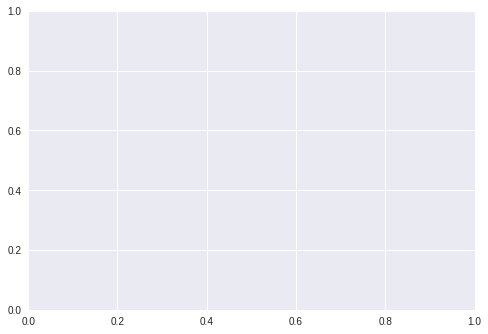

<a id="segundo"></a>
## 2. Deep Networks
Las *deep network*, o lo que hoy en día se conoce como *deep learning*, hace referencia a modelos de redes neuronales estructurados con muchas capas, es decir, el cómputo de la función final es la composición una gran cantidad de funciones ( $f^{(n)} = f^{(n-1)} \circ f^{(n-2)} \circ \cdots \circ f^{(2)} \circ f^{(1)} $ con $n \gg 0$ ).  
Este tipo de redes neuronales tienen una gran cantidad de parámetros, creciendo exponencialmente por capa con las redes *feed forward*, siendo bastante dificiles de entrenar comparadas con una red poco profunda, esto es debido a que requieren una gran cantidad de datos para ajustar correctamente todos esos parámetros. Pero entonces ¿Cuál es el beneficio que tienen este tipo de redes? ¿Qué ganancias trae el añadir capas a una arquitectura de una red neuronal?  

<img src="http://neuralnetworksanddeeplearning.com/images/tikz36.png" title="Title text" width="80%" height="20%" />



En esta sección se estudiará la complejidad de entrenar redes neuronales profundas, mediante la visualización de los gradientes de los pesos en cada capa, el cómo varía mientras se hace el *backpropagation* hacia las primeras capas de la red. 

> a) Se trabajará con las etiquetas escaladas uniformemente, es decir, $\mu=0$ y $\sigma=1$, ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de pruebas.

**Respuesta: Tanto los datos de entrenamiento como los de testing fueron ajustados en la pregunta anterior, por lo que no se repetirá este proceso para responder esta pregunta**


In [0]:
'''
from sklearn.preprocessing import StandardScaler 
#Normalizar datos de entrenamiento
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train = df_train.pop('MEDV').values.reshape(-1,1) # se cambio reshape por values.reshape Aqui es donde se hace una normalizacion creo

#Normalizar datos de testeo
scaler = StandardScaler().fit(df_test)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
y_test = df_test.pop('MEDV').values.reshape(-1,1) # se cambio reshape por values.reshape Aqui es donde se hace una normalizacion creo
'''

> b) Para el mismo problema definido anteriormente ([sección 1](#primero)) se entrenará diferentes redes. En esta primera instancia se trabajará con la misma red de la pregunta b), inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (*loss*) para el conjunto de entrenamiento respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de *gradients* (__[link](https://www.tensorflow.org/api_docs/python/tf/keras/backend/gradients)__) en el *backend* de Keras. Deberá generar un **histograma** para todos los pesos de cada capa antes y despues del entrenamiento con 300 *epochs*. Comente.

In [0]:
#Definir modelo
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error', metrics=['accuracy'])


In [0]:
# Antes de entrenar

###calculo de gradientes
loss = keras.losses.mean_squared_error(model.output,y_train) #y_predicho, y_verdadero
listOfVariableTensors = model.trainable_weights
#Ahora se calculan los gradientes
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

x_inicial_oculta = evaluated_gradients[0].flatten()
x_inicial_salida = evaluated_gradients[2].flatten()

In [0]:
# Entrenar
hist_sigmoid_b = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))


In [0]:
# Despues de entrenar

###calculo de gradientes

loss = keras.losses.mean_squared_error(model.output,y_train) #y_predicho, y_verdadero
listOfVariableTensors = model.trainable_weights
#Ahora se calculan los gradientes
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

x_final_oculta = evaluated_gradients[0].flatten()
x_final_salida= evaluated_gradients[2].flatten()


### Visualización de Gradientes de Pesos antes y después de entrenar

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


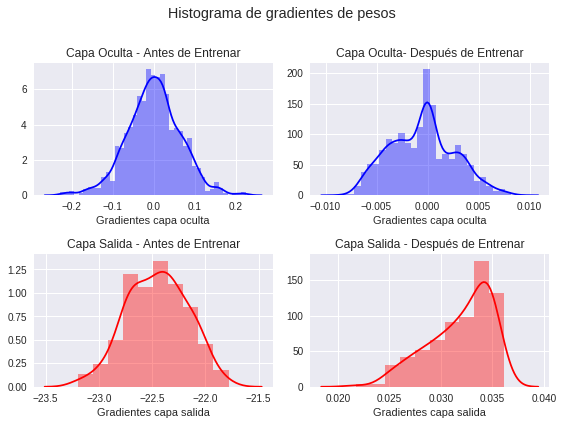

In [103]:
bp

In [95]:
#ESTO ES DE BIAS. PROPONGO BORRARLO
'''
#Encontre que era mejor ocupar seaborn en vez de hist de matplotlib por si solo.

x = evaluated_gradients[1]
ax = sns.distplot(x, axlabel="Valor del bias",label='Bias - Capa oculta', color='blue')
ax.set_title('Histograma de bias en capa oculta')


#y = evaluated_gradients[3] borrar. Las capas de peso son [0] y [2], [1] y [3] son los bias
#ax = sns.distplot(y,color='red', label="Bias - Capa Salida")
#ax.set_title('Histograma de segunda capa oculta')
#ax.legend()
'''

'\n#Encontre que era mejor ocupar seaborn en vez de hist de matplotlib por si solo.\n\nx = evaluated_gradients[1]\nax = sns.distplot(x, axlabel="Valor del bias",label=\'Bias - Capa oculta\', color=\'blue\')\nax.set_title(\'Histograma de bias en capa oculta\')\n\n\n#y = evaluated_gradients[3] borrar. Las capas de peso son [0] y [2], [1] y [3] son los bias\n#ax = sns.distplot(y,color=\'red\', label="Bias - Capa Salida")\n#ax.set_title(\'Histograma de segunda capa oculta\')\n#ax.legend()\n'

In [96]:
'''
x = evaluated_gradients[1]

# the histogram of the data
n, bins, patches = plt.hist(x, 50,  normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Cantidad de gradientes')
plt.ylabel('Valor del gradiente')
plt.title('Gradientes Bias - Capa oculta')
plt.grid(True)

plt.show()
'''



"\nx = evaluated_gradients[1]\n\n# the histogram of the data\nn, bins, patches = plt.hist(x, 50,  normed=1, facecolor='green', alpha=0.75)\n\nplt.xlabel('Cantidad de gradientes')\nplt.ylabel('Valor del gradiente')\nplt.title('Gradientes Bias - Capa oculta')\nplt.grid(True)\n\nplt.show()\n"

 <font color='red'> ¡!¡!¡!¡! Que se analiza de todo esto?</font> 

> c) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red mucho mas profunda de 6 capas, 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos *uniform* el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visual visualice las 3-4 primeras capas de la red. Comente si observa el efecto del *gradiente desvaneciente* antes y/o después de entrenar.

In [0]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200,  kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')


In [0]:
#Antes de Entrenar


loss = keras.losses.mean_squared_error(model.output,y_train) 
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

capa_oculta_1_inicio = evaluated_gradients[0].flatten()
capa_oculta_2_inicio = evaluated_gradients[2].flatten()
capa_oculta_3_inicio = evaluated_gradients[4].flatten()
capa_oculta_4_inicio = evaluated_gradients[6].flatten()


bias_1_inicio = evaluated_gradients[1].flatten()
bias_2_inicio = evaluated_gradients[3].flatten()
bias_3_inicio = evaluated_gradients[5].flatten()
bias_4_inicio = evaluated_gradients[7].flatten()

In [0]:
hist = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))


In [0]:
#Después de Entrenar

loss = keras.losses.mean_squared_error(model.output,y_train) 
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

capa_oculta_1_final = evaluated_gradients[0].flatten()
capa_oculta_2_final = evaluated_gradients[2].flatten()
capa_oculta_3_final = evaluated_gradients[4].flatten()
capa_oculta_4_final = evaluated_gradients[6].flatten()

bias_1_final = evaluated_gradients[1]
bias_2_final = evaluated_gradients[3]
bias_3_final = evaluated_gradients[5]
bias_4_final = evaluated_gradients[7]


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


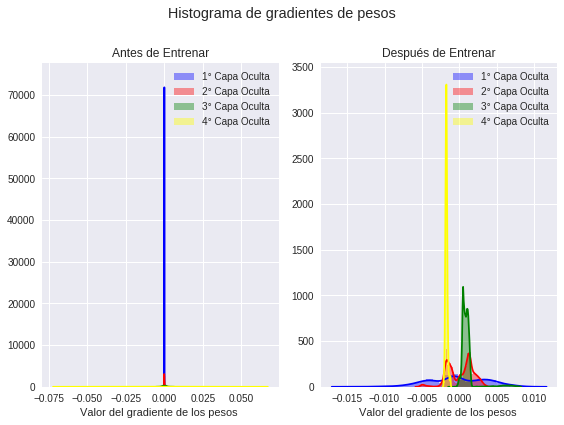

In [122]:

fig, ax =plt.subplots(1,2)
plt.suptitle('Histograma de gradientes de pesos', y=1.07)

sns.distplot(capa_oculta_1_inicio, axlabel="Valor del gradiente de los pesos ",label='1° Capa Oculta', color='blue', ax=ax[0])
sns.distplot(capa_oculta_2_inicio,color='red', label="2° Capa Oculta",ax=ax[0])
sns.distplot(capa_oculta_3_inicio,color='green', label="3° Capa Oculta",ax=ax[0])
sns.distplot(capa_oculta_4_inicio,color='yellow', label="4° Capa Oculta",ax=ax[0])
ax[0].legend()
ax[0].set_title("Antes de Entrenar")

sns.distplot(capa_oculta_1_final, axlabel="Valor del gradiente de los pesos ",label='1° Capa Oculta', color='blue', ax=ax[1])
sns.distplot(capa_oculta_2_final,color='red', label="2° Capa Oculta",ax=ax[1])
sns.distplot(capa_oculta_3_final,color='green', label="3° Capa Oculta",ax=ax[1])
sns.distplot(capa_oculta_4_final,color='yellow', label="4° Capa Oculta",ax=ax[1])
ax[1].legend()
ax[1].set_title("Después de Entrenar")

plt.tight_layout()
fig.show();


También para este caso se analizó que sucedía con los bias antes y después de entrenar

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


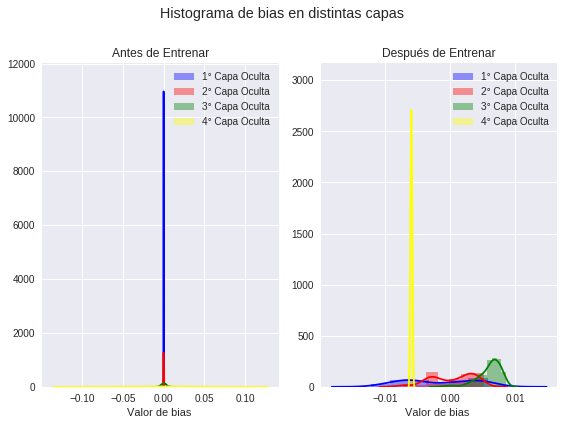

In [123]:
fig, ax =plt.subplots(1,2)
plt.suptitle('Histograma de bias en distintas capas', y=1.07)

sns.distplot(bias_1_inicio, axlabel="Valor de bias ",label='1° Capa Oculta', color='blue', ax=ax[0])
sns.distplot(bias_2_inicio,color='red', label="2° Capa Oculta",ax=ax[0])
sns.distplot(bias_3_inicio,color='green', label="3° Capa Oculta",ax=ax[0])
sns.distplot(bias_4_inicio,color='yellow', label="4° Capa Oculta",ax=ax[0])
ax[0].legend()
ax[0].set_title("Antes de Entrenar")

sns.distplot(bias_1_final, axlabel="Valor de bias ",label='1° Capa Oculta', color='blue', ax=ax[1])
sns.distplot(bias_2_final,color='red', label="2° Capa Oculta",ax=ax[1])
sns.distplot(bias_3_final,color='green', label="3° Capa Oculta",ax=ax[1])
sns.distplot(bias_4_final,color='yellow', label="4° Capa Oculta",ax=ax[1])
ax[1].legend()
ax[1].set_title("Después de Entrenar")

plt.tight_layout()
fig.show();

**Análisis**: Gradientes desvanecientes es un problema que se enfrenta en maquinas de aprendizaje y corresponde a una dificultad  encontrada en el entrenamiento de redes neuronales al utilizar backpropagation. En este caso, cada peso de la red neuronal recibe una actualización del gradiente proporcional al error de la función con respecto al peso respectivo en cada iteración del entrenamiento. El problema es que en algunos casos, el gradiente pasa a ser muy pequeño, haciendo que sea dificil que el peso cambie de valor. En el peor caso, esto podría causar que la red neuronal se detenga completamente de entrenar. 

En este caso, hay presencia de gradientes desvanecientes.

**COMPLETAR ANÁLISIS**


> d) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [[1]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$  y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del *gradiente desvaneciente* se amortigua antes y/o después de entrenar.

In [0]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200,  kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

In [0]:
#Antes de Entrenar


loss = keras.losses.mean_squared_error(model.output,y_train) 
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

capa_oculta_1_inicio = evaluated_gradients[0].flatten()
capa_oculta_2_inicio = evaluated_gradients[2].flatten()
capa_oculta_3_inicio = evaluated_gradients[4].flatten()
capa_oculta_4_inicio = evaluated_gradients[6].flatten()


bias_1_inicio = evaluated_gradients[1].flatten()
bias_2_inicio = evaluated_gradients[3].flatten()
bias_3_inicio = evaluated_gradients[5].flatten()
bias_4_inicio = evaluated_gradients[7].flatten()

In [0]:
hist = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))


In [0]:
#Después de Entrenar

loss = keras.losses.mean_squared_error(model.output,y_train) 
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

capa_oculta_1_final = evaluated_gradients[0].flatten()
capa_oculta_2_final = evaluated_gradients[2].flatten()
capa_oculta_3_final = evaluated_gradients[4].flatten()
capa_oculta_4_final = evaluated_gradients[6].flatten()

bias_1_final = evaluated_gradients[1]
bias_2_final = evaluated_gradients[3]
bias_3_final = evaluated_gradients[5]
bias_4_final = evaluated_gradients[7]


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


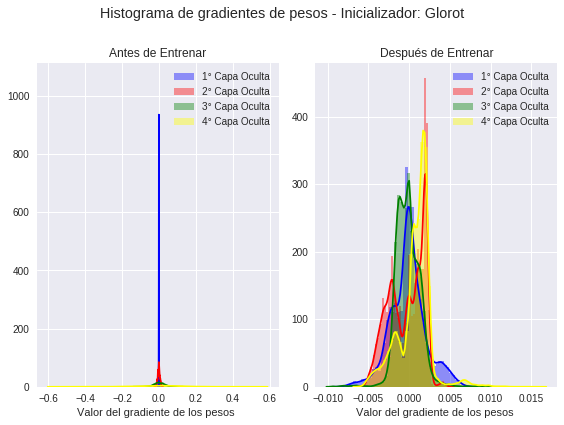

In [130]:

fig, ax =plt.subplots(1,2)
plt.suptitle('Histograma de gradientes de pesos - Inicializador: Glorot', y=1.07)

sns.distplot(capa_oculta_1_inicio, axlabel="Valor del gradiente de los pesos ",label='1° Capa Oculta', color='blue', ax=ax[0])
sns.distplot(capa_oculta_2_inicio,color='red', label="2° Capa Oculta",ax=ax[0])
sns.distplot(capa_oculta_3_inicio,color='green', label="3° Capa Oculta",ax=ax[0])
sns.distplot(capa_oculta_4_inicio,color='yellow', label="4° Capa Oculta",ax=ax[0])
ax[0].legend()
ax[0].set_title("Antes de Entrenar")

sns.distplot(capa_oculta_1_final, axlabel="Valor del gradiente de los pesos ",label='1° Capa Oculta', color='blue', ax=ax[1])
sns.distplot(capa_oculta_2_final,color='red', label="2° Capa Oculta",ax=ax[1])
sns.distplot(capa_oculta_3_final,color='green', label="3° Capa Oculta",ax=ax[1])
sns.distplot(capa_oculta_4_final,color='yellow', label="4° Capa Oculta",ax=ax[1])
ax[1].legend()
ax[1].set_title("Después de Entrenar")

plt.tight_layout()
fig.show();


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


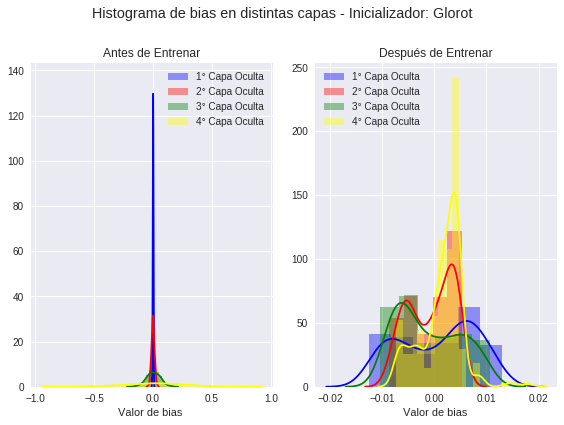

In [131]:
fig, ax =plt.subplots(1,2)
plt.suptitle('Histograma de bias en distintas capas - Inicializador: Glorot', y=1.07)

sns.distplot(bias_1_inicio, axlabel="Valor de bias ",label='1° Capa Oculta', color='blue', ax=ax[0])
sns.distplot(bias_2_inicio,color='red', label="2° Capa Oculta",ax=ax[0])
sns.distplot(bias_3_inicio,color='green', label="3° Capa Oculta",ax=ax[0])
sns.distplot(bias_4_inicio,color='yellow', label="4° Capa Oculta",ax=ax[0])
ax[0].legend()
ax[0].set_title("Antes de Entrenar")

sns.distplot(bias_1_final, axlabel="Valor de bias ",label='1° Capa Oculta', color='blue', ax=ax[1])
sns.distplot(bias_2_final,color='red', label="2° Capa Oculta",ax=ax[1])
sns.distplot(bias_3_final,color='green', label="3° Capa Oculta",ax=ax[1])
sns.distplot(bias_4_final,color='yellow', label="4° Capa Oculta",ax=ax[1])
ax[1].legend()
ax[1].set_title("Después de Entrenar")

plt.tight_layout()
fig.show();

**OJO! Después de la 3era capa, los gradientes se conservan en la misma distribución**. Completar análisis

> e) Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización *uniform* y comparar con la inicialización de He [[2]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del *gradiente desvaneciente* para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura.

### ReLU - Uniform

In [0]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='relu'))
model.add(Dense(200,  kernel_initializer='glorot_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

In [0]:
#Antes de Entrenar
loss = keras.losses.mean_squared_error(model.output,y_train) 
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

capa_oculta_1_inicio_uniform = evaluated_gradients[0].flatten()
capa_oculta_2_inicio_uniform = evaluated_gradients[2].flatten()
capa_oculta_3_inicio_uniform = evaluated_gradients[4].flatten()
capa_oculta_4_inicio_uniform = evaluated_gradients[6].flatten()


bias_1_inicio_uniform = evaluated_gradients[1].flatten()
bias_2_inicio_uniform = evaluated_gradients[3].flatten()
bias_3_inicio_uniform = evaluated_gradients[5].flatten()
bias_4_inicio_uniform = evaluated_gradients[7].flatten()

In [0]:
hist = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))


In [0]:
#Después de Entrenar

loss = keras.losses.mean_squared_error(model.output,y_train) 
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

capa_oculta_1_final_uniform = evaluated_gradients[0].flatten()
capa_oculta_2_final_uniform = evaluated_gradients[2].flatten()
capa_oculta_3_final_uniform = evaluated_gradients[4].flatten()
capa_oculta_4_final_uniform = evaluated_gradients[6].flatten()

bias_1_final_uniform = evaluated_gradients[1]
bias_2_final_uniform = evaluated_gradients[3]
bias_3_final_uniform = evaluated_gradients[5]
bias_4_final_uniform = evaluated_gradients[7]


### ReLU - He Uniform

In [0]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='relu'))
model.add(Dense(200,  kernel_initializer='glorot_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

In [0]:
#Antes de Entrenar
loss = keras.losses.mean_squared_error(model.output,y_train) 
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

capa_oculta_1_inicio_he_uniform = evaluated_gradients[0].flatten()
capa_oculta_2_inicio_he_uniform = evaluated_gradients[2].flatten()
capa_oculta_3_inicio_he_uniform = evaluated_gradients[4].flatten()
capa_oculta_4_inicio_he_uniform = evaluated_gradients[6].flatten()


bias_1_inicio_he_uniform = evaluated_gradients[1].flatten()
bias_2_inicio_he_uniform = evaluated_gradients[3].flatten()
bias_3_inicio_he_uniform = evaluated_gradients[5].flatten()
bias_4_inicio_he_uniform = evaluated_gradients[7].flatten()

In [0]:
hist = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))


In [0]:
#Después de Entrenar

loss = keras.losses.mean_squared_error(model.output,y_train) 
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

capa_oculta_1_final_he_uniform = evaluated_gradients[0].flatten()
capa_oculta_2_final_he_uniform = evaluated_gradients[2].flatten()
capa_oculta_3_final_he_uniform = evaluated_gradients[4].flatten()
capa_oculta_4_final_he_uniform = evaluated_gradients[6].flatten()

bias_1_final_he_uniform = evaluated_gradients[1]
bias_2_final_he_uniform = evaluated_gradients[3]
bias_3_final_he_uniform = evaluated_gradients[5]
bias_4_final_he_uniform = evaluated_gradients[7]


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


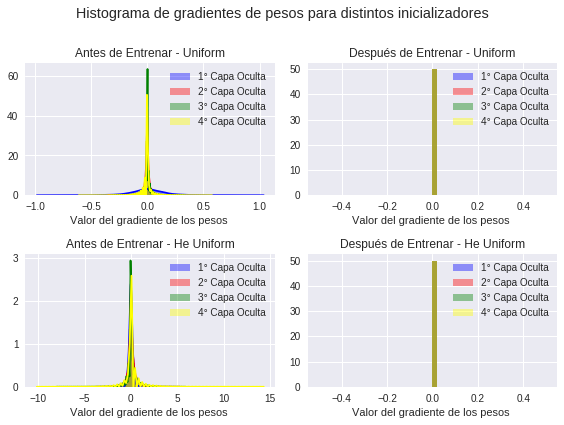

In [149]:

fig, ax =plt.subplots(2,2)
plt.suptitle('Histograma de gradientes de pesos para distintos inicializadores' , y=1.07)

sns.distplot(capa_oculta_1_inicio_uniform, axlabel="Valor del gradiente de los pesos ",label='1° Capa Oculta', color='blue', ax=ax[0,0])
sns.distplot(capa_oculta_2_inicio_uniform,color='red', label="2° Capa Oculta",ax=ax[0,0])
sns.distplot(capa_oculta_3_inicio_uniform,color='green', label="3° Capa Oculta",ax=ax[0,0])
sns.distplot(capa_oculta_4_inicio_uniform,color='yellow', label="4° Capa Oculta",ax=ax[0,0])
ax[0,0].legend()
ax[0,0].set_title("Antes de Entrenar - Uniform")

sns.distplot(capa_oculta_1_final_uniform, axlabel="Valor del gradiente de los pesos ",label='1° Capa Oculta', color='blue', ax=ax[0,1])
sns.distplot(capa_oculta_2_final_uniform,color='red', label="2° Capa Oculta",ax=ax[0,1])
sns.distplot(capa_oculta_3_final_uniform,color='green', label="3° Capa Oculta",ax=ax[0,1])
sns.distplot(capa_oculta_4_final_uniform,color='yellow', label="4° Capa Oculta",ax=ax[0,1])
ax[0,1].legend()
ax[0,1].set_title("Después de Entrenar - Uniform")

sns.distplot(capa_oculta_1_inicio_he_uniform, axlabel="Valor del gradiente de los pesos ",label='1° Capa Oculta', color='blue', ax=ax[1,0])
sns.distplot(capa_oculta_2_inicio_he_uniform,color='red', label="2° Capa Oculta",ax=ax[1,0])
sns.distplot(capa_oculta_3_inicio_he_uniform,color='green', label="3° Capa Oculta",ax=ax[1,0])
sns.distplot(capa_oculta_4_inicio_he_uniform,color='yellow', label="4° Capa Oculta",ax=ax[1,0])
ax[1,0].legend()
ax[1,0].set_title("Antes de Entrenar - He Uniform")

sns.distplot(capa_oculta_1_final_he_uniform, axlabel="Valor del gradiente de los pesos ",label='1° Capa Oculta', color='blue', ax=ax[1,1])
sns.distplot(capa_oculta_2_final_he_uniform,color='red', label="2° Capa Oculta",ax=ax[1,1])
sns.distplot(capa_oculta_3_final_he_uniform,color='green', label="3° Capa Oculta",ax=ax[1,1])
sns.distplot(capa_oculta_4_final_he_uniform,color='yellow', label="4° Capa Oculta",ax=ax[1,1])
ax[1,1].legend()
ax[1,1].set_title("Después de Entrenar - He Uniform")

plt.tight_layout()
fig.show();


Veamos que sucedes con los bias

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


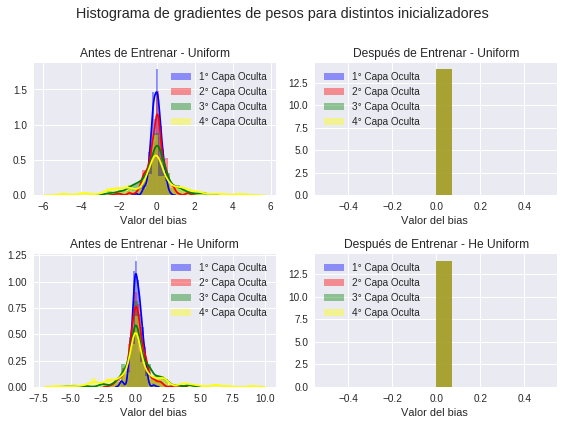

In [151]:

fig, ax =plt.subplots(2,2)
plt.suptitle('Histograma de gradientes de pesos para distintos inicializadores' , y=1.07)

sns.distplot(bias_1_inicio_uniform, axlabel="Valor del bias ",label='1° Capa Oculta', color='blue', ax=ax[0,0])
sns.distplot(bias_2_inicio_uniform,color='red', label="2° Capa Oculta",ax=ax[0,0])
sns.distplot(bias_3_inicio_uniform,color='green', label="3° Capa Oculta",ax=ax[0,0])
sns.distplot(bias_4_inicio_uniform,color='yellow', label="4° Capa Oculta",ax=ax[0,0])
ax[0,0].legend()
ax[0,0].set_title("Antes de Entrenar - Uniform")

sns.distplot(bias_1_final_uniform, axlabel="Valor del bias ",label='1° Capa Oculta', color='blue', ax=ax[0,1])
sns.distplot(bias_2_final_uniform,color='red', label="2° Capa Oculta",ax=ax[0,1])
sns.distplot(bias_3_final_uniform,color='green', label="3° Capa Oculta",ax=ax[0,1])
sns.distplot(bias_4_final_uniform,color='yellow', label="4° Capa Oculta",ax=ax[0,1])
ax[0,1].legend()
ax[0,1].set_title("Después de Entrenar - Uniform")

sns.distplot(bias_1_inicio_he_uniform, axlabel="Valor del bias ",label='1° Capa Oculta', color='blue', ax=ax[1,0])
sns.distplot(bias_2_inicio_he_uniform,color='red', label="2° Capa Oculta",ax=ax[1,0])
sns.distplot(bias_3_inicio_he_uniform,color='green', label="3° Capa Oculta",ax=ax[1,0])
sns.distplot(bias_4_inicio_he_uniform,color='yellow', label="4° Capa Oculta",ax=ax[1,0])
ax[1,0].legend()
ax[1,0].set_title("Antes de Entrenar - He Uniform")

sns.distplot(bias_1_final_he_uniform, axlabel="Valor del bias ",label='1° Capa Oculta', color='blue', ax=ax[1,1])
sns.distplot(bias_2_final_he_uniform,color='red', label="2° Capa Oculta",ax=ax[1,1])
sns.distplot(bias_3_final_he_uniform,color='green', label="3° Capa Oculta",ax=ax[1,1])
sns.distplot(bias_4_final_he_uniform,color='yellow', label="4° Capa Oculta",ax=ax[1,1])
ax[1,1].legend()
ax[1,1].set_title("Después de Entrenar - He Uniform")

plt.tight_layout()
fig.show();


**Análisis:** Revisar bien las diferencias

> e) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, *momentum*, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (*mse*) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.


Al mantener la red profunda con la cual se ha estado trabajando y solo cambiar la función de activación por sigmoid, se obtuvo un error menor al obtenido en el paso b

In [0]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200,  kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error', metrics=['accuracy'])



In [0]:
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300, verbose=False, validation_data=(X_test_scaled,y_test))


En la siguiente figura se observa la pérdida obtenida a medida que transcurren los epochs en la red shallow (definida y entrenada en la sección 2.b) junto a lo obtenido en la red profunda recientemente descrita.

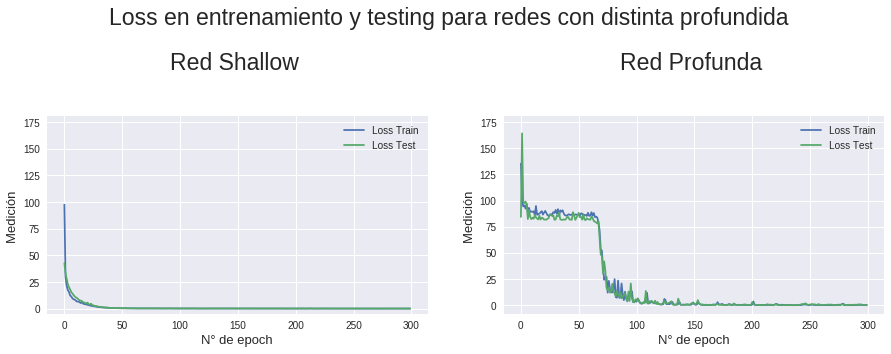

In [32]:
loss_train_sigmoid_b = hist_sigmoid_b.history['loss']
loss_test_sigmoid_b = hist_sigmoid_b.history['val_loss']
loss_train_sigmoid = hist_sigmoid.history['loss']
loss_test_sigmoid = hist_sigmoid.history['val_loss']


x = [max(loss_train_sigmoid),max(loss_test_sigmoid)]
valor_maximo = max(x)*1.1
plt.figure(1, figsize=(15,8))
plt.suptitle("Loss en entrenamiento y testing para redes con distinta profundida \n", fontsize=23, y=1.07)
plt.subplot(221)
plt.title("Red Shallow \n", fontsize=23, y=1.07)
plt.plot(range(len(loss_train_sigmoid_b)), loss_train_sigmoid_b, label="Loss Train")
plt.plot(range(len(loss_test_sigmoid_b)), loss_test_sigmoid_b, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.legend()
plt.subplot(222)



plt.title("Red Profunda \n", fontsize=23, y=1.07)
plt.plot(range(len(loss_train_sigmoid)), loss_train_sigmoid, label="Loss Train")
plt.plot(range(len(loss_test_sigmoid)), loss_test_sigmoid, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
            
plt.show()

Con respecto al accuracy, se pudo obtener lo siguiente:

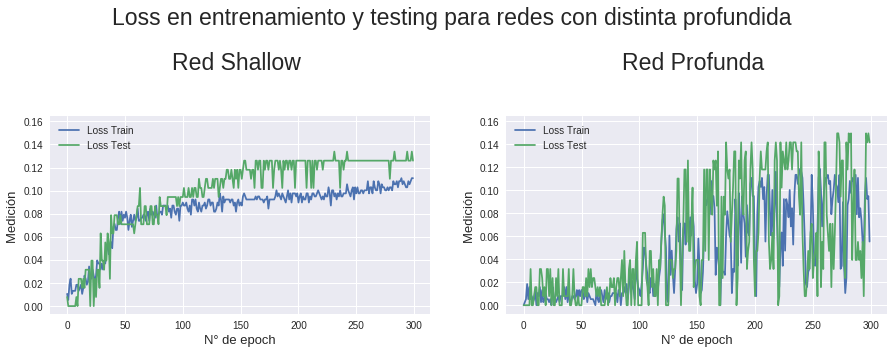

In [33]:
acc_train_sigmoid_b = hist_sigmoid_b.history['acc']
acc_test_sigmoid_b = hist_sigmoid_b.history['val_acc']
acc_train_sigmoid = hist_sigmoid.history['acc']
acc_test_sigmoid = hist_sigmoid.history['val_acc']

x = [max(acc_train_sigmoid),max(acc_test_sigmoid)]
valor_maximo = max(x)*1.1

plt.figure(1, figsize=(15,8))
plt.suptitle("Loss en entrenamiento y testing para redes con distinta profundida \n", fontsize=23, y=1.07)
plt.subplot(221)
plt.title("Red Shallow \n", fontsize=23, y=1.07)
plt.plot(range(len(acc_train_sigmoid_b)), acc_train_sigmoid_b, label="Loss Train")
plt.plot(range(len(acc_test_sigmoid_b)), acc_test_sigmoid_b, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.legend()


plt.subplot(222)
plt.title("Red Profunda \n", fontsize=23, y=1.07)
plt.plot(range(len(acc_train_sigmoid)), acc_train_sigmoid, label="Loss Train")
plt.plot(range(len(acc_test_sigmoid)), acc_test_sigmoid, label="Loss Test")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
            
plt.show()

In [41]:
epoch = 299
print("El accuracy obtenido en las distintas redes en el epoch "+str(epoch+1)+" fueron: ")
print("Entrenamiento Red shallow = "+str(round(acc_train_sigmoid_b[epoch],2)))
print("Entrenamiento Red Profunda = "+str(round(acc_train_sigmoid[epoch],2)))
print("---------------------")

print("Validación Red Profunda = "+str(round(acc_test_sigmoid[epoch],2)))
print("Validación Red shallow = "+str(round(acc_test_sigmoid_b[epoch],2)))



El accuracy obtenido en las distintas redes en el epoch 300 fueron: 
Entrenamiento Red shallow = 0.11
Entrenamiento Red Profunda = 0.06
---------------------
Validación Red Profunda = 0.14
Validación Red shallow = 0.13


> f) Pruebe con utilizar una red *shallow* (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?

### Red Shallow con ReLU

In [0]:
model = Sequential()
model.add(Dense(1000, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu')) # cambiar inicializador
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300,
    verbose=0, validation_data=(X_test_scaled, y_test))

In [43]:
loss_train_relu = hist_relu.history['loss']
loss_test_relu = hist_relu.history['val_loss']
#print(hist.history.keys())



NameError: ignored

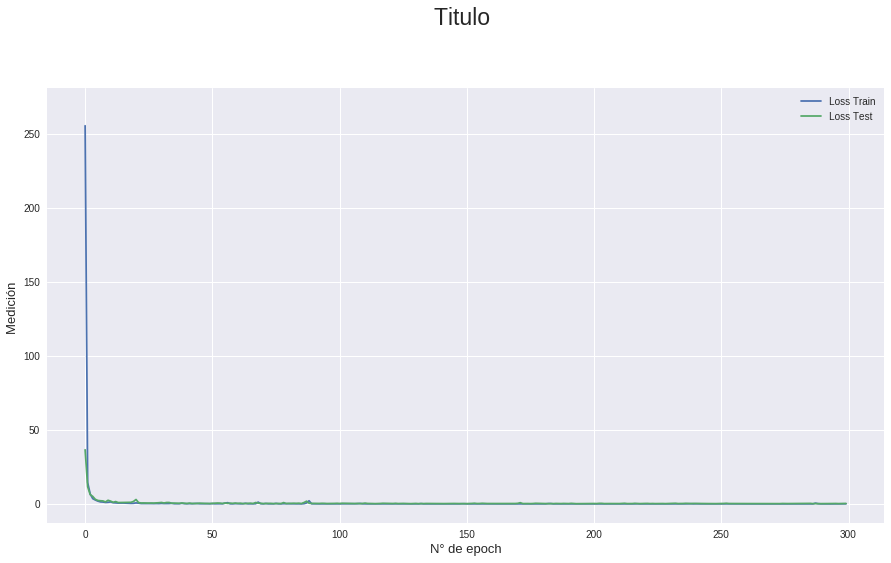

In [115]:
x = [max(loss_train_relu),max(loss_test_relu)]
valor_maximo = max(x)*1.1

plt.figure(1, figsize=(15,8))
plt.title("Titulo \n", fontsize=23, y=1.07)
plt.plot(range(len(loss_train_relu)), loss_train_relu, label="Loss Train")
plt.plot(range(len(loss_test_relu)), loss_test_relu, label="Loss Test")

plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.show()

### Red Shallow con Sigmoid

In [0]:
model = Sequential()
model.add(Dense(1000, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid')) # cambiar inicializador
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_sigmoid = model.fit(X_train_scaled, y_train, epochs=300,
    verbose=0, validation_data=(X_test_scaled, y_test))

In [0]:
loss_train_sigmoid = hist_sigmoid.history['loss']
loss_test_sigmoid = hist_sigmoid.history['val_loss']
#print(hist.history.keys())

In [50]:
loss_train_sigmoid[150:300] 

[2.945337018740209,
 2.907525721829296,
 2.8753756055102184,
 2.867450137566136,
 2.832793265659765,
 2.801091941176744,
 2.7821128009806206,
 2.736757919152997,
 2.7104246198030135,
 2.692865586846988,
 2.691297413491322,
 2.652220804018207,
 2.639767371255678,
 2.617730296696082,
 2.5835918251002368,
 2.5754209955009117,
 2.571847131824745,
 2.5362018047976935,
 2.50399583122032,
 2.466183951158951,
 2.452024175497976,
 2.4344384406047004,
 2.427663751516619,
 2.4045858615935636,
 2.380398290452982,
 2.3611160321726334,
 2.349084737118442,
 2.3586708420499334,
 2.312802193661793,
 2.30814577784576,
 2.3031667150104895,
 2.254901363541394,
 2.256493610882822,
 2.227921556671565,
 2.208815767142263,
 2.1946409311646837,
 2.1685572431710276,
 2.151556444042276,
 2.1402810723926273,
 2.1312500251000035,
 2.098770424684308,
 2.0989156505363282,
 2.072375174877197,
 2.0532251964458377,
 2.025610317655478,
 2.0157314796875525,
 1.9806348069676623,
 1.9667058541466504,
 1.928209559269505,
 1

In [47]:
loss_test_sigmoid[0:10]

[36402.664892962595,
 642.3906922828494,
 311.785354253814,
 226.4646697757751,
 174.87143232691005,
 140.65479116364727,
 113.4963218508743,
 95.41571333276944,
 83.65727197842335,
 76.41426921454001]

La red shallow con Sigmoid DIVERGE.

**Agregar análisis**

<a id="tercero"></a>
# 3. Convolutional Neural Network (CNN) en CIFAR.

En esta sección trabajaremos con un *dataset* bastante conocido y utilizado por la comunidad para experimentar con reconocimiento de objetos en imágenes: **CIFAR10** [[3]](#refs). Se trata de un conjunto de 60.000 imágenes RGB de 32 × 32 pixeles que contiene 10 clases de objetos y 6000 ejemplos por clase. La versión utilizada se atribuye a *A. Krizhevsky, V. Nair y G. Hinton* y viene separada en 50000 ejemplos de entrenamiento y 10000 casos de prueba. El conjunto de pruebas fue obtenido seleccionando 1000 imágenes aleatorias de cada clase. Los datos restantes han sido ordenados aleatoriamente y están organizados en 5 bloques de entrenamiento (*batches*). Las clases son mutuamente excluyentes y corresponden a las siguientes categorı́as: gatos, perros, ranas, caballos, pájaros, ciervos, aviones, automóviles, camiones y barcos. Para esta tarea se experimentará con redes convolucionales, conocidas como CNNs ó *ConvNets*.  
Nota: *Para esta actividad es bastante aconsejable entrenar las redes usando una GPU, ya que de otro modo los tiempos de entrenamiento son largos, por lo que recuerde instalar keras con gpu y el driver de __[cuda](https://developer.nvidia.com/cuda-downloads)__ para la tarjeta gráfica*.  

Los datos asociados a esta actividad podrán ser obtenidos utilizando los siguientes comandos en la lı́nea
de comandos (sistemas UNIX)
```
wget http://octopus.inf.utfsm.cl/~ricky/data.tar.gz
tar -xzvf data.tar.gz
rm data.tar.gz
```
En la carpeta generada encontrarán 5 archivos denominados ’*data batch 1*’, ’*data batch 2*’, ’*data batch 3*’,
’*data batch 4*’, ’*data batch 5*’ y ’*test batch*’ correspondientes a los 5 bloques de entrenamiento y al conjunto
de pruebas respectivamente. Los archivos corresponden a diccionarios serializados de Python, utilizando la librería Pickle.  
Una vez extraı́do, cada diccionario contendrá 2 elementos importantes: *data* y *labels*. El primer elemento (*data*) es un matriz de 10000 × 3072 (*numpy array*). Cada fila de esa matriz corresponde a una imagen RGB: los primeros 1024 valores vienen del canal R, los siguientes 1024 del canal G, y los últimos 1024 del canal B. Para cada canal, las imágenes han sido vectorizadas por filas, de modo que los primeros 32 valores del canal R corresponden a la primera fila de la imagen. Por otro lado, el elemento (*labels*) del diccionario contiene una lista de 1000 valores enteros entre 0 y 9 que identifican las clases antes enumeradas.

> a) Construya una función que cargue todos los bloques de entrenamiento y pruebas del problema CIFAR generando como salida: (i) dos matrices $X_{tr}$, $Y_{tr}$, correspondientes a las imágenes y etiquetas de entrenamiento, (ii) dos matrices $X_t$ , $Y_t$ , correspondientes a las imágenes y etiquetas de pruebas, y finalmente (iii) dos matrices $X_v$,$Y_v$, correspondientes a imágenes y etiquetas que se usarán como conjunto de validación, es decir para tomar decisiones de diseño acerca del modelo. Este último conjunto debe ser extraı́do desde el conjunto de entrenamiento original y no debe superar las 5000 imágenes

In [0]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
import pickle as pickle
import numpy as np
from keras.datasets import cifar10

## Preparación del dataset

> b) Prepare subconjuntos de entrenamiento, validación y pruebas normalizando las imágenes de entrenamiento y pruebas, dividiendo las intensidades originales de pixel en cada canal por 255. Es importante recordar que ahora se trabajará con la estructura original de los datos, por lo que es necesario recuperar la forma original de las imágenes del vector en el archivo en que vienen. Además, si desea trabajar con el orden de las dimensiones denominado ’tf’ (por defecto para *TensorFlow*) deberá hacer realizar la transposición correspondiente.
Finalmente, genere una representación adecuada de las salidas deseadas de la red.

In [0]:
num_classes = len(label_names)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Definición de una red neuronal convolucional

> c) Defina una CNN con arquitectura $C \times P \times C \times P \times F \times F$. Para ambas capas convolucionales utilice 64 filtros de $3 \times 3$ y funciones de activación ReLu. Para las capas de pooling utilice filtros de $2 \times 2$ con stride 2. Para la capa MLP escondida use 512 neuronas. Genere un esquema lo más compacto posible que muestre los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un forward-pass y el número de parámetros de cada capa.

In [41]:

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_69 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_70 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 4096)              0         
__________

## Entrenamiento de red con SGD y Step decay

> d)  Entrene la CNN definida en c) utilizando SGD. En este dataset, una tasa de aprendizaje “segura” es $\eta = 10^4$ o inferior, pero durante las primeras *epochs* el entrenamiento resulta demasiado lento. Para resolver el problema aprenderemos a controlar la tasa de aprendizaje utilizada en el entrenamiento. Implemente la siguiente idea: deseamos partir con una tasa de aprendizaje $\eta = 10^3$ y dividir por 2 ese valor cada 10 epochs. Suponga además que no queremos usar una tasa de aprendizaje menor a $\eta = 10^5$.  Construya un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de “epochs”, entrene con 25 *epochs*.

In [0]:

def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate
  
batch_size=25
epochs=25

In [42]:

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
train_step = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_test,y_test), shuffle=True, callbacks=[lrate], verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 20s 407us/step - loss: 1.8583 - acc: 0.3375 - val_loss: 1.5432 - val_acc: 0.4470
Epoch 2/25
27500/50000 [===============>..............] - ETA: 7s - loss: 1.4785 - acc: 0.4725

50000/50000 [==============================] - 19s 379us/step - loss: 1.4369 - acc: 0.4859 - val_loss: 1.3254 - val_acc: 0.5342
Epoch 3/25
50000/50000 [==============================] - 19s 375us/step - loss: 1.2724 - acc: 0.5504 - val_loss: 1.2069 - val_acc: 0.5739
Epoch 4/25
 6825/50000 [===>..........................] - ETA: 14s - loss: 1.1766 - acc: 0.5938

50000/50000 [==============================] - 19s 379us/step - loss: 1.1536 - acc: 0.5935 - val_loss: 1.1434 - val_acc: 0.6008
Epoch 5/25
50000/50000 [==============================] - 19s 389us/step - loss: 1.0298 - acc: 0.6417 - val_loss: 1.0593 - val_acc: 0.6298
Epoch 6/25
 1125/50000 [..............................] - ETA: 16s - loss: 0.9834 - acc: 0.6533

50000/50000 [==============================] - 20s 394us/step - loss: 0.9768 - acc: 0.6591 - val_loss: 1.0224 - val_acc: 0.6441
Epoch 7/25
48950/50000 [============================>.] - ETA: 0s - loss: 0.9294 - acc: 0.6798

50000/50000 [==============================] - 20s 390us/step - loss: 0.9294 - acc: 0.6796 - val_loss: 1.0159 - val_acc: 0.6461
Epoch 8/25
50000/50000 [==============================] - 20s 398us/step - loss: 0.8842 - acc: 0.6940 - val_loss: 0.9731 - val_acc: 0.6631
Epoch 9/25
 9650/50000 [====>.........................] - ETA: 15s - loss: 0.8437 - acc: 0.7073

50000/50000 [==============================] - 20s 407us/step - loss: 0.8409 - acc: 0.7096 - val_loss: 0.9392 - val_acc: 0.6709
Epoch 10/25
50000/50000 [==============================] - 20s 392us/step - loss: 0.7692 - acc: 0.7366 - val_loss: 0.9185 - val_acc: 0.6792
Epoch 11/25
  825/50000 [..............................] - ETA: 16s - loss: 0.6770 - acc: 0.7782

50000/50000 [==============================] - 20s 392us/step - loss: 0.7439 - acc: 0.7447 - val_loss: 0.9314 - val_acc: 0.6775
Epoch 12/25
49425/50000 [============================>.] - ETA: 0s - loss: 0.7221 - acc: 0.7526

50000/50000 [==============================] - 19s 390us/step - loss: 0.7212 - acc: 0.7528 - val_loss: 0.9210 - val_acc: 0.6848
Epoch 13/25
50000/50000 [==============================] - 20s 392us/step - loss: 0.6990 - acc: 0.7606 - val_loss: 0.9099 - val_acc: 0.6837
Epoch 14/25
10050/50000 [=====>........................] - ETA: 14s - loss: 0.6842 - acc: 0.7662

50000/50000 [==============================] - 20s 399us/step - loss: 0.6748 - acc: 0.7714 - val_loss: 0.9017 - val_acc: 0.6923
Epoch 15/25
50000/50000 [==============================] - 20s 393us/step - loss: 0.6284 - acc: 0.7886 - val_loss: 0.8978 - val_acc: 0.6913
Epoch 16/25
 1275/50000 [..............................] - ETA: 16s - loss: 0.6082 - acc: 0.7906

50000/50000 [==============================] - 19s 386us/step - loss: 0.6129 - acc: 0.7936 - val_loss: 0.8889 - val_acc: 0.6961
Epoch 17/25
48575/50000 [============================>.] - ETA: 0s - loss: 0.5995 - acc: 0.7981

50000/50000 [==============================] - 20s 396us/step - loss: 0.5993 - acc: 0.7981 - val_loss: 0.9031 - val_acc: 0.6895
Epoch 18/25
50000/50000 [==============================] - 20s 398us/step - loss: 0.5868 - acc: 0.8025 - val_loss: 0.8822 - val_acc: 0.6977
Epoch 19/25
 9575/50000 [====>.........................] - ETA: 14s - loss: 0.5680 - acc: 0.8080

50000/50000 [==============================] - 20s 395us/step - loss: 0.5730 - acc: 0.8076 - val_loss: 0.8889 - val_acc: 0.6972
Epoch 20/25
50000/50000 [==============================] - 20s 400us/step - loss: 0.5458 - acc: 0.8198 - val_loss: 0.8907 - val_acc: 0.6979
Epoch 21/25
  325/50000 [..............................] - ETA: 18s - loss: 0.5454 - acc: 0.8031

50000/50000 [==============================] - 20s 398us/step - loss: 0.5376 - acc: 0.8224 - val_loss: 0.8871 - val_acc: 0.6982
Epoch 22/25
49050/50000 [============================>.] - ETA: 0s - loss: 0.5278 - acc: 0.8246

50000/50000 [==============================] - 19s 389us/step - loss: 0.5295 - acc: 0.8242 - val_loss: 0.8831 - val_acc: 0.6995
Epoch 23/25
50000/50000 [==============================] - 20s 392us/step - loss: 0.5220 - acc: 0.8293 - val_loss: 0.8930 - val_acc: 0.6984
Epoch 24/25
10050/50000 [=====>........................] - ETA: 14s - loss: 0.5177 - acc: 0.8293

50000/50000 [==============================] - 19s 389us/step - loss: 0.5156 - acc: 0.8314 - val_loss: 0.8842 - val_acc: 0.7018
Epoch 25/25
50000/50000 [==============================] - 20s 397us/step - loss: 0.5006 - acc: 0.8377 - val_loss: 0.8872 - val_acc: 0.6997


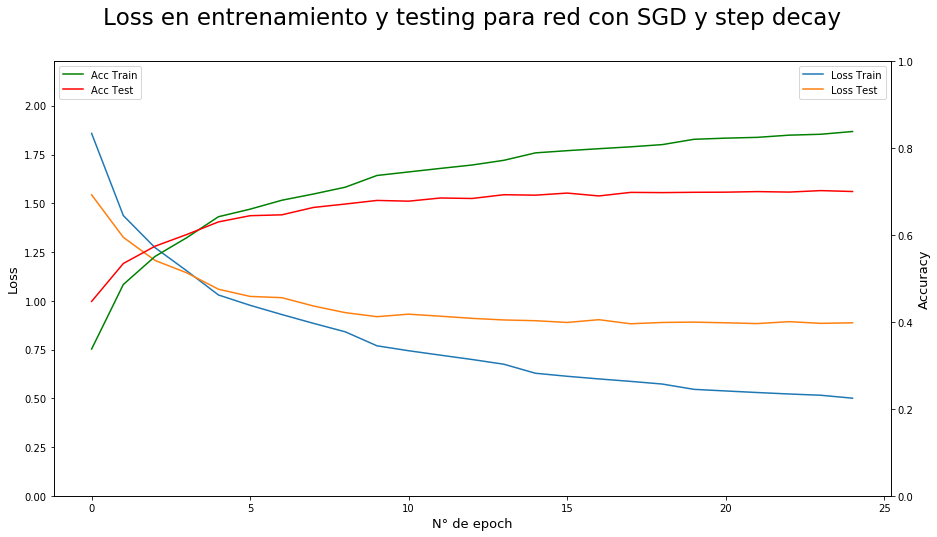

In [43]:
loss_train_step = train_step.history['loss']
loss_test_step = train_step.history['val_loss']
acc_train_step = train_step.history['acc']
acc_test_step = train_step.history['val_acc']
x = [max(loss_train_step),max(loss_test_step)]
valor_maximo = max(x)*1.2

plt.subplots(1, figsize=(15,8))
plt.title("Loss en entrenamiento y testing para red con SGD y step decay", fontsize=23, y=1.07)
plt.plot(range(len(loss_train_step)), loss_train_step, label="Loss Train")
plt.plot(range(len(loss_test_step)), loss_test_step, label="Loss Test")
plt.ylabel('Loss', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymin = 0, ymax=valor_maximo)
plt.legend()

plt.twinx()

plt.plot(range(len(acc_train_step)), acc_train_step, label="Acc Train", color = "green")
plt.plot(range(len(acc_test_step)), acc_test_step, label="Acc Test", color = "red")
plt.ylim(ymin = 0, ymax=1)
plt.ylabel('Accuracy', fontsize=13)
plt.legend(loc=2)
plt.show()

Se puede notar que el entrenamiento fue existoso pese a que existen diferencias considerables entre la función de pérdida en entrenamiento y validación, pero no ocurrió overfitting.

## CNN con RMSProp

> e) Entrene la CNN definida en c) utilizando **RMSProp** durante 25 *epochs*. Elija la función de pérdida más apropiada para este problema. Construya finalmente un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de *epochs*.

In [35]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_65 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_66 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 4096)              0         
__________

In [36]:
from keras.optimizers import SGD, rmsprop
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn_rmsprop = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_test, y_test),shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 22s 436us/step - loss: 1.3261 - acc: 0.5318 - val_loss: 1.1491 - val_acc: 0.6007
Epoch 2/25
22825/50000 [============>.................] - ETA: 10s - loss: 0.9694 - acc: 0.6656

50000/50000 [==============================] - 21s 418us/step - loss: 0.9526 - acc: 0.6730 - val_loss: 1.0018 - val_acc: 0.6504
Epoch 3/25
50000/50000 [==============================] - 21s 424us/step - loss: 0.8246 - acc: 0.7225 - val_loss: 1.0372 - val_acc: 0.6536
Epoch 4/25
 1475/50000 [..............................] - ETA: 19s - loss: 0.7285 - acc: 0.7627

50000/50000 [==============================] - 21s 419us/step - loss: 0.7405 - acc: 0.7545 - val_loss: 0.8827 - val_acc: 0.7109
Epoch 5/25
44650/50000 [=========================>....] - ETA: 2s - loss: 0.6768 - acc: 0.7778

50000/50000 [==============================] - 21s 420us/step - loss: 0.6798 - acc: 0.7763 - val_loss: 1.0290 - val_acc: 0.6933
Epoch 6/25
50000/50000 [==============================] - 21s 418us/step - loss: 0.6382 - acc: 0.7934 - val_loss: 1.0263 - val_acc: 0.6824
Epoch 7/25
 6375/50000 [==>...........................] - ETA: 16s - loss: 0.5339 - acc: 0.8282

50000/50000 [==============================] - 21s 421us/step - loss: 0.6004 - acc: 0.8034 - val_loss: 0.9336 - val_acc: 0.7128
Epoch 8/25
45750/50000 [==========================>...] - ETA: 1s - loss: 0.5537 - acc: 0.8208

50000/50000 [==============================] - 21s 418us/step - loss: 0.5602 - acc: 0.8189 - val_loss: 0.9903 - val_acc: 0.7063
Epoch 9/25
50000/50000 [==============================] - 21s 419us/step - loss: 0.5423 - acc: 0.8283 - val_loss: 1.3095 - val_acc: 0.6851
Epoch 10/25
 6675/50000 [===>..........................] - ETA: 16s - loss: 0.4825 - acc: 0.8452

50000/50000 [==============================] - 21s 421us/step - loss: 0.5247 - acc: 0.8346 - val_loss: 1.0956 - val_acc: 0.6910
Epoch 11/25
45900/50000 [==========================>...] - ETA: 1s - loss: 0.4993 - acc: 0.8446

50000/50000 [==============================] - 21s 421us/step - loss: 0.5010 - acc: 0.8443 - val_loss: 1.4111 - val_acc: 0.6764
Epoch 12/25
50000/50000 [==============================] - 21s 419us/step - loss: 0.4877 - acc: 0.8494 - val_loss: 1.3886 - val_acc: 0.6862
Epoch 13/25
 6900/50000 [===>..........................] - ETA: 16s - loss: 0.4238 - acc: 0.8714

50000/50000 [==============================] - 21s 420us/step - loss: 0.4701 - acc: 0.8563 - val_loss: 1.3946 - val_acc: 0.6897
Epoch 14/25
45050/50000 [==========================>...] - ETA: 1s - loss: 0.4551 - acc: 0.8623

50000/50000 [==============================] - 21s 420us/step - loss: 0.4560 - acc: 0.8621 - val_loss: 1.2379 - val_acc: 0.6948
Epoch 15/25
50000/50000 [==============================] - 21s 420us/step - loss: 0.4450 - acc: 0.8657 - val_loss: 1.5505 - val_acc: 0.6928
Epoch 16/25
 6350/50000 [==>...........................] - ETA: 16s - loss: 0.3961 - acc: 0.8803

50000/50000 [==============================] - 21s 419us/step - loss: 0.4281 - acc: 0.8717 - val_loss: 1.5099 - val_acc: 0.6983
Epoch 17/25
46875/50000 [===========================>..] - ETA: 1s - loss: 0.4253 - acc: 0.8745

50000/50000 [==============================] - 21s 420us/step - loss: 0.4275 - acc: 0.8740 - val_loss: 1.4365 - val_acc: 0.6707
Epoch 18/25
50000/50000 [==============================] - 21s 422us/step - loss: 0.4169 - acc: 0.8778 - val_loss: 2.0176 - val_acc: 0.7058
Epoch 19/25
 6200/50000 [==>...........................] - ETA: 16s - loss: 0.3853 - acc: 0.8915

50000/50000 [==============================] - 21s 418us/step - loss: 0.4212 - acc: 0.8804 - val_loss: 1.9772 - val_acc: 0.7086
Epoch 20/25
45750/50000 [==========================>...] - ETA: 1s - loss: 0.4077 - acc: 0.8854

50000/50000 [==============================] - 21s 420us/step - loss: 0.4087 - acc: 0.8853 - val_loss: 1.8728 - val_acc: 0.6645
Epoch 21/25
50000/50000 [==============================] - 21s 420us/step - loss: 0.4078 - acc: 0.8876 - val_loss: 1.7603 - val_acc: 0.6654
Epoch 22/25
 6425/50000 [==>...........................] - ETA: 16s - loss: 0.3458 - acc: 0.9040

50000/50000 [==============================] - 21s 419us/step - loss: 0.3926 - acc: 0.8927 - val_loss: 1.9875 - val_acc: 0.6849
Epoch 23/25
45325/50000 [==========================>...] - ETA: 1s - loss: 0.3867 - acc: 0.8947

50000/50000 [==============================] - 21s 418us/step - loss: 0.3876 - acc: 0.8940 - val_loss: 1.8816 - val_acc: 0.6371
Epoch 24/25
50000/50000 [==============================] - 21s 418us/step - loss: 0.3885 - acc: 0.8950 - val_loss: 1.9189 - val_acc: 0.6778
Epoch 25/25
 6550/50000 [==>...........................] - ETA: 16s - loss: 0.3377 - acc: 0.9038

50000/50000 [==============================] - 21s 422us/step - loss: 0.3809 - acc: 0.8969 - val_loss: 2.1377 - val_acc: 0.6807


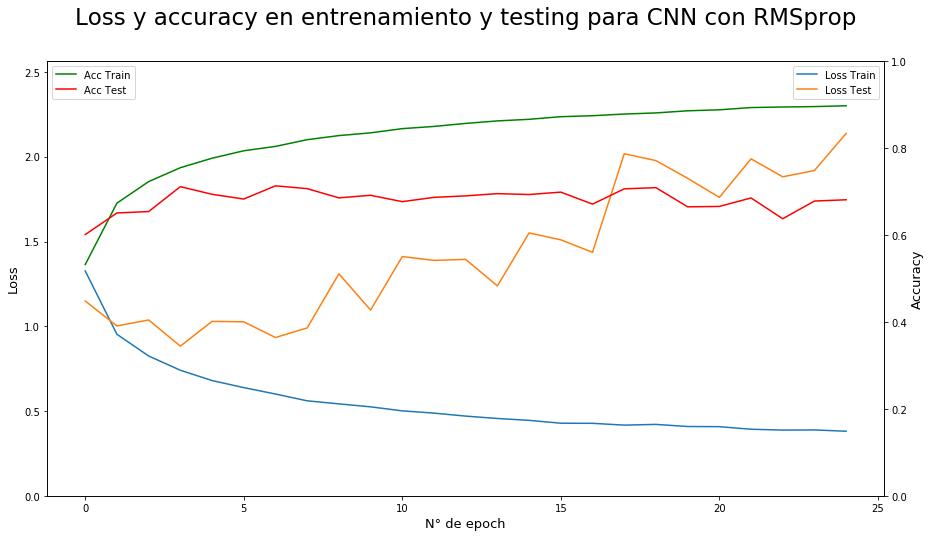

In [38]:
loss_train_rms = cnn_rmsprop.history['loss']
loss_test_rms = cnn_rmsprop.history['val_loss']
acc_train_rms = cnn_rmsprop.history['acc']
acc_test_rms = cnn_rmsprop.history['val_acc']

x = [max(loss_train_rms),max(loss_test_rms)]
valor_maximo = max(x)*1.2

plt.subplots(1, figsize=(15,8))
plt.title("Loss y accuracy en entrenamiento y testing para CNN con RMSprop", fontsize=23, y=1.07)
plt.plot(range(len(loss_train_rms)), loss_train_rms, label="Loss Train")
plt.plot(range(len(loss_test_rms)), loss_test_rms, label="Loss Test")
plt.ylabel('Loss', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymin = 0, ymax=valor_maximo)
plt.legend()

plt.twinx()

plt.plot(range(len(acc_train_rms)), acc_train_rms, label="Acc Train", color = "green")
plt.plot(range(len(acc_test_rms)), acc_test_rms, label="Acc Test", color = "red")
plt.ylim(ymin = 0, ymax=1)
plt.ylabel('Accuracy', fontsize=13)
plt.legend(loc=2)
plt.show()

Del entrenamiento de la red se puede ver como ésta pese a tener un valor de pérdida en entrenamiento más bajo que la red entrenada con SGD, sufre de una alza en el valor de pérdida para validación, esto se traduce en un caso de overfitting ya que la red se adaptó a al dataset de entrenamiento exclusivamente. Esto también está reflejado en un mal accuracy de training que no mejora con los epochs.

## Variación en tamaños de filtro de una CNN
> f) Evalúe el efecto de modificar el tamaño de los filtros (de convolución) reportando la sensibilidad del error de pruebas a estos cambios en dos tipos de arquitecturas, una profunda y otra no. Presente un gráfico o tabla resumen. Por simplicidad entre durante sólo 15-20 *epochs*.

In [20]:
#Shallow network
sw_history = dict()
sw_history['train_loss'] = []
sw_history['test_loss'] = []
sw_history['train_acc'] = []
sw_history['test_acc'] = []

for nc in range(2, 9):
  model = Sequential()
  model.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  
  opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
  lrate = LearningRateScheduler(step_decay)
  model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
  print("Entrenado con nc",nc)
  train_result = model.fit(x_train, y_train,batch_size=batch_size,epochs=20, validation_data=(x_test,y_test), shuffle=True, callbacks=[lrate], verbose=0)
  
  sw_history['train_loss'].append(train_result.history['loss'])
  sw_history['test_loss'].append(train_result.history['val_loss'])
  sw_history['train_acc'].append(train_result.history['acc'])
  sw_history['test_acc'].append(train_result.history['val_acc'])

Entrenado con nc 2
Entrenado con nc 3
Entrenado con nc 4
Entrenado con nc 5
Entrenado con nc 6
Entrenado con nc 7
Entrenado con nc 8


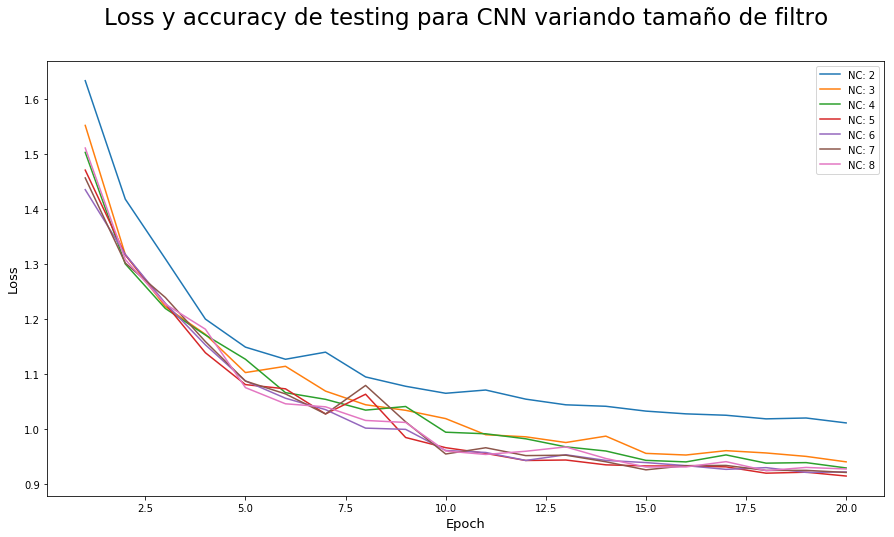

In [29]:
sw_history['test_loss']
sw_history['test_acc']

plt.figure(0, figsize=(15,8))
plt.title("Loss y accuracy de testing para CNN variando tamaño de filtro", fontsize=23, y=1.07)
plt.ylabel('Loss', fontsize=13)
plt.xlabel('Epoch', fontsize=13)
for i in range(2,9):
  plt.plot(np.linspace(1,20,20, endpoint = True),sw_history['test_loss'][i-2], label="NC: "+ str(i))
plt.legend();

Las pruebas realizadas variando el tamaño de los filtros en una red de 1 capa convolucional muestran que los tamaños intermedios tienden a dar resultados marginalmente mejores que los tamaños de filtros más pequeños o más grandes, siendo el tamaño 5 el que entregó un mejor resultado.

In [30]:
#Deep network
dp_history = dict()
dp_history['train_loss'] = []
dp_history['test_loss'] = []
dp_history['train_acc'] = []
dp_history['test_acc'] = []

for nc in range(2,8):
  model = Sequential()
  model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  
  opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
  lrate = LearningRateScheduler(step_decay)
  model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
  print("Entrenado con nc",nc)
  train_result = model.fit(x_train, y_train,batch_size=batch_size,epochs=20, validation_data=(x_test,y_test), shuffle=True, callbacks=[lrate], verbose=0)
  
  dp_history['train_loss'].append(train_result.history['loss'])
  dp_history['test_loss'].append(train_result.history['val_loss'])
  dp_history['train_acc'].append(train_result.history['acc'])
  dp_history['test_acc'].append(train_result.history['val_acc'])

Entrenado con nc 2
Entrenado con nc 3
Entrenado con nc 4
Entrenado con nc 5
Entrenado con nc 6
Entrenado con nc 7


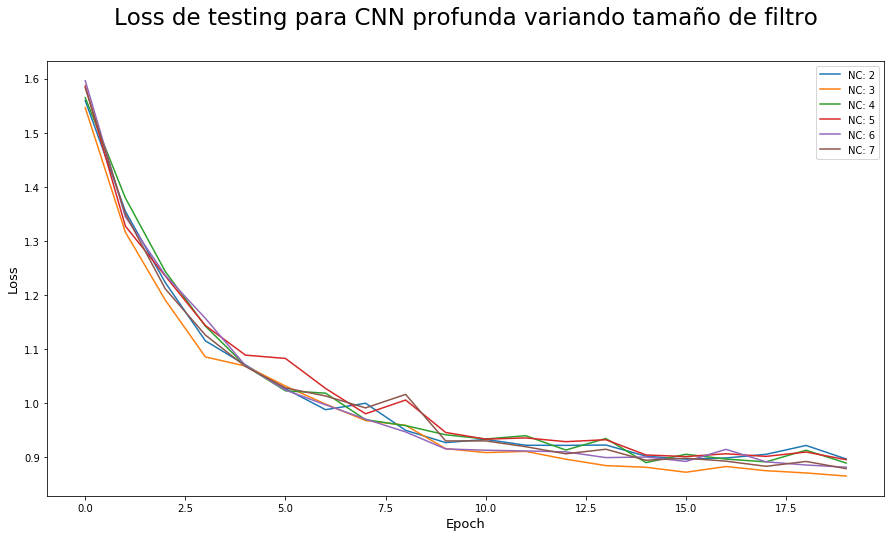

In [34]:
plt.figure(0, figsize=(15,8))
plt.title("Loss de testing para CNN profunda variando tamaño de filtro", fontsize=23, y=1.07)
plt.ylabel('Loss', fontsize=13)
plt.xlabel('Epoch', fontsize=13)
for i in range(2,8):
  plt.plot(dp_history['test_loss'][i-2], label="NC: "+ str(i))
plt.legend()
plt.show()

En el caso de una arquitectura más profunda, con 2 capas convolucionales, la red con mejor rendimiento era la que tenía filtros de tamaño 3, todas las tras opciones no lograron una minimización tan efectiva.

## CNNs Profundas

> g) Se ha sugerido que la práctica bastante habitual de continuar una capa convolucional con una capa de *pooling* puede generar una reducción prematura de las dimensiones del patrón de entrada. Experimente con una arquitectura del tipo $C \times C \times P \times C \times C \times P \times F \times F$. Use 64 filtros para las primeras 2 capas convolucionales y 128 para las últimas dos. Reflexione sobre qué le parece más sensato: ¿mantener el tamaño de los filtros usados anteriormente? o ¿usar filtros más grandes en la segunda capa convolucional y más pequeños en la primera? o ¿usar filtros más pequeños en la segunda capa convolucional y más grandes en la primera? *Hint*: con esta nueva arquitectura debiese superar el 70% de accuracy (de validación/test) antes de 5 epochs, pero la arquitectura es más sensible a overfitting por lo que podrı́a ser conveniente agregar un regularizador. Como resultado final de esta actividad gráficque los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

### Red con tamaños de filtros iguales

In [41]:
# Red con mismos filtros en ambos
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
train_result = model.fit(x_train, y_train,batch_size=batch_size,epochs=25, validation_data=(x_test,y_test), shuffle=True, callbacks=[lrate], verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
17100/50000 [=========>....................] - ETA: 2:57 - loss: 2.1228 - acc: 0.2106

49975/50000 [============================>.] - ETA: 0s - loss: 1.9253 - acc: 0.3024

50000/50000 [==============================] - 274s 5ms/step - loss: 1.9252 - acc: 0.3024 - val_loss: 1.6108 - val_acc: 0.4314
Epoch 2/25
11175/50000 [=====>........................] - ETA: 3:27 - loss: 1.6665 - acc: 0.3983

49975/50000 [============================>.] - ETA: 0s - loss: 1.5763 - acc: 0.4305

50000/50000 [==============================] - 274s 5ms/step - loss: 1.5763 - acc: 0.4305 - val_loss: 1.4304 - val_acc: 0.4891
Epoch 3/25
11175/50000 [=====>........................] - ETA: 3:24 - loss: 1.4609 - acc: 0.4725

49975/50000 [============================>.] - ETA: 0s - loss: 1.4031 - acc: 0.4946

50000/50000 [==============================] - 271s 5ms/step - loss: 1.4032 - acc: 0.4945 - val_loss: 1.2870 - val_acc: 0.5387
Epoch 4/25
11175/50000 [=====>........................] - ETA: 3:23 - loss: 1.3050 - acc: 0.5291

49975/50000 [============================>.] - ETA: 0s - loss: 1.2551 - acc: 0.5497

50000/50000 [==============================] - 271s 5ms/step - loss: 1.2550 - acc: 0.5497 - val_loss: 1.1344 - val_acc: 0.5957
Epoch 5/25
11175/50000 [=====>........................] - ETA: 3:24 - loss: 1.1426 - acc: 0.5957

49975/50000 [============================>.] - ETA: 0s - loss: 1.1281 - acc: 0.5992

50000/50000 [==============================] - 272s 5ms/step - loss: 1.1280 - acc: 0.5992 - val_loss: 1.0650 - val_acc: 0.6188
Epoch 6/25
11175/50000 [=====>........................] - ETA: 3:25 - loss: 1.0772 - acc: 0.6225

49975/50000 [============================>.] - ETA: 0s - loss: 1.0678 - acc: 0.6224

50000/50000 [==============================] - 272s 5ms/step - loss: 1.0678 - acc: 0.6224 - val_loss: 1.0216 - val_acc: 0.6395
Epoch 7/25
11175/50000 [=====>........................] - ETA: 3:24 - loss: 1.0315 - acc: 0.6353

49975/50000 [============================>.] - ETA: 0s - loss: 1.0107 - acc: 0.6422

50000/50000 [==============================] - 272s 5ms/step - loss: 1.0105 - acc: 0.6423 - val_loss: 0.9980 - val_acc: 0.6432
Epoch 8/25
11175/50000 [=====>........................] - ETA: 3:25 - loss: 0.9795 - acc: 0.6511

49975/50000 [============================>.] - ETA: 0s - loss: 0.9618 - acc: 0.6599

50000/50000 [==============================] - 273s 5ms/step - loss: 0.9618 - acc: 0.6599 - val_loss: 0.9336 - val_acc: 0.6719
Epoch 9/25
11175/50000 [=====>........................] - ETA: 3:25 - loss: 0.9136 - acc: 0.6788

49975/50000 [============================>.] - ETA: 0s - loss: 0.9141 - acc: 0.6792

50000/50000 [==============================] - 273s 5ms/step - loss: 0.9141 - acc: 0.6791 - val_loss: 0.9008 - val_acc: 0.6888
Epoch 10/25
11125/50000 [=====>........................] - ETA: 3:25 - loss: 0.8603 - acc: 0.6961

49975/50000 [============================>.] - ETA: 0s - loss: 0.8546 - acc: 0.6993

50000/50000 [==============================] - 273s 5ms/step - loss: 0.8547 - acc: 0.6992 - val_loss: 0.8682 - val_acc: 0.6960
Epoch 11/25
11125/50000 [=====>........................] - ETA: 3:26 - loss: 0.8247 - acc: 0.7108

49975/50000 [============================>.] - ETA: 0s - loss: 0.8293 - acc: 0.7081

50000/50000 [==============================] - 273s 5ms/step - loss: 0.8293 - acc: 0.7081 - val_loss: 0.8456 - val_acc: 0.7049
Epoch 12/25
11125/50000 [=====>........................] - ETA: 3:25 - loss: 0.8116 - acc: 0.7141

49975/50000 [============================>.] - ETA: 0s - loss: 0.8071 - acc: 0.7154

50000/50000 [==============================] - 272s 5ms/step - loss: 0.8071 - acc: 0.7155 - val_loss: 0.8389 - val_acc: 0.7053
Epoch 13/25
11125/50000 [=====>........................] - ETA: 3:25 - loss: 0.7821 - acc: 0.7289

49975/50000 [============================>.] - ETA: 0s - loss: 0.7853 - acc: 0.7244

50000/50000 [==============================] - 274s 5ms/step - loss: 0.7853 - acc: 0.7243 - val_loss: 0.8203 - val_acc: 0.7133
Epoch 14/25
11125/50000 [=====>........................] - ETA: 3:29 - loss: 0.7557 - acc: 0.7311

49975/50000 [============================>.] - ETA: 0s - loss: 0.7633 - acc: 0.7304

50000/50000 [==============================] - 275s 5ms/step - loss: 0.7632 - acc: 0.7304 - val_loss: 0.8196 - val_acc: 0.7143
Epoch 15/25
11125/50000 [=====>........................] - ETA: 3:27 - loss: 0.7262 - acc: 0.7469

44025/50000 [=========================>....] - ETA: 32s - loss: 0.7266 - acc: 0.7449

50000/50000 [==============================] - 281s 6ms/step - loss: 0.7255 - acc: 0.7450 - val_loss: 0.7997 - val_acc: 0.7204
Epoch 16/25
 8875/50000 [====>.........................] - ETA: 3:45 - loss: 0.7238 - acc: 0.7419

44200/50000 [=========================>....] - ETA: 31s - loss: 0.7183 - acc: 0.7477

50000/50000 [==============================] - 284s 6ms/step - loss: 0.7169 - acc: 0.7484 - val_loss: 0.7953 - val_acc: 0.7246
Epoch 17/25
 8975/50000 [====>.........................] - ETA: 3:45 - loss: 0.7064 - acc: 0.7554

49975/50000 [============================>.] - ETA: 0s - loss: 0.7048 - acc: 0.7519

50000/50000 [==============================] - 284s 6ms/step - loss: 0.7048 - acc: 0.7518 - val_loss: 0.7878 - val_acc: 0.7277
Epoch 18/25
11100/50000 [=====>........................] - ETA: 3:33 - loss: 0.7069 - acc: 0.7519

49975/50000 [============================>.] - ETA: 0s - loss: 0.6954 - acc: 0.7570

50000/50000 [==============================] - 284s 6ms/step - loss: 0.6954 - acc: 0.7570 - val_loss: 0.7834 - val_acc: 0.7300
Epoch 19/25
11125/50000 [=====>........................] - ETA: 3:27 - loss: 0.6761 - acc: 0.7637

49975/50000 [============================>.] - ETA: 0s - loss: 0.6830 - acc: 0.7626

50000/50000 [==============================] - 272s 5ms/step - loss: 0.6829 - acc: 0.7627 - val_loss: 0.7750 - val_acc: 0.7318
Epoch 20/25
11125/50000 [=====>........................] - ETA: 3:24 - loss: 0.6672 - acc: 0.7676

49975/50000 [============================>.] - ETA: 0s - loss: 0.6652 - acc: 0.7666

50000/50000 [==============================] - 270s 5ms/step - loss: 0.6653 - acc: 0.7666 - val_loss: 0.7705 - val_acc: 0.7328
Epoch 21/25
11125/50000 [=====>........................] - ETA: 3:23 - loss: 0.6622 - acc: 0.7684

49975/50000 [============================>.] - ETA: 0s - loss: 0.6607 - acc: 0.7691

50000/50000 [==============================] - 270s 5ms/step - loss: 0.6607 - acc: 0.7691 - val_loss: 0.7695 - val_acc: 0.7337
Epoch 22/25
11125/50000 [=====>........................] - ETA: 3:23 - loss: 0.6594 - acc: 0.7721

49975/50000 [============================>.] - ETA: 0s - loss: 0.6553 - acc: 0.7709

50000/50000 [==============================] - 270s 5ms/step - loss: 0.6554 - acc: 0.7708 - val_loss: 0.7645 - val_acc: 0.7360
Epoch 23/25
11125/50000 [=====>........................] - ETA: 3:23 - loss: 0.6440 - acc: 0.7747

49975/50000 [============================>.] - ETA: 0s - loss: 0.6505 - acc: 0.7735

50000/50000 [==============================] - 270s 5ms/step - loss: 0.6504 - acc: 0.7735 - val_loss: 0.7737 - val_acc: 0.7326
Epoch 24/25
11125/50000 [=====>........................] - ETA: 3:23 - loss: 0.6524 - acc: 0.7711

49975/50000 [============================>.] - ETA: 0s - loss: 0.6453 - acc: 0.7749

50000/50000 [==============================] - 269s 5ms/step - loss: 0.6454 - acc: 0.7749 - val_loss: 0.7614 - val_acc: 0.7344
Epoch 25/25
11125/50000 [=====>........................] - ETA: 3:23 - loss: 0.6344 - acc: 0.7804

49975/50000 [============================>.] - ETA: 0s - loss: 0.6362 - acc: 0.7786

50000/50000 [==============================] - 269s 5ms/step - loss: 0.6362 - acc: 0.7786 - val_loss: 0.7645 - val_acc: 0.7350


### Red con filtros 3x3 y 5x5

In [42]:
# Red con filtro mas grande en segundo
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5, 5), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
train_result_sb = model.fit(x_train, y_train,batch_size=batch_size,epochs=25, validation_data=(x_test,y_test), shuffle=True, callbacks=[lrate], verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
 8850/50000 [====>.........................] - ETA: 5:06 - loss: 2.2605 - acc: 0.1428

22300/50000 [============>.................] - ETA: 3:23 - loss: 2.1020 - acc: 0.2219

35725/50000 [====================>.........] - ETA: 1:44 - loss: 1.9903 - acc: 0.2692

49250/50000 [============================>.] - ETA: 5s - loss: 1.8998 - acc: 0.3052

50000/50000 [==============================] - 379s 8ms/step - loss: 1.8958 - acc: 0.3068 - val_loss: 1.5405 - val_acc: 0.4439
Epoch 2/25
 5800/50000 [==>...........................] - ETA: 5:21 - loss: 1.6162 - acc: 0.4117

19150/50000 [==========>...................] - ETA: 3:44 - loss: 1.5755 - acc: 0.4252

32525/50000 [==================>...........] - ETA: 2:07 - loss: 1.5423 - acc: 0.4389

45875/50000 [==========================>...] - ETA: 30s - loss: 1.5133 - acc: 0.4508

50000/50000 [==============================] - 377s 8ms/step - loss: 1.5040 - acc: 0.4542 - val_loss: 1.3565 - val_acc: 0.5146
Epoch 3/25
 4200/50000 [=>............................] - ETA: 5:32 - loss: 1.3721 - acc: 0.5005

17375/50000 [=========>....................] - ETA: 3:57 - loss: 1.3628 - acc: 0.5098

30700/50000 [=================>............] - ETA: 2:20 - loss: 1.3419 - acc: 0.5184

44125/50000 [=========================>....] - ETA: 42s - loss: 1.3244 - acc: 0.5255

50000/50000 [==============================] - 377s 8ms/step - loss: 1.3179 - acc: 0.5275 - val_loss: 1.1998 - val_acc: 0.5772
Epoch 4/25
 3425/50000 [=>............................] - ETA: 5:39 - loss: 1.1675 - acc: 0.5728

16650/50000 [========>.....................] - ETA: 4:02 - loss: 1.2095 - acc: 0.5677

29875/50000 [================>.............] - ETA: 2:26 - loss: 1.1986 - acc: 0.5736

43150/50000 [========================>.....] - ETA: 49s - loss: 1.1846 - acc: 0.5781

50000/50000 [==============================] - 377s 8ms/step - loss: 1.1765 - acc: 0.5808 - val_loss: 1.1067 - val_acc: 0.6033
Epoch 5/25
 2950/50000 [>.............................] - ETA: 5:41 - loss: 1.0797 - acc: 0.6234

16275/50000 [========>.....................] - ETA: 4:05 - loss: 1.0509 - acc: 0.6339

29425/50000 [================>.............] - ETA: 2:29 - loss: 1.0451 - acc: 0.6343

42525/50000 [========================>.....] - ETA: 54s - loss: 1.0486 - acc: 0.6305

50000/50000 [==============================] - 377s 8ms/step - loss: 1.0420 - acc: 0.6314 - val_loss: 0.9924 - val_acc: 0.6468
Epoch 6/25
 2725/50000 [>.............................] - ETA: 5:44 - loss: 0.9954 - acc: 0.6440

16300/50000 [========>.....................] - ETA: 4:05 - loss: 0.9797 - acc: 0.6552

29425/50000 [================>.............] - ETA: 2:29 - loss: 0.9853 - acc: 0.6525

42800/50000 [========================>.....] - ETA: 52s - loss: 0.9806 - acc: 0.6541

50000/50000 [==============================] - 378s 8ms/step - loss: 0.9774 - acc: 0.6551 - val_loss: 0.9516 - val_acc: 0.6640
Epoch 7/25
 2725/50000 [>.............................] - ETA: 5:43 - loss: 0.9022 - acc: 0.6906

16475/50000 [========>.....................] - ETA: 4:04 - loss: 0.9257 - acc: 0.6750

30925/50000 [=================>............] - ETA: 2:18 - loss: 0.9251 - acc: 0.6762

45450/50000 [==========================>...] - ETA: 32s - loss: 0.9227 - acc: 0.6745

50000/50000 [==============================] - 376s 8ms/step - loss: 0.9211 - acc: 0.6750 - val_loss: 0.9034 - val_acc: 0.6782
Epoch 8/25
 4450/50000 [=>............................] - ETA: 5:28 - loss: 0.8416 - acc: 0.7072

18975/50000 [==========>...................] - ETA: 3:43 - loss: 0.8633 - acc: 0.6969

33275/50000 [==================>...........] - ETA: 2:00 - loss: 0.8699 - acc: 0.6948

47675/50000 [===========================>..] - ETA: 16s - loss: 0.8713 - acc: 0.6943

50000/50000 [==============================] - 374s 7ms/step - loss: 0.8693 - acc: 0.6948 - val_loss: 0.8767 - val_acc: 0.6901
Epoch 9/25
 5550/50000 [==>...........................] - ETA: 5:20 - loss: 0.8100 - acc: 0.7124

20025/50000 [===========>..................] - ETA: 3:36 - loss: 0.8314 - acc: 0.7074

34625/50000 [===================>..........] - ETA: 1:50 - loss: 0.8332 - acc: 0.7081

49500/50000 [============================>.] - ETA: 3s - loss: 0.8275 - acc: 0.7100

50000/50000 [==============================] - 374s 7ms/step - loss: 0.8274 - acc: 0.7101 - val_loss: 0.8319 - val_acc: 0.7091
Epoch 10/25
 6575/50000 [==>...........................] - ETA: 5:11 - loss: 0.7627 - acc: 0.7285

22025/50000 [============>.................] - ETA: 3:20 - loss: 0.7590 - acc: 0.7305

37650/50000 [=====================>........] - ETA: 1:28 - loss: 0.7614 - acc: 0.7337

50000/50000 [==============================] - 372s 7ms/step - loss: 0.7642 - acc: 0.7327 - val_loss: 0.8069 - val_acc: 0.7192
Epoch 11/25
 1425/50000 [..............................] - ETA: 5:49 - loss: 0.7321 - acc: 0.7333

17025/50000 [=========>....................] - ETA: 3:56 - loss: 0.7484 - acc: 0.7392

32400/50000 [==================>...........] - ETA: 2:06 - loss: 0.7395 - acc: 0.7411

48025/50000 [===========================>..] - ETA: 14s - loss: 0.7374 - acc: 0.7409

50000/50000 [==============================] - 372s 7ms/step - loss: 0.7368 - acc: 0.7413 - val_loss: 0.7927 - val_acc: 0.7218
Epoch 12/25
 5950/50000 [==>...........................] - ETA: 5:15 - loss: 0.7200 - acc: 0.7513

21100/50000 [===========>..................] - ETA: 3:27 - loss: 0.7279 - acc: 0.7467

35925/50000 [====================>.........] - ETA: 1:41 - loss: 0.7206 - acc: 0.7481

50000/50000 [==============================] - 373s 7ms/step - loss: 0.7156 - acc: 0.7494 - val_loss: 0.7877 - val_acc: 0.7246
Epoch 13/25
  550/50000 [..............................] - ETA: 5:55 - loss: 0.6920 - acc: 0.7436

15900/50000 [========>.....................] - ETA: 4:04 - loss: 0.6905 - acc: 0.7577

31300/50000 [=================>............] - ETA: 2:14 - loss: 0.6888 - acc: 0.7604

46275/50000 [==========================>...] - ETA: 26s - loss: 0.6927 - acc: 0.7575

50000/50000 [==============================] - 373s 7ms/step - loss: 0.6911 - acc: 0.7576 - val_loss: 0.7909 - val_acc: 0.7244
Epoch 14/25
 5050/50000 [==>...........................] - ETA: 5:22 - loss: 0.6563 - acc: 0.7711

20500/50000 [===========>..................] - ETA: 3:31 - loss: 0.6643 - acc: 0.7688

35600/50000 [====================>.........] - ETA: 1:43 - loss: 0.6673 - acc: 0.7679

50000/50000 [==============================] - 373s 7ms/step - loss: 0.6688 - acc: 0.7663 - val_loss: 0.7693 - val_acc: 0.7287
Epoch 15/25
  425/50000 [..............................] - ETA: 5:58 - loss: 0.6932 - acc: 0.7506

15500/50000 [========>.....................] - ETA: 4:07 - loss: 0.6507 - acc: 0.7732

30375/50000 [=================>............] - ETA: 2:21 - loss: 0.6361 - acc: 0.7777

45550/50000 [==========================>...] - ETA: 31s - loss: 0.6333 - acc: 0.7785

50000/50000 [==============================] - 373s 7ms/step - loss: 0.6338 - acc: 0.7785 - val_loss: 0.7516 - val_acc: 0.7365
Epoch 16/25
 4650/50000 [=>............................] - ETA: 5:26 - loss: 0.6182 - acc: 0.7841

19700/50000 [==========>...................] - ETA: 3:37 - loss: 0.6185 - acc: 0.7845

34750/50000 [===================>..........] - ETA: 1:49 - loss: 0.6236 - acc: 0.7821

49950/50000 [============================>.] - ETA: 0s - loss: 0.6210 - acc: 0.7823

50000/50000 [==============================] - 373s 7ms/step - loss: 0.6211 - acc: 0.7823 - val_loss: 0.7446 - val_acc: 0.7363
Epoch 17/25
 6775/50000 [===>..........................] - ETA: 5:10 - loss: 0.5995 - acc: 0.7919

21750/50000 [============>.................] - ETA: 3:22 - loss: 0.5988 - acc: 0.7905

37075/50000 [=====================>........] - ETA: 1:32 - loss: 0.6033 - acc: 0.7880

50000/50000 [==============================] - 373s 7ms/step - loss: 0.6059 - acc: 0.7871 - val_loss: 0.7464 - val_acc: 0.7366
Epoch 18/25
 1025/50000 [..............................] - ETA: 5:52 - loss: 0.5967 - acc: 0.7844

16250/50000 [========>.....................] - ETA: 4:02 - loss: 0.5930 - acc: 0.7910

31550/50000 [=================>............] - ETA: 2:12 - loss: 0.5950 - acc: 0.7913

46775/50000 [===========================>..] - ETA: 23s - loss: 0.5985 - acc: 0.7902

50000/50000 [==============================] - 373s 7ms/step - loss: 0.5979 - acc: 0.7910 - val_loss: 0.7415 - val_acc: 0.7445
Epoch 19/25
 5450/50000 [==>...........................] - ETA: 5:19 - loss: 0.5842 - acc: 0.7930

20875/50000 [===========>..................] - ETA: 3:29 - loss: 0.5896 - acc: 0.7899

36075/50000 [====================>.........] - ETA: 1:39 - loss: 0.5899 - acc: 0.7914

50000/50000 [==============================] - 373s 7ms/step - loss: 0.5873 - acc: 0.7931 - val_loss: 0.7372 - val_acc: 0.7449
Epoch 20/25
  625/50000 [..............................] - ETA: 5:55 - loss: 0.5299 - acc: 0.8144

16050/50000 [========>.....................] - ETA: 4:03 - loss: 0.5662 - acc: 0.8007

31475/50000 [=================>............] - ETA: 2:13 - loss: 0.5605 - acc: 0.8028

46850/50000 [===========================>..] - ETA: 22s - loss: 0.5651 - acc: 0.8016

50000/50000 [==============================] - 373s 7ms/step - loss: 0.5656 - acc: 0.8014 - val_loss: 0.7309 - val_acc: 0.7466
Epoch 21/25
 5200/50000 [==>...........................] - ETA: 5:22 - loss: 0.5501 - acc: 0.8079

20375/50000 [===========>..................] - ETA: 3:32 - loss: 0.5674 - acc: 0.8027

35575/50000 [====================>.........] - ETA: 1:43 - loss: 0.5603 - acc: 0.8056

50000/50000 [==============================] - 373s 7ms/step - loss: 0.5593 - acc: 0.8059 - val_loss: 0.7276 - val_acc: 0.7480
Epoch 22/25
  350/50000 [..............................] - ETA: 5:56 - loss: 0.5202 - acc: 0.8171

15650/50000 [========>.....................] - ETA: 4:06 - loss: 0.5514 - acc: 0.8094

30775/50000 [=================>............] - ETA: 2:18 - loss: 0.5562 - acc: 0.8068

45750/50000 [==========================>...] - ETA: 30s - loss: 0.5551 - acc: 0.8061

50000/50000 [==============================] - 373s 7ms/step - loss: 0.5533 - acc: 0.8063 - val_loss: 0.7252 - val_acc: 0.7477
Epoch 23/25
 4725/50000 [=>............................] - ETA: 5:26 - loss: 0.5296 - acc: 0.8224

18900/50000 [==========>...................] - ETA: 3:44 - loss: 0.5426 - acc: 0.8107

32625/50000 [==================>...........] - ETA: 2:05 - loss: 0.5481 - acc: 0.8095

45225/50000 [==========================>...] - ETA: 34s - loss: 0.5484 - acc: 0.8098

50000/50000 [==============================] - 377s 8ms/step - loss: 0.5484 - acc: 0.8097 - val_loss: 0.7323 - val_acc: 0.7471
Epoch 24/25
 3875/50000 [=>............................] - ETA: 5:36 - loss: 0.5432 - acc: 0.8067

16900/50000 [=========>....................] - ETA: 4:01 - loss: 0.5556 - acc: 0.8042

29875/50000 [================>.............] - ETA: 2:27 - loss: 0.5505 - acc: 0.8070

43225/50000 [========================>.....] - ETA: 49s - loss: 0.5465 - acc: 0.8086

50000/50000 [==============================] - 379s 8ms/step - loss: 0.5439 - acc: 0.8091 - val_loss: 0.7273 - val_acc: 0.7507
Epoch 25/25
 3100/50000 [>.............................] - ETA: 5:41 - loss: 0.5209 - acc: 0.8119

16225/50000 [========>.....................] - ETA: 4:06 - loss: 0.5312 - acc: 0.8154

29200/50000 [================>.............] - ETA: 2:31 - loss: 0.5307 - acc: 0.8167

42475/50000 [========================>.....] - ETA: 54s - loss: 0.5311 - acc: 0.8159

50000/50000 [==============================] - 378s 8ms/step - loss: 0.5324 - acc: 0.8147 - val_loss: 0.7196 - val_acc: 0.7514


### Red con filtro 5x5 y 3x3

In [43]:
# Red con filtro mas chico en segundo
model = Sequential()
model.add(Conv2D(64, (5, 5), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
train_result_bsm = model.fit(x_train, y_train,batch_size=batch_size,epochs=25, validation_data=(x_test,y_test), shuffle=True, callbacks=[lrate], verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
12750/50000 [======>.......................] - ETA: 5:08 - loss: 2.1749 - acc: 0.1824

31500/50000 [=================>............] - ETA: 2:31 - loss: 2.0106 - acc: 0.2632

49850/50000 [============================>.] - ETA: 1s - loss: 1.9014 - acc: 0.3068

50000/50000 [==============================] - 422s 8ms/step - loss: 1.9008 - acc: 0.3071 - val_loss: 1.6066 - val_acc: 0.4240
Epoch 2/25
 8350/50000 [====>.........................] - ETA: 5:39 - loss: 1.6355 - acc: 0.4057

26900/50000 [===============>..............] - ETA: 3:08 - loss: 1.6014 - acc: 0.4221

46700/50000 [===========================>..] - ETA: 26s - loss: 1.5586 - acc: 0.4388

50000/50000 [==============================] - 420s 8ms/step - loss: 1.5546 - acc: 0.4402 - val_loss: 1.4201 - val_acc: 0.4906
Epoch 3/25
 6525/50000 [==>...........................] - ETA: 5:53 - loss: 1.4303 - acc: 0.4774

26600/50000 [==============>...............] - ETA: 3:11 - loss: 1.4132 - acc: 0.4869

46425/50000 [==========================>...] - ETA: 29s - loss: 1.3910 - acc: 0.4968

50000/50000 [==============================] - 425s 8ms/step - loss: 1.3843 - acc: 0.4992 - val_loss: 1.2520 - val_acc: 0.5492
Epoch 4/25
 7000/50000 [===>..........................] - ETA: 5:56 - loss: 1.2878 - acc: 0.5379

25450/50000 [==============>...............] - ETA: 3:23 - loss: 1.2668 - acc: 0.5477

44175/50000 [=========================>....] - ETA: 48s - loss: 1.2542 - acc: 0.5512

50000/50000 [==============================] - 428s 9ms/step - loss: 1.2491 - acc: 0.5533 - val_loss: 1.2058 - val_acc: 0.5638
Epoch 5/25
 5500/50000 [==>...........................] - ETA: 6:09 - loss: 1.1265 - acc: 0.5942

24875/50000 [=============>................] - ETA: 3:28 - loss: 1.1338 - acc: 0.5981

44100/50000 [=========================>....] - ETA: 48s - loss: 1.1281 - acc: 0.5980

50000/50000 [==============================] - 429s 9ms/step - loss: 1.1246 - acc: 0.5997 - val_loss: 1.0734 - val_acc: 0.6184
Epoch 6/25
 5350/50000 [==>...........................] - ETA: 6:10 - loss: 1.0832 - acc: 0.6131

22925/50000 [============>.................] - ETA: 3:44 - loss: 1.0730 - acc: 0.6159

40925/50000 [=======================>......] - ETA: 1:15 - loss: 1.0718 - acc: 0.6175

50000/50000 [==============================] - 429s 9ms/step - loss: 1.0688 - acc: 0.6188 - val_loss: 1.0147 - val_acc: 0.6468
Epoch 7/25
 4325/50000 [=>............................] - ETA: 6:21 - loss: 1.0429 - acc: 0.6280

22275/50000 [============>.................] - ETA: 3:49 - loss: 1.0252 - acc: 0.6354

40525/50000 [=======================>......] - ETA: 1:18 - loss: 1.0135 - acc: 0.6414

50000/50000 [==============================] - 429s 9ms/step - loss: 1.0107 - acc: 0.6424 - val_loss: 0.9988 - val_acc: 0.6491
Epoch 8/25
 3900/50000 [=>............................] - ETA: 6:21 - loss: 0.9618 - acc: 0.6508

21500/50000 [===========>..................] - ETA: 3:56 - loss: 0.9700 - acc: 0.6575

39025/50000 [======================>.......] - ETA: 1:30 - loss: 0.9593 - acc: 0.6619

50000/50000 [==============================] - 429s 9ms/step - loss: 0.9550 - acc: 0.6634 - val_loss: 0.9466 - val_acc: 0.6689
Epoch 9/25
 3300/50000 [>.............................] - ETA: 6:25 - loss: 0.9064 - acc: 0.6739

20950/50000 [===========>..................] - ETA: 4:00 - loss: 0.9150 - acc: 0.6786

39125/50000 [======================>.......] - ETA: 1:30 - loss: 0.9092 - acc: 0.6800

50000/50000 [==============================] - 428s 9ms/step - loss: 0.9066 - acc: 0.6805 - val_loss: 0.9070 - val_acc: 0.6858
Epoch 10/25
 3300/50000 [>.............................] - ETA: 6:29 - loss: 0.8207 - acc: 0.7088

21125/50000 [===========>..................] - ETA: 3:59 - loss: 0.8472 - acc: 0.7027

39325/50000 [======================>.......] - ETA: 1:28 - loss: 0.8395 - acc: 0.7050

50000/50000 [==============================] - 430s 9ms/step - loss: 0.8387 - acc: 0.7047 - val_loss: 0.8701 - val_acc: 0.6982
Epoch 11/25
 3675/50000 [=>............................] - ETA: 6:24 - loss: 0.8196 - acc: 0.7146

22075/50000 [============>.................] - ETA: 3:51 - loss: 0.8162 - acc: 0.7118

39825/50000 [======================>.......] - ETA: 1:24 - loss: 0.8082 - acc: 0.7141

50000/50000 [==============================] - 428s 9ms/step - loss: 0.8099 - acc: 0.7134 - val_loss: 0.8695 - val_acc: 0.6969
Epoch 12/25
 2475/50000 [>.............................] - ETA: 6:24 - loss: 0.7690 - acc: 0.7281

17700/50000 [=========>....................] - ETA: 4:21 - loss: 0.7850 - acc: 0.7232

33125/50000 [==================>...........] - ETA: 2:16 - loss: 0.7891 - acc: 0.7224

48300/50000 [===========================>..] - ETA: 13s - loss: 0.7865 - acc: 0.7235

50000/50000 [==============================] - 417s 8ms/step - loss: 0.7848 - acc: 0.7238 - val_loss: 0.8497 - val_acc: 0.7037
Epoch 13/25
 5725/50000 [==>...........................] - ETA: 5:56 - loss: 0.7788 - acc: 0.7263

19950/50000 [==========>...................] - ETA: 4:02 - loss: 0.7642 - acc: 0.7295

33950/50000 [===================>..........] - ETA: 2:09 - loss: 0.7644 - acc: 0.7309

50000/50000 [==============================] - 417s 8ms/step - loss: 0.7626 - acc: 0.7317 - val_loss: 0.8304 - val_acc: 0.7128
Epoch 14/25
  875/50000 [..............................] - ETA: 6:44 - loss: 0.7151 - acc: 0.7646

21600/50000 [===========>..................] - ETA: 3:51 - loss: 0.7370 - acc: 0.7434

40375/50000 [=======================>......] - ETA: 1:18 - loss: 0.7365 - acc: 0.7443

50000/50000 [==============================] - 421s 8ms/step - loss: 0.7410 - acc: 0.7428 - val_loss: 0.8225 - val_acc: 0.7127
Epoch 15/25
 4750/50000 [=>............................] - ETA: 6:09 - loss: 0.7281 - acc: 0.7413

23825/50000 [=============>................] - ETA: 3:33 - loss: 0.7109 - acc: 0.7525

40775/50000 [=======================>......] - ETA: 1:15 - loss: 0.7102 - acc: 0.7516

50000/50000 [==============================] - 419s 8ms/step - loss: 0.7087 - acc: 0.7516 - val_loss: 0.8041 - val_acc: 0.7230
Epoch 16/25
 2525/50000 [>.............................] - ETA: 6:24 - loss: 0.7150 - acc: 0.7418

16475/50000 [========>.....................] - ETA: 4:30 - loss: 0.6965 - acc: 0.7533

30600/50000 [=================>............] - ETA: 2:36 - loss: 0.6894 - acc: 0.7550

47000/50000 [===========================>..] - ETA: 24s - loss: 0.6917 - acc: 0.7559

50000/50000 [==============================] - 417s 8ms/step - loss: 0.6907 - acc: 0.7563 - val_loss: 0.7954 - val_acc: 0.7255
Epoch 17/25
 6000/50000 [==>...........................] - ETA: 5:58 - loss: 0.7104 - acc: 0.7497

22900/50000 [============>.................] - ETA: 3:40 - loss: 0.6846 - acc: 0.7579

38700/50000 [======================>.......] - ETA: 1:31 - loss: 0.6858 - acc: 0.7577

50000/50000 [==============================] - 419s 8ms/step - loss: 0.6797 - acc: 0.7603 - val_loss: 0.7939 - val_acc: 0.7267
Epoch 18/25
 3125/50000 [>.............................] - ETA: 6:21 - loss: 0.6601 - acc: 0.7674

19300/50000 [==========>...................] - ETA: 4:08 - loss: 0.6657 - acc: 0.7668

33050/50000 [==================>...........] - ETA: 2:16 - loss: 0.6725 - acc: 0.7642

49100/50000 [============================>.] - ETA: 7s - loss: 0.6708 - acc: 0.7647

50000/50000 [==============================] - 418s 8ms/step - loss: 0.6714 - acc: 0.7645 - val_loss: 0.7932 - val_acc: 0.7256
Epoch 19/25
 6900/50000 [===>..........................] - ETA: 5:49 - loss: 0.6669 - acc: 0.7616

27300/50000 [===============>..............] - ETA: 3:04 - loss: 0.6666 - acc: 0.7648

43000/50000 [========================>.....] - ETA: 56s - loss: 0.6617 - acc: 0.7669

50000/50000 [==============================] - 419s 8ms/step - loss: 0.6609 - acc: 0.7667 - val_loss: 0.7804 - val_acc: 0.7283
Epoch 20/25
 3650/50000 [=>............................] - ETA: 6:14 - loss: 0.6200 - acc: 0.7816

23775/50000 [=============>................] - ETA: 3:33 - loss: 0.6401 - acc: 0.7750

45175/50000 [==========================>...] - ETA: 39s - loss: 0.6404 - acc: 0.7756

50000/50000 [==============================] - 420s 8ms/step - loss: 0.6385 - acc: 0.7762 - val_loss: 0.7749 - val_acc: 0.7328
Epoch 21/25
 5375/50000 [==>...........................] - ETA: 6:03 - loss: 0.6257 - acc: 0.7823

23675/50000 [=============>................] - ETA: 3:34 - loss: 0.6312 - acc: 0.7799

43850/50000 [=========================>....] - ETA: 50s - loss: 0.6302 - acc: 0.7796

50000/50000 [==============================] - 419s 8ms/step - loss: 0.6328 - acc: 0.7788 - val_loss: 0.7724 - val_acc: 0.7348
Epoch 22/25
 5900/50000 [==>...........................] - ETA: 5:58 - loss: 0.6387 - acc: 0.7805

26175/50000 [==============>...............] - ETA: 3:13 - loss: 0.6244 - acc: 0.7825

43975/50000 [=========================>....] - ETA: 49s - loss: 0.6254 - acc: 0.7811

50000/50000 [==============================] - 419s 8ms/step - loss: 0.6262 - acc: 0.7809 - val_loss: 0.7700 - val_acc: 0.7357
Epoch 23/25
 3675/50000 [=>............................] - ETA: 6:15 - loss: 0.6197 - acc: 0.7831

22125/50000 [============>.................] - ETA: 3:46 - loss: 0.6140 - acc: 0.7849

42050/50000 [========================>.....] - ETA: 1:04 - loss: 0.6206 - acc: 0.7808

50000/50000 [==============================] - 420s 8ms/step - loss: 0.6198 - acc: 0.7814 - val_loss: 0.7701 - val_acc: 0.7368
Epoch 24/25
 4500/50000 [=>............................] - ETA: 6:10 - loss: 0.6292 - acc: 0.7769

22575/50000 [============>.................] - ETA: 3:42 - loss: 0.6101 - acc: 0.7874

41700/50000 [========================>.....] - ETA: 1:07 - loss: 0.6121 - acc: 0.7855

50000/50000 [==============================] - 420s 8ms/step - loss: 0.6126 - acc: 0.7848 - val_loss: 0.7655 - val_acc: 0.7370
Epoch 25/25
 4450/50000 [=>............................] - ETA: 6:11 - loss: 0.5919 - acc: 0.7998

22550/50000 [============>.................] - ETA: 3:43 - loss: 0.6007 - acc: 0.7917

41475/50000 [=======================>......] - ETA: 1:09 - loss: 0.6017 - acc: 0.7908

50000/50000 [==============================] - 420s 8ms/step - loss: 0.6025 - acc: 0.7900 - val_loss: 0.7686 - val_acc: 0.7353


### Resultados del entrenamiento de las 3 redes

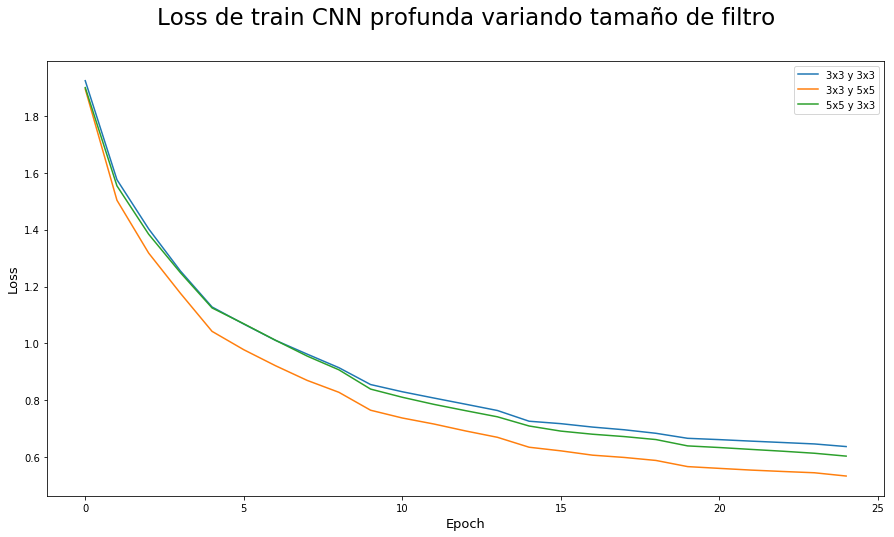

In [57]:
plt.figure(0, figsize=(15,8))
plt.title("Loss de train CNN profunda variando tamaño de filtro", fontsize=23, y=1.07)
plt.ylabel('Loss', fontsize=13)
plt.xlabel('Epoch', fontsize=13)
plt.plot(train_result.history['loss'], label="3x3 y 3x3")
plt.plot(train_result_sb.history['loss'], label="3x3 y 5x5")
plt.plot(train_result_bsm.history['loss'], label="5x5 y 3x3")
plt.legend()
plt.show();

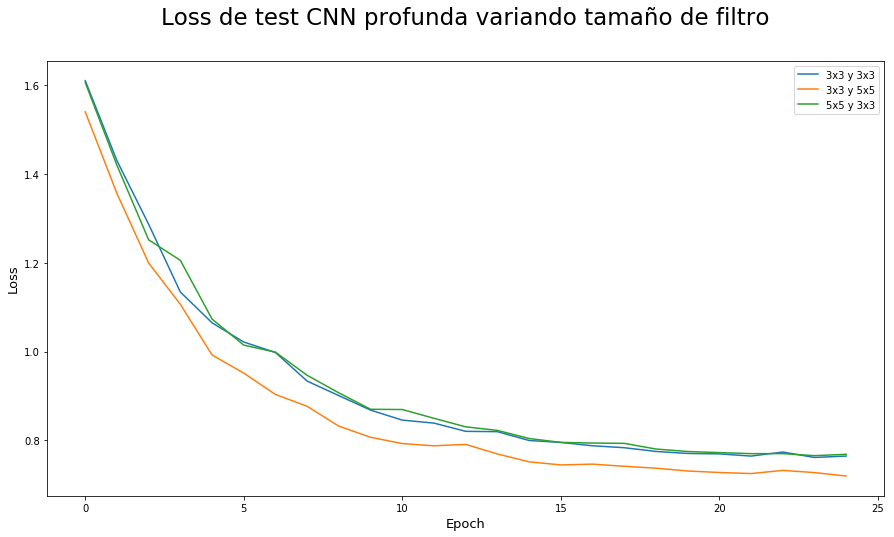

In [58]:
plt.figure(0, figsize=(15,8))
plt.title("Loss de test CNN profunda variando tamaño de filtro", fontsize=23, y=1.07)
plt.ylabel('Loss', fontsize=13)
plt.xlabel('Epoch', fontsize=13)
plt.plot(train_result.history['val_loss'], label="3x3 y 3x3")
plt.plot(train_result_sb.history['val_loss'], label="3x3 y 5x5")
plt.plot(train_result_bsm.history['val_loss'], label="5x5 y 3x3")
plt.legend()
plt.show();

Se entrenaron 3 redes profundas, la primera con ambos filtros de tamaño 3, la segunda con filtros de la primera capa de tamaño 3 y 5 en la última, y la tercera CNN con filtros de tamaño 5 en la primera capa y 3 en la última por un total de 7 horas y media.

Tras el entrenamiento se puede ver cómo la red de tamaños 3 y 5 fue la que mejor rendimiento tuvo tras el entrenamiento tanto en la función de pérdida evaluada durante el entrenamiento y durante la validación, mientras que las otras dos redes tuvieron un comportamiento similar.

## Remplazo de Pooling por Strides en CNNs

> h) Algunos investigadores, han propuesto que las capas de *pooling* se pueden reemplazar por capas convoluciones con stride 2. ¿Se reduce dimensionalidad de este modo? Compruébelo verificando los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un *forward-pass*. Entrene la red resultante con el método que prefiera, gráficando los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

### Red con Pooling

In [7]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
train_pool = model.fit(x_train, y_train,batch_size=batch_size,epochs=25, validation_data=(x_test,y_test), shuffle=True, callbacks=[lrate], verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 22s 442us/step - loss: 1.8267 - acc: 0.3466 - val_loss: 1.5343 - val_acc: 0.4487
Epoch 2/25
28875/50000 [================>.............] - ETA: 7s - loss: 1.4572 - acc: 0.4807

50000/50000 [==============================] - 19s 378us/step - loss: 1.4135 - acc: 0.4967 - val_loss: 1.3196 - val_acc: 0.5277
Epoch 3/25
50000/50000 [==============================] - 19s 384us/step - loss: 1.2410 - acc: 0.5636 - val_loss: 1.2481 - val_acc: 0.5629
Epoch 4/25
 6000/50000 [==>...........................] - ETA: 15s - loss: 1.1526 - acc: 0.5967

50000/50000 [==============================] - 20s 405us/step - loss: 1.1291 - acc: 0.6026 - val_loss: 1.1415 - val_acc: 0.6014
Epoch 5/25
50000/50000 [==============================] - 19s 377us/step - loss: 1.0114 - acc: 0.6487 - val_loss: 1.0434 - val_acc: 0.6351
Epoch 6/25
  825/50000 [..............................] - ETA: 16s - loss: 1.0549 - acc: 0.6352

50000/50000 [==============================] - 19s 375us/step - loss: 0.9616 - acc: 0.6671 - val_loss: 1.0261 - val_acc: 0.6455
Epoch 7/25
50000/50000 [==============================] - 19s 375us/step - loss: 0.9169 - acc: 0.6833 - val_loss: 1.0060 - val_acc: 0.6478
Epoch 8/25
   25/50000 [..............................] - ETA: 20s - loss: 0.8842 - acc: 0.7200

50000/50000 [==============================] - 18s 369us/step - loss: 0.8721 - acc: 0.7003 - val_loss: 0.9628 - val_acc: 0.6670
Epoch 9/25
50000/50000 [==============================] - 19s 371us/step - loss: 0.8305 - acc: 0.7141 - val_loss: 0.9477 - val_acc: 0.6664
Epoch 10/25
  875/50000 [..............................] - ETA: 16s - loss: 0.8070 - acc: 0.7291

50000/50000 [==============================] - 19s 372us/step - loss: 0.7611 - acc: 0.7399 - val_loss: 0.9312 - val_acc: 0.6763
Epoch 11/25
50000/50000 [==============================] - 19s 372us/step - loss: 0.7342 - acc: 0.7497 - val_loss: 0.9350 - val_acc: 0.6730
Epoch 12/25
  850/50000 [..............................] - ETA: 16s - loss: 0.6956 - acc: 0.7600

50000/50000 [==============================] - 18s 369us/step - loss: 0.7123 - acc: 0.7578 - val_loss: 0.9186 - val_acc: 0.6824
Epoch 13/25
50000/50000 [==============================] - 19s 373us/step - loss: 0.6872 - acc: 0.7663 - val_loss: 0.9220 - val_acc: 0.6819
Epoch 14/25
  350/50000 [..............................] - ETA: 17s - loss: 0.5963 - acc: 0.8029

50000/50000 [==============================] - 19s 374us/step - loss: 0.6630 - acc: 0.7726 - val_loss: 0.9073 - val_acc: 0.6874
Epoch 15/25
50000/50000 [==============================] - 19s 372us/step - loss: 0.6168 - acc: 0.7927 - val_loss: 0.8888 - val_acc: 0.6958
Epoch 16/25
  850/50000 [..............................] - ETA: 16s - loss: 0.6016 - acc: 0.8000

50000/50000 [==============================] - 19s 374us/step - loss: 0.6021 - acc: 0.7978 - val_loss: 0.8921 - val_acc: 0.6947
Epoch 17/25
50000/50000 [==============================] - 19s 371us/step - loss: 0.5885 - acc: 0.8031 - val_loss: 0.8856 - val_acc: 0.6978
Epoch 18/25
  675/50000 [..............................] - ETA: 17s - loss: 0.5950 - acc: 0.8074

50000/50000 [==============================] - 19s 372us/step - loss: 0.5756 - acc: 0.8063 - val_loss: 0.8883 - val_acc: 0.6965
Epoch 19/25
50000/50000 [==============================] - 19s 375us/step - loss: 0.5624 - acc: 0.8128 - val_loss: 0.8980 - val_acc: 0.6986
Epoch 20/25
  825/50000 [..............................] - ETA: 16s - loss: 0.5588 - acc: 0.8158

50000/50000 [==============================] - 19s 373us/step - loss: 0.5358 - acc: 0.8247 - val_loss: 0.8800 - val_acc: 0.6996
Epoch 21/25
50000/50000 [==============================] - 19s 372us/step - loss: 0.5265 - acc: 0.8266 - val_loss: 0.8806 - val_acc: 0.7006
Epoch 22/25
  825/50000 [..............................] - ETA: 16s - loss: 0.5194 - acc: 0.8206

50000/50000 [==============================] - 18s 368us/step - loss: 0.5192 - acc: 0.8299 - val_loss: 0.8890 - val_acc: 0.6978
Epoch 23/25
50000/50000 [==============================] - 18s 364us/step - loss: 0.5120 - acc: 0.8337 - val_loss: 0.8833 - val_acc: 0.7017
Epoch 24/25
 1600/50000 [..............................] - ETA: 16s - loss: 0.5000 - acc: 0.8294

50000/50000 [==============================] - 18s 362us/step - loss: 0.5048 - acc: 0.8361 - val_loss: 0.8810 - val_acc: 0.7049
Epoch 25/25
50000/50000 [==============================] - 19s 373us/step - loss: 0.4898 - acc: 0.8435 - val_loss: 0.8821 - val_acc: 0.7031


### Red con Striding

In [8]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
train_stride = model.fit(x_train, y_train,batch_size=batch_size,epochs=25, validation_data=(x_test,y_test), shuffle=True, callbacks=[lrate], verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 24s 474us/step - loss: 1.7770 - acc: 0.3629 - val_loss: 1.5016 - val_acc: 0.4677
Epoch 2/25
17525/50000 [=========>....................] - ETA: 14s - loss: 1.4647 - acc: 0.4778

50000/50000 [==============================] - 23s 467us/step - loss: 1.4165 - acc: 0.4966 - val_loss: 1.3486 - val_acc: 0.5180
Epoch 3/25
43475/50000 [=========================>....] - ETA: 2s - loss: 1.2710 - acc: 0.5471

50000/50000 [==============================] - 23s 469us/step - loss: 1.2654 - acc: 0.5490 - val_loss: 1.2268 - val_acc: 0.5639
Epoch 4/25
50000/50000 [==============================] - 23s 466us/step - loss: 1.1409 - acc: 0.5955 - val_loss: 1.1604 - val_acc: 0.5874
Epoch 5/25
 2050/50000 [>.............................] - ETA: 20s - loss: 1.0243 - acc: 0.6390

50000/50000 [==============================] - 23s 467us/step - loss: 0.9879 - acc: 0.6554 - val_loss: 1.1053 - val_acc: 0.6121
Epoch 6/25
37950/50000 [=====================>........] - ETA: 5s - loss: 0.9141 - acc: 0.6798

50000/50000 [==============================] - 23s 466us/step - loss: 0.9166 - acc: 0.6788 - val_loss: 1.0933 - val_acc: 0.6177
Epoch 7/25
50000/50000 [==============================] - 23s 468us/step - loss: 0.8486 - acc: 0.7049 - val_loss: 1.1095 - val_acc: 0.6166
Epoch 8/25
  525/50000 [..............................] - ETA: 20s - loss: 0.7248 - acc: 0.7600

50000/50000 [==============================] - 23s 468us/step - loss: 0.7800 - acc: 0.7286 - val_loss: 1.0804 - val_acc: 0.6310
Epoch 9/25
37325/50000 [=====================>........] - ETA: 5s - loss: 0.7072 - acc: 0.7561

50000/50000 [==============================] - 23s 470us/step - loss: 0.7105 - acc: 0.7541 - val_loss: 1.0911 - val_acc: 0.6374
Epoch 10/25
50000/50000 [==============================] - 23s 465us/step - loss: 0.5714 - acc: 0.8084 - val_loss: 1.1300 - val_acc: 0.6329
Epoch 11/25
  625/50000 [..............................] - ETA: 21s - loss: 0.4390 - acc: 0.8800

50000/50000 [==============================] - 23s 469us/step - loss: 0.5169 - acc: 0.8260 - val_loss: 1.1675 - val_acc: 0.6363
Epoch 12/25
38000/50000 [=====================>........] - ETA: 4s - loss: 0.4599 - acc: 0.8473

50000/50000 [==============================] - 23s 457us/step - loss: 0.4670 - acc: 0.8436 - val_loss: 1.2330 - val_acc: 0.6377
Epoch 13/25
50000/50000 [==============================] - 23s 468us/step - loss: 0.4182 - acc: 0.8603 - val_loss: 1.2764 - val_acc: 0.6362
Epoch 14/25
  400/50000 [..............................] - ETA: 21s - loss: 0.3541 - acc: 0.8925

50000/50000 [==============================] - 23s 470us/step - loss: 0.3694 - acc: 0.8775 - val_loss: 1.3392 - val_acc: 0.6303
Epoch 15/25
36450/50000 [====================>.........] - ETA: 5s - loss: 0.2650 - acc: 0.9207

50000/50000 [==============================] - 24s 471us/step - loss: 0.2686 - acc: 0.9186 - val_loss: 1.4092 - val_acc: 0.6326
Epoch 16/25
50000/50000 [==============================] - 23s 466us/step - loss: 0.2332 - acc: 0.9336 - val_loss: 1.4938 - val_acc: 0.6302
Epoch 17/25
  275/50000 [..............................] - ETA: 23s - loss: 0.1653 - acc: 0.9600

50000/50000 [==============================] - 24s 471us/step - loss: 0.2042 - acc: 0.9424 - val_loss: 1.5578 - val_acc: 0.6274
Epoch 18/25
36575/50000 [====================>.........] - ETA: 5s - loss: 0.1730 - acc: 0.9542

50000/50000 [==============================] - 24s 471us/step - loss: 0.1785 - acc: 0.9517 - val_loss: 1.6323 - val_acc: 0.6323
Epoch 19/25
50000/50000 [==============================] - 23s 466us/step - loss: 0.1539 - acc: 0.9610 - val_loss: 1.7063 - val_acc: 0.6284
Epoch 20/25
  275/50000 [..............................] - ETA: 22s - loss: 0.1284 - acc: 0.9636

50000/50000 [==============================] - 23s 469us/step - loss: 0.1141 - acc: 0.9772 - val_loss: 1.7511 - val_acc: 0.6307
Epoch 21/25
36650/50000 [====================>.........] - ETA: 5s - loss: 0.1013 - acc: 0.9816

50000/50000 [==============================] - 24s 471us/step - loss: 0.1012 - acc: 0.9813 - val_loss: 1.7970 - val_acc: 0.6293
Epoch 22/25
50000/50000 [==============================] - 23s 468us/step - loss: 0.0914 - acc: 0.9844 - val_loss: 1.8489 - val_acc: 0.6295
Epoch 23/25
   25/50000 [..............................] - ETA: 27s - loss: 0.0268 - acc: 1.0000

50000/50000 [==============================] - 23s 467us/step - loss: 0.0827 - acc: 0.9865 - val_loss: 1.8974 - val_acc: 0.6280
Epoch 24/25
36650/50000 [====================>.........] - ETA: 5s - loss: 0.0739 - acc: 0.9897

50000/50000 [==============================] - 24s 471us/step - loss: 0.0751 - acc: 0.9891 - val_loss: 1.9309 - val_acc: 0.6298
Epoch 25/25
50000/50000 [==============================] - 23s 469us/step - loss: 0.0629 - acc: 0.9928 - val_loss: 1.9543 - val_acc: 0.6292


### Comparación entre Pooling y Striding

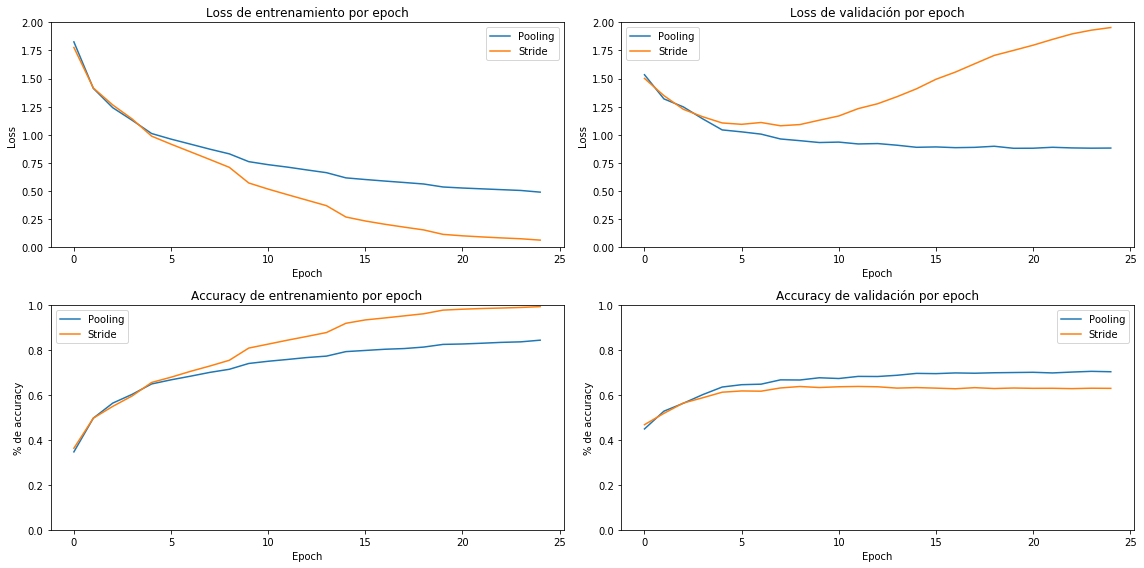

In [28]:
plt.figure(figsize=(16,8))
plt.subplot(221)
plt.title("Loss de entrenamiento por epoch")
plt.plot(train_pool.history['loss'], label="Pooling")
plt.plot(train_stride.history['loss'], label="Stride")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.ylim(ymin=0, ymax = 2)

plt.subplot(222)
plt.title("Loss de validación por epoch")
plt.plot(train_pool.history['val_loss'], label="Pooling")
plt.plot(train_stride.history['val_loss'], label="Stride")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.ylim(ymin=0, ymax = 2)

plt.subplot(223)
plt.title("Accuracy de entrenamiento por epoch")
plt.plot(train_pool.history['acc'], label="Pooling")
plt.plot(train_stride.history['acc'], label="Stride")
plt.ylabel("% de accuracy")
plt.xlabel("Epoch")
plt.ylim(ymin=0, ymax = 1)
plt.legend()

plt.subplot(224)
plt.title("Accuracy de validación por epoch")
plt.plot(train_pool.history['val_acc'], label="Pooling")
plt.plot(train_stride.history['val_acc'], label="Stride")
plt.ylabel("% de accuracy")
plt.xlabel("Epoch")
plt.ylim(ymin=0, ymax = 1)
plt.legend()

plt.tight_layout()
plt.show();

La red con striding tiene un comportamiento similar al pooling ya que el striding junta neuronas de forma aislada, parecido al pooling ya que al hacer este desplazamiento más largo, se salta neuronas imitando el pooling.

Pese a que la red convolucional implementada con stride tuvo un menor valor de loss y mayor precisión a la hora de evaluar los datos de entrenamiento, sin embargo, a la hora de evaluar los valores de testing, se nota como la pérdida de la red con stride aumenta con el tiempo y la accuracy se estanca, esto denota un caso de overfitting ya que la red se adaptó exclusivamente para los datos de entretamiento y no responde correctamente a los datos de prueba.

## Uso de transformaciones para ampliar el dataset

> i) Una forma interesante de regularizar modelos entrenados para visión artificial consiste en “aumentar” el número de ejemplos de entrenamiento usando transformaciones sencillas como: rotaciones, corrimientos y reflexiones, tanto horizontales como verticales. Explique porqué este procedimiento podrı́a ayudar a mejorar el modelo y el porqué las etiquetas no cambian al aplicar estas operaciones. Evalúe experimentalmente la conveniencia de incorporarlo.

### CNN con dataset ampliado

In [37]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
train_datagen = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),steps_per_epoch=x_train.shape[0]//batch_size, epochs=epochs,validation_data=(x_test, y_test), workers = 4)

Epoch 1/25
2000/2000 [==============================] - 22s 11ms/step - loss: 1.6585 - acc: 0.4048 - val_loss: 1.4022 - val_acc: 0.5077
Epoch 2/25
1491/2000 [=====================>........] - ETA: 5s - loss: 1.3938 - acc: 0.5035

2000/2000 [==============================] - 22s 11ms/step - loss: 1.3764 - acc: 0.5109 - val_loss: 1.2227 - val_acc: 0.5692
Epoch 3/25
2000/2000 [==============================] - 21s 11ms/step - loss: 1.2559 - acc: 0.5574 - val_loss: 1.2085 - val_acc: 0.5834
Epoch 4/25
 189/2000 [=>............................] - ETA: 17s - loss: 1.1877 - acc: 0.5759

2000/2000 [==============================] - 21s 11ms/step - loss: 1.1684 - acc: 0.5885 - val_loss: 1.0624 - val_acc: 0.6296
Epoch 5/25
1844/2000 [==========================>...] - ETA: 1s - loss: 1.1111 - acc: 0.6108

2000/2000 [==============================] - 21s 11ms/step - loss: 1.1061 - acc: 0.6119 - val_loss: 1.0151 - val_acc: 0.6407
Epoch 6/25
2000/2000 [==============================] - 21s 11ms/step - loss: 1.0559 - acc: 0.6320 - val_loss: 0.9594 - val_acc: 0.6701
Epoch 7/25
 281/2000 [===>..........................] - ETA: 16s - loss: 1.0317 - acc: 0.6421

2000/2000 [==============================] - 21s 11ms/step - loss: 1.0175 - acc: 0.6448 - val_loss: 0.9333 - val_acc: 0.6774
Epoch 8/25
1881/2000 [===========================>..] - ETA: 1s - loss: 0.9842 - acc: 0.6541

2000/2000 [==============================] - 21s 11ms/step - loss: 0.9828 - acc: 0.6547 - val_loss: 0.9091 - val_acc: 0.6902
Epoch 9/25
2000/2000 [==============================] - 22s 11ms/step - loss: 0.9526 - acc: 0.6669 - val_loss: 0.9205 - val_acc: 0.6837
Epoch 10/25
 257/2000 [==>...........................] - ETA: 16s - loss: 0.9415 - acc: 0.6719

2000/2000 [==============================] - 21s 11ms/step - loss: 0.9238 - acc: 0.6768 - val_loss: 0.9511 - val_acc: 0.6777
Epoch 11/25
1862/2000 [==========================>...] - ETA: 1s - loss: 0.9067 - acc: 0.6837

2000/2000 [==============================] - 21s 11ms/step - loss: 0.9032 - acc: 0.6854 - val_loss: 0.8976 - val_acc: 0.6973
Epoch 12/25
2000/2000 [==============================] - 21s 11ms/step - loss: 0.8822 - acc: 0.6919 - val_loss: 0.8121 - val_acc: 0.7173
Epoch 13/25
 290/2000 [===>..........................] - ETA: 16s - loss: 0.8524 - acc: 0.7036

2000/2000 [==============================] - 21s 11ms/step - loss: 0.8610 - acc: 0.7014 - val_loss: 0.8407 - val_acc: 0.7152
Epoch 14/25
1864/2000 [==========================>...] - ETA: 1s - loss: 0.8443 - acc: 0.7067

2000/2000 [==============================] - 21s 11ms/step - loss: 0.8432 - acc: 0.7075 - val_loss: 0.7811 - val_acc: 0.7316
Epoch 15/25
2000/2000 [==============================] - 21s 11ms/step - loss: 0.8240 - acc: 0.7150 - val_loss: 0.8074 - val_acc: 0.7237
Epoch 16/25
 270/2000 [===>..........................] - ETA: 16s - loss: 0.8094 - acc: 0.7194

2000/2000 [==============================] - 21s 11ms/step - loss: 0.8076 - acc: 0.7195 - val_loss: 0.7725 - val_acc: 0.7391
Epoch 17/25
1856/2000 [==========================>...] - ETA: 1s - loss: 0.7895 - acc: 0.7267

2000/2000 [==============================] - 21s 11ms/step - loss: 0.7893 - acc: 0.7265 - val_loss: 0.7915 - val_acc: 0.7332
Epoch 18/25
2000/2000 [==============================] - 21s 11ms/step - loss: 0.7794 - acc: 0.7299 - val_loss: 0.7737 - val_acc: 0.7379
Epoch 19/25
 258/2000 [==>...........................] - ETA: 16s - loss: 0.7839 - acc: 0.7240

2000/2000 [==============================] - 22s 11ms/step - loss: 0.7681 - acc: 0.7338 - val_loss: 0.8039 - val_acc: 0.7214
Epoch 20/25
1804/2000 [==========================>...] - ETA: 1s - loss: 0.7476 - acc: 0.7407

2000/2000 [==============================] - 22s 11ms/step - loss: 0.7497 - acc: 0.7403 - val_loss: 0.7332 - val_acc: 0.7470
Epoch 21/25
2000/2000 [==============================] - 21s 11ms/step - loss: 0.7423 - acc: 0.7419 - val_loss: 0.7807 - val_acc: 0.7332
Epoch 22/25
 219/2000 [==>...........................] - ETA: 18s - loss: 0.7212 - acc: 0.7489

2000/2000 [==============================] - 22s 11ms/step - loss: 0.7235 - acc: 0.7495 - val_loss: 0.7361 - val_acc: 0.7546
Epoch 23/25
1795/2000 [=========================>....] - ETA: 2s - loss: 0.7150 - acc: 0.7526

2000/2000 [==============================] - 22s 11ms/step - loss: 0.7162 - acc: 0.7524 - val_loss: 0.7392 - val_acc: 0.7463
Epoch 24/25
2000/2000 [==============================] - 21s 11ms/step - loss: 0.7089 - acc: 0.7548 - val_loss: 0.6964 - val_acc: 0.7650
Epoch 25/25
 251/2000 [==>...........................] - ETA: 17s - loss: 0.6595 - acc: 0.7683

2000/2000 [==============================] - 21s 11ms/step - loss: 0.6969 - acc: 0.7602 - val_loss: 0.7128 - val_acc: 0.7578


### CNN de control

In [33]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
train_rmsprop = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_test, y_test),shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 22s 432us/step - loss: 1.5784 - acc: 0.4394 - val_loss: 1.4313 - val_acc: 0.5061
Epoch 2/25
22900/50000 [============>.................] - ETA: 10s - loss: 1.2873 - acc: 0.5462

50000/50000 [==============================] - 21s 417us/step - loss: 1.2518 - acc: 0.5588 - val_loss: 1.1801 - val_acc: 0.5819
Epoch 3/25
50000/50000 [==============================] - 21s 419us/step - loss: 1.1048 - acc: 0.6129 - val_loss: 1.0680 - val_acc: 0.6245
Epoch 4/25
 1675/50000 [>.............................] - ETA: 19s - loss: 1.0499 - acc: 0.6352

50000/50000 [==============================] - 21s 420us/step - loss: 1.0076 - acc: 0.6494 - val_loss: 1.0026 - val_acc: 0.6520
Epoch 5/25
43600/50000 [=========================>....] - ETA: 2s - loss: 0.9398 - acc: 0.6738

50000/50000 [==============================] - 21s 418us/step - loss: 0.9348 - acc: 0.6755 - val_loss: 0.9862 - val_acc: 0.6516
Epoch 6/25
50000/50000 [==============================] - 21s 418us/step - loss: 0.8755 - acc: 0.6962 - val_loss: 0.9251 - val_acc: 0.6783
Epoch 7/25
 4875/50000 [=>............................] - ETA: 17s - loss: 0.8269 - acc: 0.7155

50000/50000 [==============================] - 21s 422us/step - loss: 0.8242 - acc: 0.7163 - val_loss: 0.9015 - val_acc: 0.6880
Epoch 8/25
45175/50000 [==========================>...] - ETA: 1s - loss: 0.7771 - acc: 0.7313

50000/50000 [==============================] - 21s 422us/step - loss: 0.7767 - acc: 0.7311 - val_loss: 0.8598 - val_acc: 0.7029
Epoch 9/25
50000/50000 [==============================] - 21s 419us/step - loss: 0.7352 - acc: 0.7456 - val_loss: 0.8521 - val_acc: 0.7050
Epoch 10/25
 5975/50000 [==>...........................] - ETA: 17s - loss: 0.6866 - acc: 0.7642

50000/50000 [==============================] - 21s 418us/step - loss: 0.6920 - acc: 0.7628 - val_loss: 0.8573 - val_acc: 0.7049
Epoch 11/25
45075/50000 [==========================>...] - ETA: 1s - loss: 0.6530 - acc: 0.7767

50000/50000 [==============================] - 21s 422us/step - loss: 0.6517 - acc: 0.7770 - val_loss: 0.8445 - val_acc: 0.7127
Epoch 12/25
50000/50000 [==============================] - 21s 421us/step - loss: 0.6119 - acc: 0.7909 - val_loss: 0.8388 - val_acc: 0.7156
Epoch 13/25
 5525/50000 [==>...........................] - ETA: 17s - loss: 0.5600 - acc: 0.8110

50000/50000 [==============================] - 21s 420us/step - loss: 0.5737 - acc: 0.8051 - val_loss: 0.8344 - val_acc: 0.7157
Epoch 14/25
44800/50000 [=========================>....] - ETA: 2s - loss: 0.5362 - acc: 0.8186

50000/50000 [==============================] - 21s 420us/step - loss: 0.5370 - acc: 0.8185 - val_loss: 0.8060 - val_acc: 0.7267
Epoch 15/25
50000/50000 [==============================] - 21s 419us/step - loss: 0.4996 - acc: 0.8320 - val_loss: 0.8754 - val_acc: 0.7114
Epoch 16/25
 5950/50000 [==>...........................] - ETA: 17s - loss: 0.4546 - acc: 0.8464

50000/50000 [==============================] - 21s 418us/step - loss: 0.4635 - acc: 0.8435 - val_loss: 0.8165 - val_acc: 0.7294
Epoch 17/25
45450/50000 [==========================>...] - ETA: 1s - loss: 0.4269 - acc: 0.8570

50000/50000 [==============================] - 21s 418us/step - loss: 0.4267 - acc: 0.8567 - val_loss: 0.8967 - val_acc: 0.7043
Epoch 18/25
50000/50000 [==============================] - 21s 416us/step - loss: 0.3952 - acc: 0.8687 - val_loss: 0.8757 - val_acc: 0.7240
Epoch 19/25
 6650/50000 [==>...........................] - ETA: 16s - loss: 0.3472 - acc: 0.8926

50000/50000 [==============================] - 21s 418us/step - loss: 0.3595 - acc: 0.8829 - val_loss: 0.8271 - val_acc: 0.7399
Epoch 20/25
45725/50000 [==========================>...] - ETA: 1s - loss: 0.3306 - acc: 0.8923

50000/50000 [==============================] - 21s 421us/step - loss: 0.3301 - acc: 0.8922 - val_loss: 0.8957 - val_acc: 0.7248
Epoch 21/25
50000/50000 [==============================] - 21s 418us/step - loss: 0.2992 - acc: 0.9027 - val_loss: 0.8930 - val_acc: 0.7261
Epoch 22/25
 6475/50000 [==>...........................] - ETA: 16s - loss: 0.2569 - acc: 0.9219

50000/50000 [==============================] - 21s 420us/step - loss: 0.2714 - acc: 0.9132 - val_loss: 0.9108 - val_acc: 0.7320
Epoch 23/25
46125/50000 [==========================>...] - ETA: 1s - loss: 0.2412 - acc: 0.9244

50000/50000 [==============================] - 21s 419us/step - loss: 0.2423 - acc: 0.9238 - val_loss: 0.9154 - val_acc: 0.7348
Epoch 24/25
50000/50000 [==============================] - 21s 421us/step - loss: 0.2177 - acc: 0.9309 - val_loss: 0.9490 - val_acc: 0.7361
Epoch 25/25
 6350/50000 [==>...........................] - ETA: 16s - loss: 0.1743 - acc: 0.9487

50000/50000 [==============================] - 21s 418us/step - loss: 0.1940 - acc: 0.9406 - val_loss: 0.9825 - val_acc: 0.7306


### Comparación de resultados

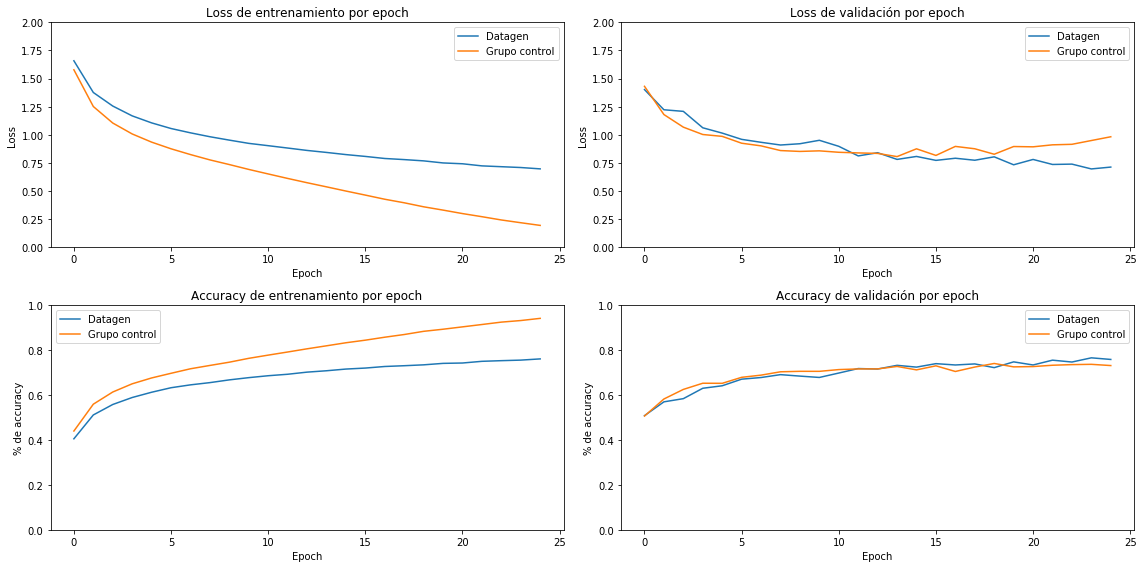

In [38]:
plt.figure(figsize=(16,8))
plt.subplot(221)
plt.title("Loss de entrenamiento por epoch")
plt.plot(train_datagen.history['loss'], label="Datagen")
plt.plot(train_rmsprop.history['loss'], label="Grupo control")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.ylim(ymin=0, ymax = 2)

plt.subplot(222)
plt.title("Loss de validación por epoch")
plt.plot(train_datagen.history['val_loss'], label="Datagen")
plt.plot(train_rmsprop.history['val_loss'], label="Grupo control")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.ylim(ymin=0, ymax = 2)

plt.subplot(223)
plt.title("Accuracy de entrenamiento por epoch")
plt.plot(train_datagen.history['acc'], label="Datagen")
plt.plot(train_rmsprop.history['acc'], label="Grupo control")
plt.ylabel("% de accuracy")
plt.xlabel("Epoch")
plt.ylim(ymin=0, ymax = 1)
plt.legend()

plt.subplot(224)
plt.title("Accuracy de validación por epoch")
plt.plot(train_datagen.history['val_acc'], label="Datagen")
plt.plot(train_rmsprop.history['val_acc'], label="Grupo control")
plt.ylabel("% de accuracy")
plt.xlabel("Epoch")
plt.ylim(ymin=0, ymax = 1)
plt.legend()

plt.tight_layout()
plt.show();

De los resultados obtenidos, se puede ver como tanto el loss y accuracy de validación son mejores en la red que utilizó el dataset ampliado, considerando que cada epoch de este era 25 veces más pequeño pero contemplaba una mayor cantidad de ejemplos considerando que las transformaciones realizadas a las imágenes permiten ver más casos posibles a la hora de actuar sobre casos de prueba, un ejemplo de esto sería que en el dataset de entrenamiento normal, no existan muchas imágenes de perros mirando hacia la izquierda, pero sí para al derecha, esto podría causar _overfitting_ a la hora de validar los resultados. Esto se soluciona al entregar ejemplos de imágenes invertidas horizontalmente, lo que para nosotros es la misma imagen, para la red neuronal son completamente distintas.

Esto hizo que la red sea más robusta que la de control teniendo menor overfitting.

## Matriz de confusión de una CNN

> j) Elija una de las redes entrenadas en esta sección (preferentemente una con buen desempeño) y determine los pares de objetos (por ejemplo “camiones” con “autos”) que la red tiende a confundir. Conjeture el motivo de tal confusión.

In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_preds = model.predict(x_test)

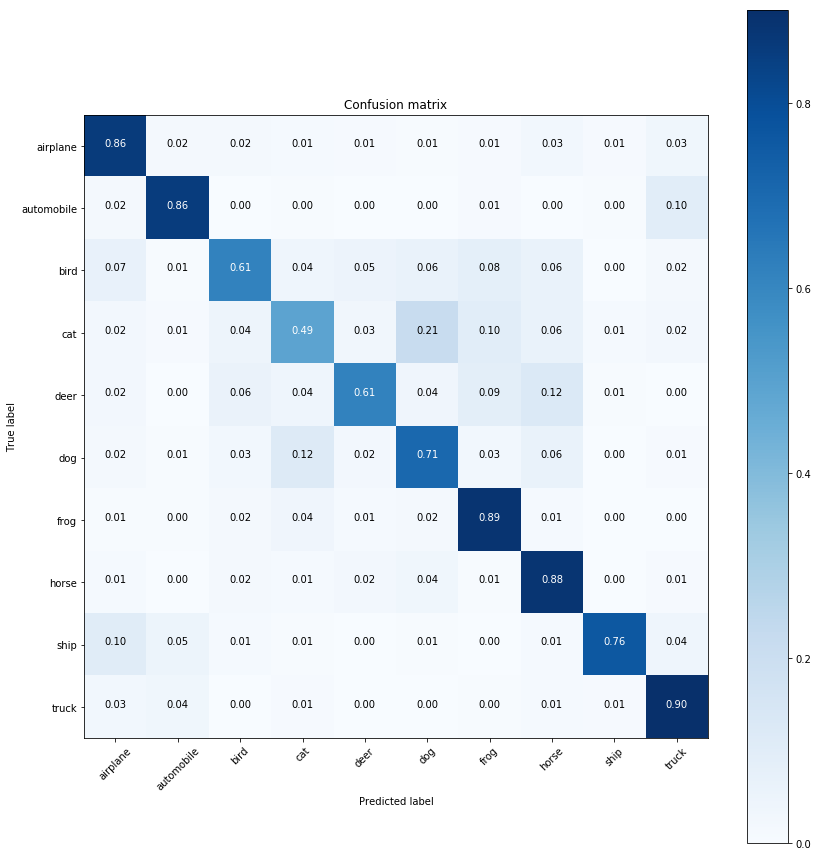

In [77]:
cm = confusion_matrix([np.argmax(x) for x in y_test], [np.argmax(x) for x in y_preds])
plot_confusion_matrix(cm, label_names)

Se puede ver que en general la diagonal de la matriz de confusión domina sobre los otros valores lo que implica que en la mayoría de los casos, la red es capaz de reconocer la imagen entregada, siendo "gato" la etiqueta que peor reconoce con solo un $49\%$ de los casos de prueba logrados exitosamente ya que principalmente la confunde con la etiqueta "perro" lo cual es esperable por el parecido entre ambos sujetos, comparten características como bigotes, hocico y forma de cara. Por otro lado, las etiquetas "camión" y "rana" obtuvieron un $90\%$ y $89\%$ de acierto respectivamente.

Otra etiqueta que tuve una confusión mayor es "ciervo" la cual fue principalmente confundida con "caballo" ambos comparten características como patas grandes, pelaje similar, etc.

## Visualización de pesos de red convolucional

> k) Elija una de las redes entrenadas (preferentemente una con buen desempeño) y visualice los pesos correspondientes a los filtros de la primera capa convolucional. Visualice además el efecto del filtro sobre algunas imágenes de entrenamiento. Repita el proceso para los pesos de la última capa convolucional. Comente.

In [44]:
# Instanciación y entrenamiento de una red
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
train_pool = model.fit(x_train, y_train,batch_size=batch_size,epochs=25, validation_data=(x_test,y_test), shuffle=True, callbacks=[lrate], verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
 - 20s - loss: 1.8494 - acc: 0.3382 - val_loss: 1.5433 - val_acc: 0.4470
Epoch 2/25
 - 18s - loss: 1.4383 - acc: 0.4864 - val_loss: 1.3557 - val_acc: 0.5098
Epoch 3/25
 - 18s - loss: 1.2738 - acc: 0.5494 - val_loss: 1.2430 - val_acc: 0.5577
Epoch 4/25
 - 18s - loss: 1.1623 - acc: 0.5889 - val_loss: 1.1455 - val_acc: 0.5984
Epoch 5/25
 - 19s - loss: 1.0407 - acc: 0.6367 - val_loss: 1.0590 - val_acc: 0.6299
Epoch 6/25
 - 19s - loss: 0.9890 - acc: 0.6561 - val_loss: 1.0293 - val_acc: 0.6349
Epoch 7/25
 - 19s - loss: 0.9407 - acc: 0.6740 - val_loss: 1.0060 - val_acc: 0.6431
Epoch 8/25
 - 19s - loss: 0.8951 - acc: 0.6895 - val_loss: 0.9672 - val_acc: 0.6612
Epoch 9/25
 - 18s - loss: 0.8484 - acc: 0.7060 - val_loss: 0.9517 - val_acc: 0.6658
Epoch 10/25
 - 19s - loss: 0.7784 - acc: 0.7324 - val_loss: 0.9129 - val_acc: 0.6824
Epoch 11/25
 - 19s - loss: 0.7509 - acc: 0.7432 - val_loss: 0.9368 - val_acc: 0.6764
Epoch 12/25
 - 19s - los

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_73 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_74 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 4096)              0         
__________

---------------Ejemplo 1---------------
Imagen input


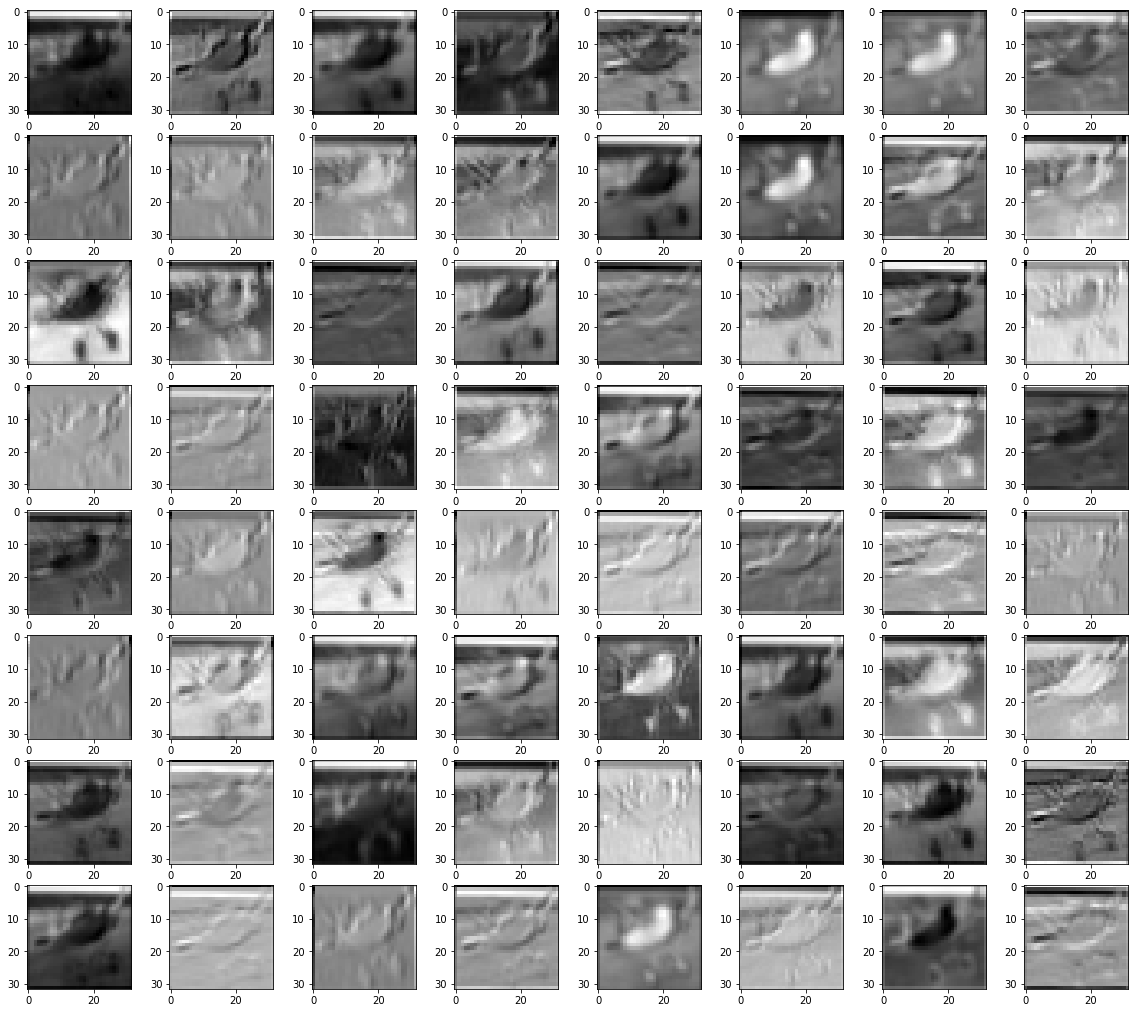

In [159]:
def layer_to_visualize(layer):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)

    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))

    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[i])#, cmap='gray')
  
def as_image(x):
    # normalize data
    x -= x.mean()
    x /= (x.std() + 1e-5)
    # set the std to 0.1 and the mean to 0.5
    x *= 0.1
    x += 0.5
    # scale data and clip between 0 and 255 like an image data
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
        
#k
intermediate_layer_model = Model(inputs=model.input,outputs=model.layers[0](model.input))
intermediate_output = intermediate_layer_model.predict(x_train[:100])
intermediate_output.shape[1:]

print("---------------Ejemplo 1---------------")
print("Imagen input")

ima = intermediate_output[35]

fig = plt.figure(figsize=(20,18))
for i in range(64):
    ax = fig.add_subplot(8,8,i+1)
    ax.imshow(ima[:,:,i], cmap='gray', interpolation="nearest")

{'name': 'conv2d_32', 'trainable': True, 'batch_input_shape': (None, 32, 32, 3), 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'conv2d_33', 'trainable': True, 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class

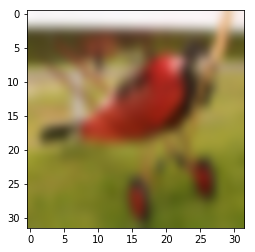

In [122]:
# choose any image to want by specifying the index# choose 
img_to_visualize = x_train[35]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
#img_to_visualize = np.expand_dims(img_to_visualize, axis=0)

plt.imshow(x_train[35], interpolation='bicubic')
capa_conv_i = model.get_layer(index=1)
capa_conv_f = model.get_layer(index=4)
print(capa_conv_i.get_config())
print(capa_conv_f.get_config())

In [160]:
#k
intermediate_layer_model = Model(inputs=model.input,outputs=model.layers[3](model.input))
intermediate_output = intermediate_layer_model.predict(x_train[:100])
intermediate_output.shape[1:]

print("---------------Ejemplo 1---------------")
print("Imagen input")

ima = intermediate_output[35]

fig = plt.figure(figsize=(20,18))
for i in range(64):
    ax = fig.add_subplot(8,8,i+1)
    ax.imshow(ima[:,:,i], cmap='gray', interpolation="nearest")

ValueError: ignored

<a id="cuarto"></a>
# 4. Aplicación de una red neuronal en Localización
Desde la edad antigua, múltiples formas de localización han sido desarrolladas. Dentro de los avances más importantes en este ámbito, es el desarrollo de la teorı́a cientı́fica y técnica denominada georreferenciación. Gracias a GPS, el crecimiento y acceso de la georreferenciación y navegación está en progresivo aumento, el problema surge cuando se intentan estimar en recintos interiores (como edificios o bajo tierra) donde el GPS no funciona de la manera como uno esperaría, debido a que existen muchos obstáculos e interferencia que imposibilitan su uso.  
Dentro de interiores se cuenta con señales RSSI (*fingerprint*) que pueden atacar este problema, sin embargo los métodos actuales no son robustos a ruido, por lo que su tarea será la de abordar este problema para mejorar exactitud de sistemas de posicionamiento en interiores mediante redes neuronales.  

La metodología con la que se trabajará será que, para dentro de interiores, dispositivos *Bluetooth* emiten señales RSSI las cuales son captadas por el dispositivo "objetivo" al cual se le desea determinar su localización, recibiendo distintas intensidades de señal de cada dispositivo emisor debido a su posición en el interior. Los datos con los que se va a trabajar (*IndoorFingerprint.csv*) fueron provistos por el nuevo Ing. Civil Informático Felipe Berrios, éstos constan de 8 características (*C1hA,0kxZ,tvMX,OlYb,7rk5,F39L,VNSF,tkxI*) correspondientes a las mediciones hechas/recibidas por el dispositivo "objetivo" de las distintas señales RSSI emitidas por los dispositivos *Bluetooth* en los bordes del interior, además de tener la posición del dispositivo "objetivo" en un plano XY (valor a estimar).

<img src="https://i.imgur.com/Xheipaa.png" width="60%" height="20%" />

Grilla ejemplo de cómo funciona el sistema (elaboración por Felipe Berrios). Los 4 dispositivos en la esquina son los que emiten las señales RSSI, el punto naranja es el dispositivo que las recibe y es el "objetivo" a determinar la posición.

Una consideración importante es el cómo tratar la ausencia de la señal proveniente de un dispositivo *Bluetooth*, para estos datos se utiliza un valor de +100, ya que es imposible obtener este valor debido a las características de la escala RSSI (siempre negativa o igual a cero), pero puede ser sustituido por otro.  
Para hacer el trabajo mas simple se discretizará la posición en el plano definiendo zonas en dónde está el objeto a localizar. Las zonas deben ser las que indica la malla a continuación:

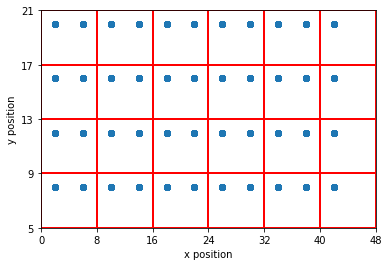

In [2]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/nachotp/Tarea1-INF395/master/IndoorFingerprint.csv")

import matplotlib.pyplot as plt
%matplotlib inline
X = df["X"]
Y = df["Y"]
plt.scatter(df["X"],df["Y"])

x_ticks = np.arange(0, 49, 8)
y_ticks = np.arange(5, 22, 4)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.grid(color='r', linestyle='-', linewidth=2)
plt.ylabel("y position")
plt.xlabel("x position")
plt.show()

Donde los puntos azules son los distintos datos superpuestos de las posiciones del objeto a localizar. Por ejemplo el punto (2,8) está en la primera zona (o en la primera zona del eje *x* y del eje *y*), el punto (2,20) está en la zona 19 (o en la primera zona del eje *x* y la cuarta zona del eje *y*). Esta discretización transforma el problema que en un principio podría ser de regresión para determinar la posición exacta, en un problema de clasificación dividiendo (dentro de los posibles valores) 6 zonas para el eje "*x*" y 4 zonas para el eje "*y*", contando con un total de 24 clases (24 zonas en la malla).

> Deberá entrenar una red neuronal *feed forward* para la clasificación de las 24 posibles clases, con el objetivo de tener un desempeño (*accuracy*) mayor al 75%.

El conjunto de pruebas está **fijado** a través de los indices de posiciones del dataset, por lo que deberá leer estos indices y crear el conjunto de pruebas a partir de éstos.

## Preparación del dataset

In [0]:
mask_test = np.loadtxt('https://raw.githubusercontent.com/nachotp/Tarea1-INF395/master/mask_test.csv',dtype="i")

x_test = df.iloc[mask_test,:]
x_train = df.drop(mask_test, axis = 0)

y_test = x_test.iloc[:,0:2]
x_test = x_test.iloc[:,2:]

y_train = x_train.iloc[:,0:2]
x_train = x_train.iloc[:,2:]

Es una buena práctica el normalizar los datos antes de trabajar con los modelos

In [0]:
def get_zone(row):
  if row[0] <= 8:
    if row[1] <= 9:
      return 1
    if row[1] <= 13:
      return 7
    if row[1] <= 17:
      return 13
    if row[1] <= 21:
      return 19
  if row[0] <= 16:
    if row[1] <= 9:
      return 2
    if row[1] <= 13:
      return 8
    if row[1] <= 17:
      return 14
    if row[1] <= 21:
      return 20
  if row[0] <= 24:
    if row[1] <= 9:
      return 3
    if row[1] <= 13:
      return 9
    if row[1] <= 17:
      return 15
    if row[1] <= 21:
      return 21
  if row[0] <= 32:
    if row[1] <= 9:
      return 4
    if row[1] <= 13:
      return 10
    if row[1] <= 17:
      return 16
    if row[1] <= 21:
      return 22
  if row[0] <= 40:
    if row[1] <= 9:
      return 5
    if row[1] <= 13:
      return 11
    if row[1] <= 17:
      return 17
    if row[1] <= 21:
      return 23
  if row[0] <= 48:
    if row[1] <= 9:
      return 6
    if row[1] <= 13:
      return 12
    if row[1] <= 17:
      return 18
    if row[1] <= 21:
      return 24

y_test = y_test.apply(lambda x: get_zone(x)-1, axis = 1)
y_train = y_train.apply(lambda x: get_zone(x)-1, axis = 1)

y_test = keras.utils.to_categorical(y_test)
y_train = keras.utils.to_categorical(y_train)

scaler = StandardScaler().fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
scaler = StandardScaler().fit(x_test)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

## Instanciación de la red

In [5]:
model = Sequential()
model.add(Dense(100, input_dim=x_train.shape[1], kernel_initializer='uniform')) #Pesos aportan positiva o negativamente
model.add(Activation('relu'))
model.add(Dense(50, kernel_initializer='uniform'))
model.add(Activation('relu'))
model.add(Dense(y_train.shape[1], kernel_initializer='uniform'))
model.add(Activation('softmax')) 
sgd = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=0.01)
model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['accuracy'])
train_triang = model.fit(x_train, y_train, epochs=200, verbose=2, validation_data=(x_test, y_test))

Train on 4620 samples, validate on 1980 samples
Epoch 1/200
 - 3s - loss: 2.4807 - acc: 0.2695 - val_loss: 1.5174 - val_acc: 0.4813
Epoch 2/200
 - 1s - loss: 1.2596 - acc: 0.5680 - val_loss: 1.0302 - val_acc: 0.6429
Epoch 3/200
 - 1s - loss: 0.9321 - acc: 0.6961 - val_loss: 0.8216 - val_acc: 0.7343
Epoch 4/200
 - 1s - loss: 0.7532 - acc: 0.7619 - val_loss: 0.7137 - val_acc: 0.7677
Epoch 5/200
 - 1s - loss: 0.6613 - acc: 0.7896 - val_loss: 0.6457 - val_acc: 0.7929
Epoch 6/200
 - 1s - loss: 0.5917 - acc: 0.8180 - val_loss: 0.5896 - val_acc: 0.8121
Epoch 7/200
 - 1s - loss: 0.5457 - acc: 0.8288 - val_loss: 0.5595 - val_acc: 0.8192
Epoch 8/200
 - 1s - loss: 0.5068 - acc: 0.8418 - val_loss: 0.5275 - val_acc: 0.8212
Epoch 9/200
 - 1s - loss: 0.4838 - acc: 0.8463 - val_loss: 0.4956 - val_acc: 0.8328
Epoch 10/200
 - 1s - loss: 0.4503 - acc: 0.8543 - val_loss: 0.4792 - val_acc: 0.8394
Epoch 11/200
 - 1s - loss: 0.4321 - acc: 0.8626 - val_loss: 0.4682 - val_acc: 0.8439
Epoch 12/200
 - 1s - loss:

 - 1s - loss: 0.2158 - acc: 0.9357 - val_loss: 0.2746 - val_acc: 0.9106
Epoch 35/200
 - 1s - loss: 0.2166 - acc: 0.9327 - val_loss: 0.2701 - val_acc: 0.9157
Epoch 36/200
 - 1s - loss: 0.2139 - acc: 0.9379 - val_loss: 0.2599 - val_acc: 0.9227
Epoch 37/200
 - 1s - loss: 0.2046 - acc: 0.9396 - val_loss: 0.2620 - val_acc: 0.9197
Epoch 38/200
 - 1s - loss: 0.1975 - acc: 0.9405 - val_loss: 0.2632 - val_acc: 0.9076
Epoch 39/200
 - 1s - loss: 0.1935 - acc: 0.9405 - val_loss: 0.2453 - val_acc: 0.9278
Epoch 40/200
 - 1s - loss: 0.1935 - acc: 0.9426 - val_loss: 0.2567 - val_acc: 0.9187
Epoch 41/200
 - 1s - loss: 0.1920 - acc: 0.9418 - val_loss: 0.2541 - val_acc: 0.9141
Epoch 42/200
 - 1s - loss: 0.1883 - acc: 0.9446 - val_loss: 0.2387 - val_acc: 0.9232
Epoch 43/200
 - 1s - loss: 0.1846 - acc: 0.9442 - val_loss: 0.2453 - val_acc: 0.9232
Epoch 44/200
 - 1s - loss: 0.1839 - acc: 0.9463 - val_loss: 0.2404 - val_acc: 0.9172
Epoch 45/200
 - 1s - loss: 0.1747 - acc: 0.9504 - val_loss: 0.2309 - val_acc: 

Epoch 68/200
 - 1s - loss: 0.1163 - acc: 0.9695 - val_loss: 0.1835 - val_acc: 0.9399
Epoch 69/200
 - 1s - loss: 0.1130 - acc: 0.9712 - val_loss: 0.1905 - val_acc: 0.9354
Epoch 70/200
 - 1s - loss: 0.1153 - acc: 0.9706 - val_loss: 0.1915 - val_acc: 0.9374
Epoch 71/200
 - 1s - loss: 0.1116 - acc: 0.9716 - val_loss: 0.1781 - val_acc: 0.9399
Epoch 72/200
 - 1s - loss: 0.1087 - acc: 0.9721 - val_loss: 0.1808 - val_acc: 0.9404
Epoch 73/200
 - 1s - loss: 0.1088 - acc: 0.9721 - val_loss: 0.1886 - val_acc: 0.9409
Epoch 74/200
 - 1s - loss: 0.1033 - acc: 0.9762 - val_loss: 0.1713 - val_acc: 0.9465
Epoch 75/200
 - 1s - loss: 0.1087 - acc: 0.9742 - val_loss: 0.1749 - val_acc: 0.9475
Epoch 76/200
 - 1s - loss: 0.1016 - acc: 0.9740 - val_loss: 0.1785 - val_acc: 0.9389
Epoch 77/200
 - 1s - loss: 0.1007 - acc: 0.9771 - val_loss: 0.1612 - val_acc: 0.9449
Epoch 78/200
 - 1s - loss: 0.0999 - acc: 0.9764 - val_loss: 0.1635 - val_acc: 0.9470
Epoch 79/200
 - 1s - loss: 0.0977 - acc: 0.9760 - val_loss: 0.161

Epoch 102/200
 - 1s - loss: 0.0755 - acc: 0.9833 - val_loss: 0.1533 - val_acc: 0.9520
Epoch 103/200
 - 1s - loss: 0.0754 - acc: 0.9833 - val_loss: 0.1379 - val_acc: 0.9591
Epoch 104/200
 - 1s - loss: 0.0767 - acc: 0.9816 - val_loss: 0.1715 - val_acc: 0.9470
Epoch 105/200
 - 1s - loss: 0.0793 - acc: 0.9827 - val_loss: 0.1565 - val_acc: 0.9561
Epoch 106/200
 - 1s - loss: 0.0741 - acc: 0.9818 - val_loss: 0.1429 - val_acc: 0.9571
Epoch 107/200
 - 1s - loss: 0.0728 - acc: 0.9827 - val_loss: 0.1553 - val_acc: 0.9545
Epoch 108/200
 - 1s - loss: 0.0725 - acc: 0.9816 - val_loss: 0.1738 - val_acc: 0.9470
Epoch 109/200
 - 1s - loss: 0.0691 - acc: 0.9848 - val_loss: 0.1446 - val_acc: 0.9566
Epoch 110/200
 - 1s - loss: 0.0718 - acc: 0.9820 - val_loss: 0.1547 - val_acc: 0.9556
Epoch 111/200
 - 1s - loss: 0.0685 - acc: 0.9855 - val_loss: 0.1444 - val_acc: 0.9556
Epoch 112/200
 - 1s - loss: 0.0701 - acc: 0.9851 - val_loss: 0.1380 - val_acc: 0.9556
Epoch 113/200
 - 1s - loss: 0.0717 - acc: 0.9840 - val

Epoch 136/200
 - 1s - loss: 0.0576 - acc: 0.9877 - val_loss: 0.1430 - val_acc: 0.9576
Epoch 137/200
 - 1s - loss: 0.0570 - acc: 0.9874 - val_loss: 0.1444 - val_acc: 0.9581
Epoch 138/200
 - 1s - loss: 0.0581 - acc: 0.9892 - val_loss: 0.1463 - val_acc: 0.9581
Epoch 139/200
 - 1s - loss: 0.0598 - acc: 0.9853 - val_loss: 0.1420 - val_acc: 0.9566
Epoch 140/200
 - 1s - loss: 0.0599 - acc: 0.9874 - val_loss: 0.1472 - val_acc: 0.9581
Epoch 141/200
 - 1s - loss: 0.0531 - acc: 0.9898 - val_loss: 0.1309 - val_acc: 0.9616
Epoch 142/200
 - 1s - loss: 0.0521 - acc: 0.9900 - val_loss: 0.1483 - val_acc: 0.9606
Epoch 143/200
 - 1s - loss: 0.0532 - acc: 0.9911 - val_loss: 0.1675 - val_acc: 0.9571
Epoch 144/200
 - 1s - loss: 0.0555 - acc: 0.9907 - val_loss: 0.1389 - val_acc: 0.9596
Epoch 145/200
 - 1s - loss: 0.0531 - acc: 0.9898 - val_loss: 0.1413 - val_acc: 0.9616
Epoch 146/200
 - 1s - loss: 0.0503 - acc: 0.9918 - val_loss: 0.1577 - val_acc: 0.9525
Epoch 147/200
 - 1s - loss: 0.0563 - acc: 0.9887 - val

Epoch 170/200
 - 1s - loss: 0.0528 - acc: 0.9885 - val_loss: 0.1462 - val_acc: 0.9611
Epoch 171/200
 - 1s - loss: 0.0476 - acc: 0.9918 - val_loss: 0.1425 - val_acc: 0.9646
Epoch 172/200
 - 1s - loss: 0.0455 - acc: 0.9924 - val_loss: 0.1554 - val_acc: 0.9571
Epoch 173/200
 - 1s - loss: 0.0438 - acc: 0.9929 - val_loss: 0.1424 - val_acc: 0.9626
Epoch 174/200
 - 1s - loss: 0.0468 - acc: 0.9907 - val_loss: 0.1492 - val_acc: 0.9591
Epoch 175/200
 - 1s - loss: 0.0452 - acc: 0.9931 - val_loss: 0.1575 - val_acc: 0.9581
Epoch 176/200
 - 1s - loss: 0.0465 - acc: 0.9922 - val_loss: 0.1213 - val_acc: 0.9677
Epoch 177/200
 - 1s - loss: 0.0511 - acc: 0.9898 - val_loss: 0.1521 - val_acc: 0.9596
Epoch 178/200
 - 1s - loss: 0.0436 - acc: 0.9926 - val_loss: 0.1319 - val_acc: 0.9687
Epoch 179/200
 - 1s - loss: 0.0457 - acc: 0.9926 - val_loss: 0.1845 - val_acc: 0.9561
Epoch 180/200
 - 1s - loss: 0.0445 - acc: 0.9920 - val_loss: 0.1640 - val_acc: 0.9571
Epoch 181/200
 - 1s - loss: 0.0430 - acc: 0.9933 - val

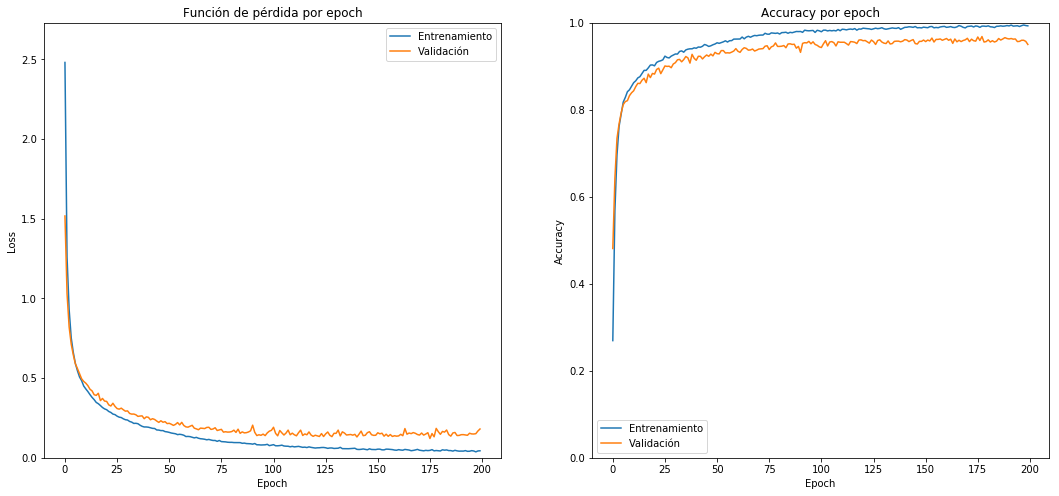

In [6]:
plt.figure(20, figsize=(18,8))
plt.subplot(121)
plt.title("Función de pérdida por epoch")
plt.plot(train_triang.history['loss'], label="Entrenamiento")
plt.plot(train_triang.history['val_loss'], label="Validación")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.ylim(ymin=0, ymax = np.max(train_triang.history['loss'])*1.1)

plt.subplot(122)
plt.title("Accuracy por epoch")
plt.plot(train_triang.history['acc'], label="Entrenamiento")
plt.plot(train_triang.history['val_acc'], label="Validación")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.ylim(ymin=0, ymax = 1)
plt.show();

De los gráficos se puede ver un entrenamiento eficiente de la red ya que tanto para validación y entrenamiento se tiene una función de pérdida que decae y se logran valores de accuracy de testing de 95% lo cual permite afirmar que se tiene una red robusta para realizar las predicciones.

In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_preds = model.predict(x_test)

Junto a esto se verifica cómo se comporta la red con los datos de validación, para esto se genera una matriz de confusión la cual permite ver que solo no identifica una bien categoría con una precisión del 72%.

Pese a eso, la mayoría de las categorías son identificadas correctamente.

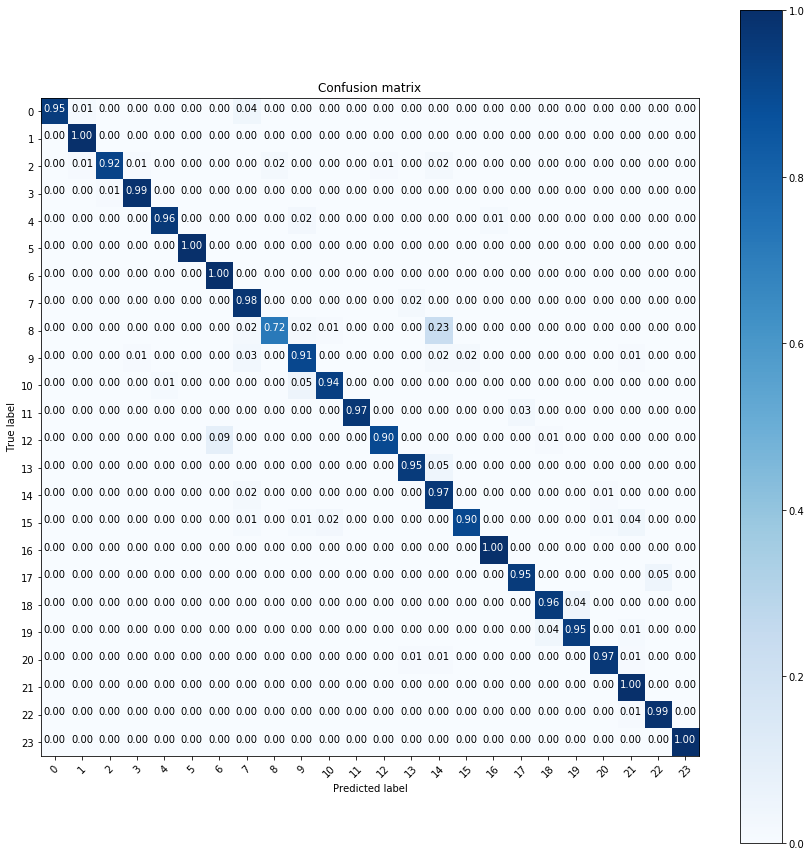

In [9]:
cm = confusion_matrix([np.argmax(x) for x in y_test], [np.argmax(x) for x in y_preds])
plot_confusion_matrix(cm, range(24))

<a id="refs"></a>
## Referencias
[1] Glorot, X., & Bengio, Y. (2010, March). *Understanding the difficulty of training deep feedforward neural networks*. In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).    
[2]  He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Delving deep into rectifiers: Surpassing human-level performance on imagenet classification*. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).  
[3] Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images.